In [1]:
import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
import requests

import os

from astropy.units import one
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, \
                            precision_recall_curve, average_precision_score, roc_auc_score, roc_curve, auc, accuracy_score

import itertools
import random
import math

from IPython.display import clear_output

from tqdm import tqdm_notebook

import pandas as pd

import time
from datetime import datetime

from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
import matplotlib.ticker as ticker
#import matplotlib.pyplot as plt
import copy

from itertools import count
from collections import defaultdict


In [2]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn.utils.rnn import pad_sequence
from torch import Tensor

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as data_utils
import torch.optim.lr_scheduler as lr_scheduler 


In [3]:
np.random.seed(0);
torch.manual_seed(0);

# Hyper-parameters

In [4]:
use_features = True

use_comp_features = True
use_bio_features = True

use_testset = True

do_horz_flip = False

do_cross_validation = False
do_testing_using_best_model = False
do_retraining = True
do_testing_only = False

use_padding_for_bucketing = False

class_weights = {0: 1., 1: 1.} 
class_weights = {0: 2.36/(2.36+1.), 1: 1./(2.36+1.)} 

num_classes=2

val_pct = 0.20


use_full_DS = True;

CLASS_BALANCE_RATIO = 1;


saliency_using_full_dataset = False

# Paths

In [5]:
project_dir = '../'

#ds_dir = f'{project_dir}data/seq/'
ds_dir = f'{project_dir}data/processed/'

snapshot_dir = f'snapshots/'

classes = ['lnc_e','lnc_p']
class_suffix = '_noN'
class_names = ['e-lncRNA','p-lncRNA']

trainval_test_dir = 'train_val_test__80_20'


# sequence files (train + val)
neg_filename = f'{ds_dir}{trainval_test_dir}/{classes[0]}{class_suffix}_tr_val.csv'
pos_filename = f'{ds_dir}{trainval_test_dir}/{classes[1]}{class_suffix}_tr_val.csv'

# sequence files (test)
test_neg_filename = f'{ds_dir}{trainval_test_dir}/{classes[0]}{class_suffix}_test.csv'
test_pos_filename = f'{ds_dir}{trainval_test_dir}/{classes[1]}{class_suffix}_test.csv'

# kmer feature files (train + val)
feature_filenames_class_0 = [f'{ds_dir}{trainval_test_dir}/{classes[0]}{class_suffix}_1mer_features_tr_val.csv',
                             f'{ds_dir}{trainval_test_dir}/{classes[0]}{class_suffix}_2mer_features_tr_val.csv',
                             f'{ds_dir}{trainval_test_dir}/{classes[0]}{class_suffix}_3mer_features_tr_val.csv']
feature_filenames_class_1 = [f'{ds_dir}{trainval_test_dir}/{classes[1]}{class_suffix}_1mer_features_tr_val.csv',
                             f'{ds_dir}{trainval_test_dir}/{classes[1]}{class_suffix}_2mer_features_tr_val.csv',
                             f'{ds_dir}{trainval_test_dir}/{classes[1]}{class_suffix}_3mer_features_tr_val.csv']

# kmer feature files (test)
test_feature_filenames_class_0 = [f'{ds_dir}{trainval_test_dir}/{classes[0]}{class_suffix}_1mer_features_test.csv',
                                  f'{ds_dir}{trainval_test_dir}/{classes[0]}{class_suffix}_2mer_features_test.csv',
                                  f'{ds_dir}{trainval_test_dir}/{classes[0]}{class_suffix}_3mer_features_test.csv']
test_feature_filenames_class_1 = [f'{ds_dir}{trainval_test_dir}/{classes[1]}{class_suffix}_1mer_features_test.csv',
                                  f'{ds_dir}{trainval_test_dir}/{classes[1]}{class_suffix}_2mer_features_test.csv',
                                  f'{ds_dir}{trainval_test_dir}/{classes[1]}{class_suffix}_3mer_features_test.csv']


# biological featurefiles (train + val)
bio_feature_filenames_class_0 = [f'{ds_dir}{trainval_test_dir}/{classes[0]}_nosim.fa.matrix_tr_val.csv']
bio_feature_filenames_class_1 = [f'{ds_dir}{trainval_test_dir}/{classes[1]}_nosim.fa.matrix_tr_val.csv']

# biological featurefiles (test)
test_bio_feature_filenames_class_0 = [f'{ds_dir}{trainval_test_dir}/{classes[0]}_nosim.fa.matrix_test.csv']
test_bio_feature_filenames_class_1 = [f'{ds_dir}{trainval_test_dir}/{classes[1]}_nosim.fa.matrix_test.csv']

if(saliency_using_full_dataset):
    test_neg_filename = f'{ds_dir}seq/{classes[0]}{class_suffix}.seq'
    test_pos_filename = f'{ds_dir}seq/{classes[1]}{class_suffix}.seq'

    # kmer feature files (train + val)
    test_feature_filenames_class_0 = [f'{ds_dir}computed_features/{classes[0]}{class_suffix}.seq_1mer_features.csv',
                                 f'{ds_dir}computed_features/{classes[0]}{class_suffix}.seq_2mer_features.csv',
                                 f'{ds_dir}computed_features/{classes[0]}{class_suffix}.seq_3mer_features.csv']
    test_feature_filenames_class_1 = [f'{ds_dir}computed_features/{classes[1]}{class_suffix}.seq_1mer_features.csv',
                                 f'{ds_dir}computed_features/{classes[1]}{class_suffix}.seq_2mer_features.csv',
                                 f'{ds_dir}computed_features/{classes[1]}{class_suffix}.seq_3mer_features.csv']

    # biological featurefiles (train + val)
    test_bio_feature_filenames_class_0 = [f'{ds_dir}biofeatures/{classes[0]}_nosim.fa.matrix']
    test_bio_feature_filenames_class_1 = [f'{ds_dir}biofeatures/{classes[1]}_nosim.fa.matrix']
    

# Load sequence data

In [6]:
def get_data(filename):
    with open(filename,'r') as nf:
        examples = [seq.strip() for seq in nf.readlines()]
        num_examples = len(examples) # number of negative examples
    return num_examples, examples

# read sequence data
num_neg, neg_examples = get_data(neg_filename)
print("num_neg:", num_neg)
num_pos, pos_examples = get_data(pos_filename)
print("num_pos:", num_pos)

if do_horz_flip:
    num_neg *=2
    neg_examples.extend(neg_examples)    

    num_pos *=2
    pos_examples.extend(pos_examples)    
    print("After augmentation")
    print("num_neg:", num_neg)
    print("num_pos:", num_pos)
    
# combine negative and positive examples (sequences)
sequences_DS = neg_examples + pos_examples 
labels_DS = np.array([0]*num_neg + [1]*num_pos)   

print("# of sequences:", len(sequences_DS), "\n# of labels:", len(labels_DS), "\nlength of sequences:", len(sequences_DS[0]))

idx_neg =  np.arange(num_neg)
idx_pos =  num_neg + np.arange(num_pos) # needed shift as negative examples' idx in concatenated array: [neg, pos]

print("index sizes:",len(idx_neg), len(idx_pos))


if (use_testset):
    print()

    # read test sequence data
    test_num_neg, test_neg_examples = get_data(test_neg_filename)
    print("test_num_neg:", test_num_neg)
    test_num_pos, test_pos_examples = get_data(test_pos_filename)
    print("test_num_pos:", test_num_pos)

    if do_horz_flip:
        test_num_neg *=2
        test_neg_examples.extend(test_neg_examples)    

        test_num_pos *=2
        test_pos_examples.extend(test_pos_examples)    
        print("After augmentation")
        print("num_neg:", num_neg)
        print("num_pos:", num_pos)
    
    # combine negative and positive test examples (sequences)
    test_sequences_DS = test_neg_examples + test_pos_examples 
    test_labels_DS = np.array([0]*test_num_neg + [1]*test_num_pos)   

    print("# of test sequences:", len(test_sequences_DS), "\n# of test labels:", len(test_labels_DS), "\nlength of test sequences:", len(test_sequences_DS[0]) )

    test_idx_neg =  np.arange(test_num_neg)
    test_idx_pos =  test_num_neg + np.arange(test_num_pos) # needed shift as negative examples' idx in concatenated array: [neg, pos]
    print("test index size",len(test_idx_neg), len(test_idx_pos))

    
# with open(neg_filename,'r') as nf:
#     neg_examples = [seq.strip() for seq in nf.readlines()]
#     num_neg = len(neg_examples) # number of negative examples
#     print(num_neg)

# with open(pos_filename,'r') as pf:
#     pos_examples = [seq.strip() for seq in pf.readlines()]
#     num_pos = len(pos_examples) # number of positive examples
#     print(num_pos)    

# sequences_DS = neg_examples + pos_examples 
# labels_DS = np.array([0]*num_neg + [1]*num_pos)   
# len(sequences_DS), len(labels_DS)



num_neg: 2312
num_pos: 5462
# of sequences: 7774 
# of labels: 7774 
length of sequences: 600
index sizes: 2312 5462

test_num_neg: 579
test_num_pos: 1366
# of test sequences: 1945 
# of test labels: 1945 
length of test sequences: 600
test index size 579 1366


# Load features (if used)

In [7]:
if(use_features):
    
    if use_comp_features:
        # kmers (train + val)
        features_class0 = np.concatenate([pd.read_csv(feature_filename, header=None, sep="\t", index_col=False).to_numpy() for feature_filename in feature_filenames_class_0], axis = 1)
        features_class1 = np.concatenate([pd.read_csv(feature_filename, header=None, sep="\t", index_col=False).to_numpy() for feature_filename in feature_filenames_class_1], axis = 1)
        
        if do_horz_flip:
            features_class0 = np.concatenate([features_class0, features_class0], axis = 0)    
            features_class1 = np.concatenate([features_class1, features_class1], axis = 0)    
            
        neg_features = features_class0
        pos_features = features_class1

        # combine negative and positive examples into a single array
        features_DS = np.concatenate([features_class0, features_class1], axis = 0)
    
        print("neg features shape:",neg_features.shape, "\npos features shape:",pos_features.shape, "\ncombined features shape:",features_DS.shape)
        print()

    if use_bio_features:  
        # bio featurers (train + val)
        bio_features_class0 = np.concatenate([pd.read_csv(bio_feature_filename, header=None, index_col=False).to_numpy() for bio_feature_filename in bio_feature_filenames_class_0], axis = 1)
        bio_features_class1 = np.concatenate([pd.read_csv(bio_feature_filename, header=None, index_col=False).to_numpy() for bio_feature_filename in bio_feature_filenames_class_1], axis = 1)

        if do_horz_flip:
            bio_features_class0 = np.concatenate([bio_features_class0, bio_features_class0], axis = 0)    
            bio_features_class1 = np.concatenate([bio_features_class1, bio_features_class1], axis = 0)   
        
        neg_bio_features = bio_features_class0
        pos_bio_features = bio_features_class1

        # combine negative and positive examples into a single array
        bio_features_DS = np.concatenate([bio_features_class0, bio_features_class1], axis = 0)  

        print("neg bio features shape:",neg_bio_features.shape, "\npos bio features shape:",pos_bio_features.shape, "\ncombined bio features shape:",bio_features_DS.shape)
        print()

        
    if (use_testset):

        if use_comp_features:
            # kmers (test)
            test_features_class0 = np.concatenate([pd.read_csv(test_feature_filename, header=None, sep="\t", index_col=False).to_numpy() for test_feature_filename in test_feature_filenames_class_0], axis = 1)
            test_features_class1 = np.concatenate([pd.read_csv(test_feature_filename, header=None, sep="\t", index_col=False).to_numpy() for test_feature_filename in test_feature_filenames_class_1], axis = 1)

            if do_horz_flip:
                test_features_class0 = np.concatenate([test_features_class0, test_features_class0], axis = 0)    
                test_features_class1 = np.concatenate([test_features_class1, test_features_class1], axis = 0)                 

            test_neg_features = test_features_class0
            test_pos_features = test_features_class1    

            # combine negative and positive examples into a single array    
            test_features_DS = np.concatenate([test_features_class0, test_features_class1], axis = 0)    
            print("test neg features shape:",test_neg_features.shape, "\ntest pos features shape:",test_pos_features.shape, "\ncombined test features shape:",test_features_DS.shape)
            print()
            
        if use_bio_features:  
            # bio featurers (test)
            test_bio_features_class0 = np.concatenate([pd.read_csv(bio_feature_filename, header=None, index_col=False).to_numpy() for bio_feature_filename in test_bio_feature_filenames_class_0], axis = 1)
            test_bio_features_class1 = np.concatenate([pd.read_csv(bio_feature_filename, header=None, index_col=False).to_numpy() for bio_feature_filename in test_bio_feature_filenames_class_1], axis = 1)

            if do_horz_flip:
                test_bio_features_class0 = np.concatenate([test_bio_features_class0, test_bio_features_class0], axis = 0)    
                test_bio_features_class1 = np.concatenate([test_bio_features_class1, test_bio_features_class1], axis = 0)                 
   

            test_neg_bio_features = test_bio_features_class0
            test_pos_bio_features = test_bio_features_class1

            # combine negative and positive examples into a single array    
            test_bio_features_DS = np.concatenate([test_bio_features_class0, test_bio_features_class1], axis = 0)    
    
            print("test neg bio features shape:",test_neg_bio_features.shape, "\ntest pos bio features shape:",test_pos_bio_features.shape, "\ntest combined bio features shape:",test_bio_features_DS.shape)
            print()

neg features shape: (2312, 252) 
pos features shape: (5462, 252) 
combined features shape: (7774, 252)

neg bio features shape: (2312, 292) 
pos bio features shape: (5462, 292) 
combined bio features shape: (7774, 292)

test neg features shape: (579, 252) 
test pos features shape: (1366, 252) 
combined test features shape: (1945, 252)

test neg bio features shape: (579, 292) 
test pos bio features shape: (1366, 292) 
test combined bio features shape: (1945, 292)



In [8]:
# labels_DS[:10],labels_DS[18487-10:18487+10],labels_DS[-10:],len(labels_DS) 

In [9]:
# def compute_kmer_counts(seq, k, do_sliding = True):
#     alphabet = list(set(list(seq)))
#     alphabet.sort()

#     kmers_list = []
#     kmers_list.append(alphabet)
    
#     for k_idx in range(k-1):
#         kmers_list.append([a+b for a in kmers_list[k_idx] for b in alphabet ])

#     seq_lst = list(seq)
#     subs = ["".join(seq_lst[idx:idx+k]) for idx in range(len(seq)-k+1)]
#     kmers = kmers_list[k-1]
#     kmers_counts = [subs.count(kmer) for kmer in kmers]
    
#     return kmers_counts

# results = []
# for idx in range(len(sequences_DS)):#np.random.randint(0, len(sequences_DS), size= (20,1) ):
#     #idx = idx.item()
#     seq = sequences_DS[idx]
#     kmer_counts1 = compute_kmer_counts(seq[:1000],3)
#     kmer_counts2 = compute_kmer_counts(seq[1000:],3)
#     #print(kmer_counts1, "||", kmer_counts2, "||",features_DS[idx,:][40:])
#     result = np.all(np.array(kmer_counts1+kmer_counts2) == np.array(features_DS[idx,40:].squeeze())) 
#     if(not result):
#         print(idx)
#         print(kmer_counts1)
#         print(kmer_counts2)
#         print(seq)
#         print(features_DS[idx,40:72].squeeze())
#         print(features_DS[idx,72:].squeeze())
#         print()
#     results.append(result)

In [10]:
# np.all(results)

## subsample dataset (if needed)

In [11]:
# shuffle the positive and negative indices
idx_neg_shuf = np.random.permutation(idx_neg)
idx_pos_shuf = np.random.permutation(idx_pos)

# cap class size ratio to be used to the class size ratio of the dataset
DS_class_balance_ratio = len(idx_neg_shuf)/len(idx_pos_shuf) 
DS_class_balance_ratio = 1/DS_class_balance_ratio if DS_class_balance_ratio < 1 else DS_class_balance_ratio


if DS_class_balance_ratio < CLASS_BALANCE_RATIO:
    effective_class_balance_ratio = DS_class_balance_ratio 
else:
    effective_class_balance_ratio = CLASS_BALANCE_RATIO

print("class balance ratio in dataset:", DS_class_balance_ratio)
print("specified class balance ratio:", CLASS_BALANCE_RATIO)
print("effective class balance ratio being used :", effective_class_balance_ratio)    
print()

if use_full_DS:
    merged_index = np.concatenate([idx_neg_shuf, idx_pos_shuf], axis = 0) ;
    
    print("no subsampling, size of neg :", len(idx_neg_shuf))
    print("no subsampling, size of pos :", len(idx_pos_shuf))
    print( 'no subsampling, length of merged: ' , len(merged_index) )
    print()
else:
    if(num_neg <= num_pos):
        idx_neg_selected =  idx_neg_shuf
        idx_pos_selected =  idx_pos_shuf[:int(effective_class_balance_ratio*num_neg)]
    else:
        idx_neg_selected =  idx_neg_shuf[:int(effective_class_balance_ratio*num_pos)]
        idx_pos_selected =  idx_pos_shuf
    
    # shift the pos's indices as pos examples come after negative example in the combines data structure
    #idx_pos_selected += len(neg_examples)  
    #idx_pos_selected += len(idx_neg_selected)  
        
    merged_index = np.concatenate([idx_neg_selected, idx_pos_selected], axis = 0)
    
    print("after subsampling, size of neg :", len(idx_pos_selected))
    print("after subsampling, size of pos :", len(idx_neg_selected))
    print( 'len of merged : ' , len(merged_index) )
    print()


# perform subsampling
sequences, labels = zip(*[ (sequences_DS[i], labels_DS[i]) for i in merged_index ])
labels = np.array(labels)

print('#seq before subsampling:' , len(sequences_DS) )
print('#labels before subsampling:' , len(labels_DS) )
print()
print('#seq after subsampling:' , len(sequences) )
print('#labels after subsampling:' , len(labels) )
print()


if (use_testset):
    # no subsampling for test set
    test_sequences, test_labels = test_sequences_DS, test_labels_DS
    test_labels = np.array(test_labels)

if(use_features):

    if use_comp_features:
        features = features_DS[merged_index,:]
        print('#features before subsampling:' , len(features_DS), '#features after subsampling:' , len(features))    
    else:
        features = None
        
    if use_bio_features:    
        bio_features = bio_features_DS[merged_index,:]
        print('#bio features before subsampling:' , len(bio_features_DS) , '#bio features after subsampling:' , len(bio_features) )    
    else:
        bio_features = None
        
    if (use_testset):
        # no subsampling for test set
        if use_comp_features: 
            test_features = test_features_DS 
        else: 
            test_features = None 
        
        if use_bio_features:  
            test_bio_features = test_bio_features_DS
        else:
            test_bio_features = None

class balance ratio in dataset: 2.362456747404844
specified class balance ratio: 1
effective class balance ratio being used : 1

no subsampling, size of neg : 2312
no subsampling, size of pos : 5462
no subsampling, length of merged:  7774

#seq before subsampling: 7774
#labels before subsampling: 7774

#seq after subsampling: 7774
#labels after subsampling: 7774

#features before subsampling: 7774 #features after subsampling: 7774
#bio features before subsampling: 7774 #bio features after subsampling: 7774


In [12]:
# np.all(np.sort(sequences_DS, axis = 0)==np.sort(sequences, axis = 0))

### NOT ACCURATE ANYMORE: sanity check: checking whether the selected positive examples are truly from the original positive examples loaded from the disk

In [13]:
# tmp_neg = [sequences[i] for i in range(len(labels)) if labels[i] == 0]
# tmp_pos = [sequences[i] for i in range(len(labels)) if labels[i] == 1]
# print(len(tmp_pos), len(tmp_neg))

# print(np.all([s in neg_examples for s in tmp_neg]))
# print(np.all([s in pos_examples for s in tmp_pos]))

In [14]:
# identify the alphabet of the whole DS
unique_DNAs= set()
for seq in sequences_DS:
    s = set (seq)
    unique_DNAs = unique_DNAs | s

unique_DNAs = list(unique_DNAs)
unique_DNAs.sort()
num_DNAs = len(unique_DNAs)
print("All nucleotides: ")
print(unique_DNAs)
print("# unique nucleaotides:",num_DNAs)

All nucleotides: 
['A', 'C', 'G', 'T']
# unique nucleaotides: 4


In [15]:
# lengths of the sequences
sequence_lens = np.array([len(x) for x in sequences])

print("# of different sample lengths:",len(np.unique(sequence_lens)))
print("number of samples:",len(sequence_lens))
print("length of shortest sample: ",min(sequence_lens))
print("length of longest sample: ",max(sequence_lens))
print()

if (use_testset):
    # lengths of the sequences
    test_sequence_lens = np.array([len(x) for x in test_sequences])

    print("# of different sample lengths:",len(np.unique(sequence_lens)))
    print("number of samples:",len(sequence_lens))
    print("length of shortest sample: ",min(sequence_lens))
    print("length of longest sample: ",max(sequence_lens))

# of different sample lengths: 1
number of samples: 7774
length of shortest sample:  600
length of longest sample:  600

# of different sample lengths: 1
number of samples: 7774
length of shortest sample:  600
length of longest sample:  600


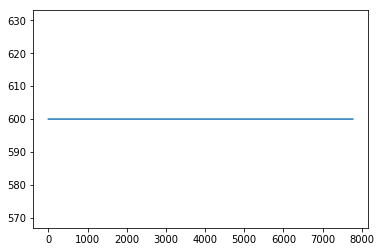

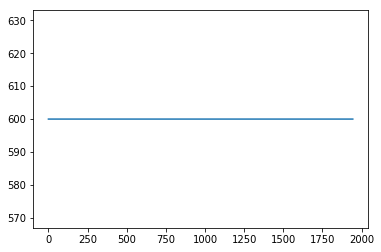

In [16]:
# plot the lengths of the sequences
plt.plot(list(sorted(sequence_lens)))
plt.show()

if (use_testset):
    # plot the lengths of the test sequences
    plt.plot(list(sorted(test_sequence_lens)))

In [17]:
# code borrowed from lncNet repository for integer coding and bucketing

class CharacterTable(object): #make encoding table
    '''
    Given a set of characters:
    + Encode them to integer coding representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    #chars : 0 (padding ) + other characters
    '''
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, l):
        X = np.zeros((len(l)),dtype=np.int32)
        for i, c in enumerate(l):
            X[i]= self.char_indices[c]
    
        return X

    def decode(self, X, calc_argmax=True):
        if calc_argmax:
            X = X.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in X)

def create_index_buckets(sequence_lens, bucket_high_lims):
    
    # bucket of data indices
    buckets = [ [] for _ in bucket_high_lims]

    for i,len_x in enumerate(sequence_lens):
        for b_id, bucket_len in enumerate(bucket_high_lims):
            if len_x <= bucket_len:
                # append the index of the data instead of the actual data
                buckets[b_id].append(i)  
                break

    return buckets

def seq2intcoding(seqs, ctable):
    
    X=[]
    for seq in seqs:
        enc = ctable.encode(seq)
        X.append(enc)
    
    X = np.array(X)
    
    return X

# Do index bucketing

In [18]:
bucket_high_lims = [500*i for i in range(1,201)]

if (use_testset):
    test_bucket_high_lims = [500*i for i in range(1,201)]

# do not pad sequences if option not enabled (for datasets with fixed-length sequences where the length does not match any bucket's high limit)
if not use_padding_for_bucketing:
    assert max(sequence_lens) == min(sequence_lens), "Sequence length varies; please enable padding for bucketing"
    assert max(test_sequence_lens) == min(test_sequence_lens), "test set's sequence length varies; please enable padding for bucketing"
    bucket_high_lims = [max(sequence_lens)]   # fixed length sequences, so there will be only one bucket
    test_bucket_high_lims = [max(test_sequence_lens)]
    
chars= "0" + "".join(unique_DNAs)
ctable = CharacterTable(chars)


# integer coded sequences
seq_int_coded = seq2intcoding(sequences, ctable)
# create buckets containing data indices
idxs_in_buckets = create_index_buckets(sequence_lens, bucket_high_lims)   # returning array of arrays containing indices of data to put in each bucket
# remove buckets with no elements
used_bucket_idxs, idxs_in_buckets  = zip(*[(i,idxs_in_buckets[i]) for i,b in enumerate(idxs_in_buckets) if b])
# only keep the high limits for the non-empty buckets
bucket_high_lims = np.array(bucket_high_lims).reshape(1,-1)[used_bucket_idxs] 


# for test set
if (use_testset):
    # integer coded sequences
    test_seq_int_coded = seq2intcoding(test_sequences, ctable)
    # create buckets containing data indices
    test_idxs_in_buckets = create_index_buckets(test_sequence_lens, test_bucket_high_lims)   # returning array of arrays containing indices of data to put in each bucket
    # remove buckets with no elements
    test_used_bucket_idxs, test_idxs_in_buckets  = zip(*[(i,test_idxs_in_buckets[i]) for i,b in enumerate(test_idxs_in_buckets) if b])
    # only keep the high limits for the non-empty buckets
    test_bucket_high_lims = np.array(test_bucket_high_lims).reshape(1,-1)[test_used_bucket_idxs] 


# Do sequence and feature (if being used) bucketing along with one-hot encoding of the sequences

In [19]:
def create_data_buckets(X, Y, idxs_in_buckets, bucket_high_lims, sequence_lens, features = None, bio_features = None):    
    
    """
    params: 
    X: integer coded sequences
    Y: labels
    idx_buckets: array-like containing list of indices in each bucket
    bucket_high_lims: maximum length of sequences in each bucket
    sequence_lens: lengths of sequences in X

    """

    X_buckets = []
    X_buckets_padded = []
    Y_buckets = []
    X_buckets_packed = []
    
    
    if features is None and bio_features is None:  
        use_features = False
    else:
        use_features = True
        
    sequence_lens = np.array(sequence_lens)
    
    for b_id, idxs_in_bucket in enumerate(idxs_in_buckets):
        
        seq_lens_bucket = sequence_lens[idxs_in_bucket]
        
        # ignore empty buckets
        if len(idxs_in_bucket)==0:
            continue

        num_elements_in_bucket = len(idxs_in_bucket)
        
        # indices of the data points in this bucket
        x_idxs = np.array(idxs_in_bucket)
        
        #all_idxs = np.concatenate([all_idxs, x_idxs], axis = 0)
        
        # indices to the bucket contents (which is a set of indices starting from 0 ending in num_elements_in_bucket-1 )
        # for future compatibility - for example, selecting a fraction of the elements from each bucket, in which case, select a subset of this list of indices
        idx_in_bucket = np.arange(num_elements_in_bucket)
        
        X_bucket = X[ x_idxs[ idx_in_bucket ] ]   
        Y_bucket = Y[ x_idxs[ idx_in_bucket ] ]
        
         
        X_bucket_T = [torch.Tensor(x) for x in X_bucket]
        #print(len(X_bucket_T))
        
        # in pytorch, in order to pad a list of sequences to a specific length, we need a (possibly dummy) sequence of that length
        X_bucket_T.append(torch.zeros((bucket_high_lims[b_id],)))
        X_bucket_padded = pad_sequence(X_bucket_T, batch_first = True, padding_value = 0.0 )
        X_bucket_padded = X_bucket_padded.numpy()

        #print(X_bucket_padded.shape)
        
        # delete the last dummy row that served as element with padding length 
        X_bucket_padded = np.delete(X_bucket_padded, -1, axis = 0)        

        #print(X_bucket_padded.shape)
        
        # one-hot encoding
        X_bucket_padded = (np.arange(X_bucket_padded.max()+1) == X_bucket_padded[:,:,None]).astype(dtype='float32') 
        X_bucket_padded = np.delete(X_bucket_padded,0, axis=-1)
        
        #X_bucket = [X_bucket_padded[idx][:seq_lens_bucket[idx],:] for idx in range(X_bucket_padded.shape[0]) ]
        
        #X_buckets.append(X_bucket)
        if(use_features):
            
            if not features is None:
                features_expanded = np.expand_dims(features[x_idxs[idx_in_bucket],:],-1)  # add a last dimension - feature dimension (length =1)
            else:
                features_expanded = np.empty((0,0))
              
            if not bio_features is None:
                bio_features_expanded = np.expand_dims(bio_features[x_idxs[idx_in_bucket],:],-1)
            else:
                bio_features_expanded = np.empty((0,0))
            
            X_bucket_padded = ( X_bucket_padded, features_expanded, bio_features_expanded )  
            
            print(X_bucket_padded[0].shape, X_bucket_padded[1].shape, X_bucket_padded[2].shape)
        
        else:
            X_bucket_padded = ( X_bucket_padded, )
            
        X_buckets_padded.append(X_bucket_padded)        
        Y_buckets.append(Y_bucket)
    
        #print(torch.Tensor(X_bucket_padded).shape)
        #sorted_lens = list(sorted(sequence_lens[idx_buckets[b_id]]))
        #print(sorted_lens[:10])

        # returns a packed sequences with #batches equal to the size of the maximum seq length, where a batch size
        # corresponds to how many sequences have a valid input at that time step
        #packed_input = pack_padded_sequence(torch.Tensor(X_bucket_padded), seq_lens_buckets, batch_first=True, enforce_sorted=False)
        #X_buckets_packed.append(packed_input)
        
    return X_buckets_padded,Y_buckets#, X_buckets_packed

In [20]:
if(use_features):
    
    X_buckets, Y_buckets = create_data_buckets(seq_int_coded, labels, idxs_in_buckets, bucket_high_lims, sequence_lens, features, bio_features)
    
    if (use_testset):
        test_X_buckets, test_Y_buckets = create_data_buckets(test_seq_int_coded, test_labels, test_idxs_in_buckets, test_bucket_high_lims, test_sequence_lens, test_features, test_bio_features)
        
else:

    X_buckets, Y_buckets = create_data_buckets(seq_int_coded, labels, idxs_in_buckets, bucket_high_lims, sequence_lens)

    if (use_testset):
        test_X_buckets, test_Y_buckets = create_data_buckets(test_seq_int_coded, test_labels, test_idxs_in_buckets, test_bucket_high_lims, test_sequence_lens)
    
    

(7774, 600, 4) (7774, 252, 1) (7774, 292, 1)
(1945, 600, 4) (1945, 252, 1) (1945, 292, 1)


In [21]:
# for b_id in range(len(X_buckets)):
#     idxs_bucket = idx_buckets[b_id]
#     for rand_idx in np.random.randint(len(X_buckets[b_id]), size = 10):
#         print(X_buckets[b_id][rand_idx].shape, sequence_lens[idxs_bucket[rand_idx]])
        
#     print()

In [22]:
# len(X_buckets), len(idxs_in_buckets), torch.cuda.is_available()

In [23]:
# bucket_content = X_buckets[0]
# seq_elements = bucket_content[0]
# seq_element = seq_elements[0,:]

# len(bucket_content), seq_element.shape

## sanity check 
[converting one-hot encoded sequences to DNA seq and checking against the corresponding original from the dataset]


In [24]:
# # sanity check [converting one-hot encoded sequences to DNA seq and checking against the corresponding original from the dataset]

# def compute_kmer_counts(seq, k, alphabet, do_sliding = True):

#     kmers_list = []
#     kmers_list.append(alphabet)
    
#     for k_idx in range(k-1):
#         kmers_list.append([a+b for a in kmers_list[k_idx] for b in alphabet ])

#     seq_lst = list(seq)
#     subs = ["".join(seq_lst[idx:idx+k]) for idx in range(len(seq)-k+1)]
#     kmers = kmers_list[k-1]
#     kmers_counts = [subs.count(kmer) for kmer in kmers]
    
#     return kmers_counts

# data_check_arr = []
# feature_check_arr = []
# incorrect_feature_match_indices = []
# incorrect_feature_match_seqs = []

# for b_idx in range(len(X_buckets)):
#     x_bucket_padded = X_buckets[b_idx]

#     if(use_features):
#         features_bucket = x_bucket_padded[1]
#         x_bucket_padded = x_bucket_padded[0]
        
#     y_bucket = Y_buckets[b_idx]
#     idx_bucket = idxs_in_buckets[b_idx]
    
#     for seq_idx in range(x_bucket_padded.shape[0]):
#         seq_oh = x_bucket_padded[seq_idx,:,:]
        
#         seq_str = "".join([unique_DNAs[dna_idx] for dna_idx in np.argmax(seq_oh, axis = -1)]) # convert from one-hot to DNA
#         seq_str = seq_str[:sequence_lens[idx_bucket[seq_idx]]]  # get rid of the padding
        
#         seq = sequences[idx_bucket[seq_idx]]  # original seq retrieved according to saved indices of the one-hot data
        
#         if(use_features):
#             idx_range = [[0,11],[12,59],[60,251]]
#             feature_check_acc = []
#             #seq = seq[-500:] + seq[:-500]
#             for k in range(1,4):
#                 kmer_counts1 = compute_kmer_counts(seq_str[:200], k, unique_DNAs)    
#                 kmer_counts2 = compute_kmer_counts(seq_str[200:400], k, unique_DNAs)    
#                 kmer_counts3 = compute_kmer_counts(seq_str[400:], k, unique_DNAs)    
            
#                 features_computed= np.array(kmer_counts1+kmer_counts2+kmer_counts3)
#                 features_from_file = features_bucket[seq_idx,idx_range[k-1][0]:idx_range[k-1][1]+1].squeeze()
#                 feature_check = np.all( features_computed == features_from_file)
#                 #print(feature_check)
#                 #print(features_computed)
#                 #print(features_from_file)
#                 #print()
#                 #print(features_bucket[seq_idx,idx_range[k-1][0]:idx_range[k-1][1]+1].squeeze())
#                 #print()
#                 feature_check_acc.append(feature_check)
#             #print()    
#             feature_check_arr.append(np.all(feature_check_acc))
            
#             if not np.all(feature_check_acc):
#                 #print(seq_idx)
#                 incorrect_feature_match_indices.append(seq_idx)
#                 incorrect_feature_match_seqs.append(seq)
#                 for k in range(1,4):
#                     kmer_counts1 = compute_kmer_counts(seq_str[:200], k)    
#                     kmer_counts2 = compute_kmer_counts(seq_str[200:400], k)    
#                     kmer_counts3 = compute_kmer_counts(seq_str[400:], k)    

#                     features_computed= np.array(kmer_counts1+kmer_counts2+kmer_counts3)
#                     features_from_file = features_bucket[seq_idx,idx_range[k-1][0]:idx_range[k-1][1]+1].squeeze()
#                     feature_check = np.all( features_computed == features_from_file)
#                     feature_check_acc.append(feature_check)
#                     print(len(kmer_counts1), len(kmer_counts2), len(kmer_counts3),features_computed.shape, features_from_file.shape)
#                 print(seq)
#                 print(seq_oh.shape, len(seq))
#                 print()
#         data_check_arr.append(seq == seq_str)
        
        
# print("One-hot encoding and sequence bucketing is correct:", np.all(np.array(data_check_arr)))

# if(use_features):
#     print("feature computation and bucketing is correct:", np.all(np.array(feature_check_arr)))

In [25]:
# s = "CATCACTATCATCATCATCATCACACCGCCACCATCACCACCACCACCATCACACCACCACCACCACCACCACCGTCACCATCACTATCATCATCATCACACCACCACCACCACCACCATCATCACTATCATCATCATCATCACCACACCACCACCATCACCACCACCACCATCACACCACCACCACCACTGTCACCACCACCACCACCACCATCACACCACCACCACCGCCACCGTCGTCATCACTATCATCATCATCATCACACCACCACCATCACCACCACCATCACACCACCACCACCACTACTGTCATCACTATCATCATCATCACACCACCACCATCACCATCATCACACCACCACCACCATCACCATCACCATCATCACACCACCACCACCATCACACCACCACCACCATCATTATCATCACCATCATCACACCACCACCACCACCATCACCATCACCATCATCACACCACCACCACCATTACCATCACCATCATCACACCACCACCACCACCATTACCATCACCATCATCACACCACCACCATCACCATCATCACACCACCACCACCATCACCATCATCACACCACCACCAT"
# kcount = compute_kmer_counts(s[400:], 1)

# print(s[400:])
# kcount, s[400:].count('G'), len(s[400:]), len(s),[s[400:].count(c) for c in "ACGT"]
# incorrects = [sequences[idxs_buckets[0][i]] for i in incorrect_feature_match_indices]
# [print(incorrect,"\n\n") for incorrect in incorrects]

In [26]:
# len(incorrect_feature_match_indices), incorrect_feature_match_seqs

In [27]:
## Verify that in a packed seq, batch_size equals the number of sequences having a valid input at (index+1) of the index batch_size in batch_sizes

# sequence_lens_np = np.array(sequence_lens)
# batch_size_idx = random.choice(range(len(X_buckets_packed[0].batch_sizes)))
# batch_size = X_buckets_packed[0].batch_sizes[batch_size_idx]
# batch_size.numpy() == np.sum(sequence_lens_np[idx_buckets[0]]>=(batch_size_idx+1))

# Metrics

In [28]:
class Metrics:
    
    def __init__(self, benchmark_acc = None, benchmark_f1 = None, benchmark_spec = None, benchmark_sen = None, benchmark_auc = None, benchmark_mcc = None):
        self.b_accuracy = benchmark_acc
        self.b_f1 = benchmark_f1
        self.b_sensitivity = benchmark_sen
        self.b_specificity = benchmark_spec
        self.b_auc_roc = benchmark_auc
        self.b_mcc = benchmark_mcc
        
    def reset_history(self):
        self.accuracies = []
        self.f1s = []
        self.recalls = []
        self.precisions = []
        self.sensitivity = []
        self.specificity = []
        self.auc_roc = []        
        self.tp_tn_fp_fn = []
        self.mcc = []

    @classmethod
    def compute_mcc(cls, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        mcc = (tp*tn - fp*fn) / (np.sqrt(  (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)  ) + 1e-8) 
        return mcc
    
    @classmethod
    def compute_sensitivity(cls, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp/(tp+fn)
        return sensitivity
    
    @classmethod
    def compute_specificity(cls, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn/(fp+tn)
        return specificity
    
    @classmethod
    def compute_accuracy(cls, y_true, y_pred):
        accuracy = (y_true==y_pred).sum()/len(y_true)
        return accuracy
    
    def compute_metrics(self, y_true, y_pred, epoch, do_print = False, store_vals = False):
        accuracy = (y_true==y_pred).sum()/len(y_true)
    
        cm = confusion_matrix(y_true, y_pred)
        #cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        tn, fp, fn, tp = cm.ravel()

        specificity = tn/(fp+tn)
        sensitivity = tp/(tp+fn)
        f1 = f1_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        auc_roc = roc_auc_score( y_true, y_pred )  
        mcc = (tp*tn - fp*fn) / (np.sqrt(  (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)  ) + 1e-8) 
        
        results = {'accuracy': accuracy, 'specificity':specificity, 'sensitivity':sensitivity, 'f1_score':f1, 'auc_roc':auc_roc, 'recall':recall, 
                   'precision': precision, 'tp_fp_tn_fn':{'tp':tp, 'fp':fp, 'tn':tn, 'fn':fn}, 'mcc': mcc }
        
        if(store_vals):
            self.accuracies.append(accuracy)
            self.specificity.append(specificity)
            self.sensitivity.append(sensitivity)
            self.f1s.append(f1)
            self.auc_roc.append(auc_roc)        
            self.recalls.append(recall)
            self.precisions.append(precision)
            self.tp_tn_fp_fn.append((tp, tn, fp, fn)) 
            self.mcc.append(mcc) 
            
        if(do_print):
            is_beaten_acc = False
            is_beaten_f1 = False
            is_beaten_sens = False
            is_beaten_spec = False
            is_beaten_auc = False
            is_beaten_mcc = False
            
            if( not self.b_accuracy is None and accuracy > self.b_accuracy ):
                is_beaten_acc = True
            
            if( not self.b_f1 is None and f1 > self.b_f1 ):
                is_beaten_f1 = True
            
            if( not self.b_sensitivity is None and sensitivity > self.b_sensitivity ):
                is_beaten_sens = True

            if( not self.b_specificity is None and specificity > self.b_specificity ):
                is_beaten_spec = True

            if( not self.b_auc_roc is None and auc_roc > self.b_auc_roc ):
                is_beaten_auc = True

            if( not self.b_mcc is None and mcc > self.b_mcc ):
                is_beaten_mcc = True
                
            print(f'_________________________________________ METRICS for epoch {epoch} _______________________________________________________')
            print('accuracy '.ljust(16),f':{accuracy:.5f} ',f' bmark:({self.b_accuracy:.4f})',f' accuracy beaten:{is_beaten_acc}')
            #print('f1_score '.ljust(16),f':{f1:.5f} ',f' bmark:({self.b_f1:.4f})',f' f1 beaten:{is_beaten_f1}')
            print('sensitivity '.ljust(16),f':{sensitivity:.5f} ',f' bmark:({self.b_sensitivity:.4f})',f' sen.beaten:{is_beaten_sens}')
            print('specificity '.ljust(16),f':{specificity:.5f} ',f' bmark:({self.b_specificity:.4f})',f' spe.beaten:{is_beaten_spec}')
            #print('auc_roc '.ljust(16),f':{auc_roc:.5f} ',f' bmark:({self.b_auc_roc:.4f})',f' spe.beaten:{is_beaten_auc}')            
            print('mcc '.ljust(16),f':{mcc:.5f} ',f' bmark:({self.b_mcc:.4f})',f' mcc.beaten:{is_beaten_mcc}')
            
            #print('precision '.ljust(16),f':{precision} ')
            #print('recall '.ljust(16),f':{recall}')
            print( '---------------------') 
            print(f'| tp:{tp} '.ljust(9),f'| fp:{fp}'.ljust(9),'|')
            print(f'| fn:{fn} '.ljust(9),f'| tn:{tn}'.ljust(9),'|')
            print('---------------------') 

            #if(is_beaten_acc and is_beaten_f1 and is_beaten_sens and is_beaten_spec and is_beaten_auc and is_beaten_mcc):
            if(is_beaten_acc and is_beaten_sens and is_beaten_spec and is_beaten_mcc):
                print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
                print(f'##############################  BEATEN ALL at epoch:{epoch} ##############################################################')
                print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
        
        
        return results
    
    

# Learning rate schedular

self.start_lr 4e-05
self.max_lr 0.001
self.end_lr 4e-09
min: 4e-09


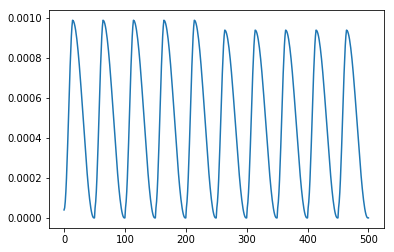

In [29]:
# https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797

class OneCycleCosineAnnealing:
    
    def __init__(self, optim, steps_per_cycle, cycles_per_round, max_lr = 1e-3, start_lr = None, end_lr = None, half_cycle_len_pct = .3, decay_rate = 1.0):
        init_div_factor, last_div_factor = 25.0, 1e4
        self.optim = optim
        self.max_lr = max_lr
        self.decay_rate = decay_rate
        # one round is during a span for which the max lr is constant. It is decayed at the start of every round
        self.cycles_per_round = int(cycles_per_round) 
        self.start_lr = self.max_lr/init_div_factor if start_lr is None else start_lr
        self.end_lr = self.max_lr/(init_div_factor*last_div_factor) if end_lr is None else end_lr
        for param_group in self.optim.param_groups:
            param_group['lr'] = self.start_lr
        self.steps_per_cycle = int(steps_per_cycle)
        self.half_cycle_len_pct = half_cycle_len_pct
        self.peak_step_idx = int(self.steps_per_cycle*self.half_cycle_len_pct)
        print("self.start_lr",self.start_lr)
        print("self.max_lr",self.max_lr)
        print("self.end_lr",self.end_lr)
        
        self.coslr1 = lr_scheduler.CosineAnnealingLR(self.optim, T_max = self.peak_step_idx, eta_min = self.max_lr)        
        self.coslr2 = lr_scheduler.CosineAnnealingLR(self.optim, T_max = self.steps_per_cycle - self.peak_step_idx, eta_min = self.end_lr)
        self.step_idx = 0
        self.cycle_idx = 0
        self.lrs = []
        self.lrs.append(self.optim.param_groups[0]['lr'])
        
    def step(self):
        self.step_idx+=1
        if(self.step_idx < self.peak_step_idx):
            self.coslr1.step()  
        elif(self.step_idx <= self.steps_per_cycle):
            self.coslr2.step()
        else:
            self.cycle_idx +=1
            if(self.cycle_idx%self.cycles_per_round==0):
                self.max_lr*=self.decay_rate
            self.coslr1 = lr_scheduler.CosineAnnealingLR(self.optim, T_max = self.peak_step_idx, eta_min = self.max_lr)  
            self.coslr2 = lr_scheduler.CosineAnnealingLR(self.optim, T_max = self.steps_per_cycle - self.peak_step_idx, eta_min = self.end_lr)
            self.coslr1.step()           
            self.step_idx = 1
            
        self.lrs.append(self.optim.param_groups[0]['lr'])
        
            
model = torch.nn.Linear(1, 1)

max_lr = 1e-3
init_lr = max_lr/25.0
last_lr = max_lr/25e4


num_epochs = 50

optimizer = torch.optim.SGD(model.parameters(), lr = init_lr)

for param_group in optimizer.param_groups:
        param_group['lr'] = init_lr

scheduler = OneCycleCosineAnnealing(optimizer, num_epochs, 5, max_lr = 1e-3, decay_rate = .95)

lrs = []

lrs.append(optimizer.param_groups[0]['lr'])    

for _ in range(10*num_epochs):
    #print("-", l.last_epoch, optim.param_groups[0]['lr'])
    scheduler.step()    
    lrs.append(optimizer.param_groups[0]['lr'])
print("min:",min(lrs))        
plt.plot(lrs)
plt.show()

# Network definitions

In [30]:
# class ListDataset(torch.utils.data.Dataset):
    
#     def __init__(self, data, label) -> None:
#         super().__init__()
#         self.data = data
#         self.label = label
        
#         assert len(self.data) == len(self.label)
    
#     def __getitem__(self, index):
#         return (self.data[index], self.label[index])
    
#     def __len__(self):
#         return len(self.data)
    
# class LSTM_CNN_Net(nn.Module):
    
#     def __init__(self, num_features, seq_info):
#         super(LSTM_CNN_Net, self).__init__()
        
#         hidden_sz, seq_len = seq_info
        
#         self.num_features = num_features
#         self.hidden_sz = hidden_sz
#         self.seq_len = seq_len
#         self.num_layers = 2
#         self.is_bidirectional = True
        
#         #Apply LSTM on the input first, then apply 2-D convolution the final layer's output.        
#         self.lstm = nn.LSTM(input_size = self.num_features, 
#                             hidden_size = self.hidden_sz, 
#                             batch_first = True, bidirectional = self.is_bidirectional, num_layers = self.num_layers)
        
#         self.conv2D_1 = nn.Conv2d(in_channels = 1, out_channels= 32, kernel_size= 3)
#         self.batchnorm2D_1 = nn.BatchNorm2d(num_features = self.conv2D_1.out_channels)
        
#         self.maxpool2D_1 = torch.nn.MaxPool2d(kernel_size=2)
#         self.conv2D_2 = nn.Conv2d(in_channels = 32, out_channels= 64, kernel_size= 5)
#         self.batchnorm2D_2 = nn.BatchNorm2d(num_features = self.conv2D_2.out_channels)
        
#         #self.linear1_allstatesout = nn.Linear(in_features = self.seq_len*self.num_lstm_directions*self.hidden_sz, out_features= self.seq_len*self.hidden_sz//4)        
#         self.linear1 = nn.Linear(in_features = 5*147*64, out_features= 48)
#         self.linear2 = nn.Linear(in_features = 48, out_features= 2)
        
#         self.dropout1 = nn.Dropout(0.8)
#         self.dropout2 = nn.Dropout(0.5)
        
# #         for name, param in self.lstm.named_parameters():
# #             if 'bias' in name:
# #                 nn.init.constant_(param, 0.0)
# #             elif 'weight' in name:
# #                 nn.init.xavier_normal_(param)
        
#     def forward(self, x, seq_lengths):
# #         x_packed = pack_padded_sequence(x, seq_lengths, batch_first=True, enforce_sorted=False)
# #         packed_out, (hn, cn) = self.lstm(x_packed)        
# #         out, input_sizes = pad_packed_sequence(packed_out, batch_first=True)


#         #output: output of shape (batch, seq_len, num_directions * hidden_size) are output features (h_t) from the last layer of the LSTM, for each time step 
#         #                        [if batch_first was True]
#         #hn = output of last time step sz: (num_direction*num_layers, batch_sz, hidden_sz)
#         #cn = cell state of last time step sz: (num_direction*num_layers, batch_sz, hidden_sz)
#         #input is: (batch_sz, sequence_length, num_feature_in_each_time_step) since batch_first was True in LSTM initialization
#         out, (hn, cn) = self.lstm(x)

#         out = torch.unsqueeze(out, dim = 1)
#         out = self.conv2D_1(out)
#         out = self.batchnorm2D_1(out)
#         out = F.relu(out)
        
#         out = self.dropout2(out)
#         out = self.maxpool2D_1(out)
        
#         out = self.conv2D_2(out)
#         out = self.batchnorm2D_2(out)
#         out = F.relu(out)
#         out = self.dropout2(out)
#         out = self.maxpool2D_1(out)
        
#         #print(out.shape)
#         out = self.linear1(out.contiguous().view(-1, 5*147*64))
#         out = F.relu(out)
#         out = self.dropout1(out)
        
#         out = self.linear2(out)
        
#         #l2allstates = torch.sqrt(torch.sum(out**2, dim = 1))
#         #last_state_cmbnd = torch.cat([hn, cn], dim = -1)
#         #l2allstates = self.batchnrm(l2allstates)
#         #net_out = self.linear2(l2allstates.view(-1, 2*self.hidden_sz))
#         #net_out = self.linear2(last_state_cmbnd.view(-1, 2*self.hidden_sz))
        
#         return out

#     def getname(self):
#         return "LSTM_CNN_Net"
    
    
# # The network
# class RNA_Net(nn.Module):
    
#     def __init__(self, num_features, hidden_sz):
#         super(RNA_Net, self).__init__()
        
#         self.num_features = num_features
#         self.hidden_sz = hidden_sz
#         self.lstm = nn.LSTM(input_size = num_features, hidden_size = hidden_sz, batch_first = True, bidirectional = True)
#         self.batchnrm = nn.BatchNorm1d(hidden_sz)
#         #self.linear = nn.Linear(in_features = hidden_sz, out_features= 2)
#         self.linear2 = nn.Linear(in_features = 2*hidden_sz, out_features= 2)
        
# #         for name, param in self.lstm.named_parameters():
# #             if 'bias' in name:
# #                 nn.init.constant_(param, 0.0)
# #             elif 'weight' in name:
# #                 nn.init.xavier_normal_(param)
        
#     def forward(self, x, seq_lengths):
# #         x_packed = pack_padded_sequence(x, seq_lengths, batch_first=True, enforce_sorted=False)
# #         packed_out, (hn, cn) = self.lstm(x_packed)        
# #         out, input_sizes = pad_packed_sequence(packed_out, batch_first=True)

#         out, (hn, cn) = self.lstm(x)        
#         l2allstates = torch.sqrt(torch.sum(out**2, dim = 1))
#         last_state_cmbnd = torch.cat([hn, cn], dim = -1)
#         #l2allstates = self.batchnrm(l2allstates)
#         net_out = self.linear2(l2allstates.view(-1, 2*self.hidden_sz))
#         #net_out = self.linear2(last_state_cmbnd.view(-1, 2*self.hidden_sz))
        
#         return net_out

    
    
class InceptionNet(nn.Module):
    
    def __init__(self, num_features, hidden_sz):
        super(InceptionNet, self).__init__()
        #super().__init__()
        
        self.hidden_sz = hidden_sz
        # inception layer 1
        self.conv11 = nn.Conv1d(num_features,64, kernel_size= 3, padding=1)
        self.conv12 = nn.Conv1d(num_features,64, kernel_size= 5, padding=2)
        self.conv13 = nn.Conv1d(num_features,32, kernel_size= 7, padding=3)
        
        # inception layer 2
        self.conv21 = nn.Conv1d(160,64, kernel_size= 3, padding=1)
        self.conv22 = nn.Conv1d(160,64, kernel_size= 5, padding=2)
        self.conv23 = nn.Conv1d(160,32, kernel_size= 7, padding=3)

        
        # inception layer 3
        self.conv31 = nn.Conv1d(160,64, kernel_size= 3, padding=1)
        self.conv32 = nn.Conv1d(160,64, kernel_size= 5, padding=2)
        self.conv33 = nn.Conv1d(160,32, kernel_size= 7, padding=3)
        
        # inception layer 3
        self.conv41 = nn.Conv1d(160,64, kernel_size= 3, padding=1)
        self.conv42 = nn.Conv1d(160,64, kernel_size= 5, padding=2)
        self.conv43 = nn.Conv1d(160,32, kernel_size= 7, padding=3)
        
        self.maxpool1 = torch.nn.MaxPool1d(kernel_size=2)
        self.maxpool2 = torch.nn.MaxPool1d(kernel_size=4)

        self.conv3 = nn.Conv1d(160,32, kernel_size= 7)
        #self.lstm = nn.LSTM(input_size = 64, hidden_size = hidden_sz, batch_first = True, bidirectional = True)
        self.linear1 = nn.Linear(in_features = 32*15, out_features= 16)
        self.linear2 = nn.Linear(in_features = 16, out_features= 2)
 
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.5)

        
    def forward(self,x, features):
        x = x.permute(0,2,1)
        
        #print(x.shape)
        out1 = self.conv11(x)
        out1 = F.relu(out1)
        out2 = self.conv12(x)
        out2 = F.relu(out2)
        out3 = self.conv13(x)
        out3 = F.relu(out3)
        out = torch.cat((out1,out2,out3),1)
        #out = F.relu(out)
        out = self.dropout1(out)
        out = self.maxpool1(out)
        
        out1 = self.conv21(out)
        out1 = F.relu(out1)
        out2 = self.conv22(out)
        out2 = F.relu(out2)
        out3 = self.conv23(out)
        out3 = F.relu(out3)
        out = torch.cat((out1,out2,out3),1)
        #out = F.relu(out)
        out = self.dropout1(out)
        out = self.maxpool1(out)

        out1 = self.conv31(out)
        out1 = F.relu(out1)
        out2 = self.conv32(out)
        out2 = F.relu(out2)
        out3 = self.conv33(out)
        out3 = F.relu(out3)
        out = torch.cat((out1,out2,out3),1)
        #out = F.relu(out)
        out = self.dropout1(out)
        out = self.maxpool1(out)

        
        out1 = self.conv41(out)
        out1 = F.relu(out1)
        out2 = self.conv42(out)
        out2 = F.relu(out2)
        out3 = self.conv43(out)
        out3 = F.relu(out3)
        out = torch.cat((out1,out2,out3),1)
        #out = F.relu(out)
        out = self.dropout1(out)
        out = self.maxpool1(out)
        
        
        
        out = self.conv3(out)
        out = self.dropout1(out)
        out = self.maxpool1(out)
        #out = out.permute(0,2,1)
        
        #out, (hn, cn)  = self.lstm(out)
        
        #l2allstates = torch.sqrt(torch.sum(out**2, dim = 1))
        #last_state_cmbnd = torch.cat([hn, cn], dim = -1)
        
        #l2allstates = self.batchnrm(l2allstates)
        #print(out.shape)
        
        out = self.linear1(out.view(-1, 32*15))
        out = self.dropout2(out)
        out = self.linear2(out)

        return out

    def getname(self):
        return "InceptionNet"
    
    
    
# class CNPPNet_Hybrid(nn.Module):
    
#     def __init__(self, num_features, hidden_sz):
#         super(CNPPNet_Hybrid, self).__init__()
#         #super().__init__()
        
#         self.hidden_sz = hidden_sz
#         # inception layer 1
#         self.conv11 = nn.Conv1d(num_features,64, kernel_size= 3, padding=1)
#         self.conv12 = nn.Conv1d(num_features,64, kernel_size= 5, padding=2)
#         self.conv13 = nn.Conv1d(num_features,32, kernel_size= 7, padding=3)
        
#         # inception layer 2
#         self.conv21 = nn.Conv1d(160,64, kernel_size= 3, padding=1)
#         self.conv22 = nn.Conv1d(160,64, kernel_size= 5, padding=2)
#         self.conv23 = nn.Conv1d(160,32, kernel_size= 7, padding=3)
        
#         self.maxpool1d = torch.nn.MaxPool1d(kernel_size=4)
        
#         self.conv3 = nn.Conv1d(160,32, kernel_size= 7)
#         #self.lstm = nn.LSTM(input_size = 64, hidden_size = hidden_sz, batch_first = True, bidirectional = True)
#         #self.linear1 = nn.Linear(in_features = 32*29 , out_features= 16)
        
#         self.linear1 = nn.Linear(in_features = 32*29 + 64, out_features= 16)
#         self.linear2 = nn.Linear(in_features = 16, out_features= 2)
 
#         self.feature_linear1 = nn.Linear(in_features = 168, out_features= 128)
#         self.feature_linear2 = nn.Linear(in_features = 128, out_features= 64)
        
#         layers = [nn.BatchNorm1d(n_in)]
#         layers.append(nn.Dropout(p))
#         layers.append(nn.Linear(n_in, n_out))
#         layers.append(actn)
#         layers

        
#     def forward(self,seq, features):
#         x = seq.permute(0,2,1)
#         features = features.permute(0,2,1)
# #         print(x.type())
        
#         out1 = self.conv11(x)
#         out1 = F.relu(out1)
#         out2 = self.conv12(x)
#         out2 = F.relu(out2)
#         out3 = self.conv13(x)
#         out3 = F.relu(out3)
#         out = torch.cat((out1,out2,out3),1)
#         #out = F.relu(out)
#         out = F.dropout(out, p = 0.4)
#         out = self.maxpool1d(out)
        
#         out1 = self.conv21(out)
#         out1 = F.relu(out1)
#         out2 = self.conv22(out)
#         out2 = F.relu(out2)
#         out3 = self.conv23(out)
#         out3 = F.relu(out3)
#         out = torch.cat((out1,out2,out3),1)
#         #out = F.relu(out)
#         out = F.dropout(out, p = 0.4)
#         out = self.maxpool1d(out)
#         out = self.conv3(out)
#         out = F.dropout(out, p = 0.4)
#         out = self.maxpool1d(out)
#         #out = out.permute(0,2,1)
        
#         #out, (hn, cn)  = self.lstm(out)
        
#         #l2allstates = torch.sqrt(torch.sum(out**2, dim = 1))
#         #last_state_cmbnd = torch.cat([hn, cn], dim = -1)
        
#         #l2allstates = self.batchnrm(l2allstates)
        
#         #print(features.shape)
#         feature_out = self.feature_linear1(features.view(-1,168))
#         feature_out = self.feature_linear2(feature_out)
        
        
#         combined_out = torch.cat((out.view(-1, 32*29),feature_out),1)
#         #combined_out = torch.cat(out.view(-1, 32*29),1)
#         out = self.linear1(combined_out)
        
#         #out = self.linear1(out.view(-1, 32*29))
#         out = F.dropout(out, p = 0.5)
#         out = self.linear2(out)

#         return out    
    
    
# class VGGNet(nn.Module):
#     # https://peltarion.com/static/vgg_pa03.jpg
    
#     def __init__(self, num_features, hidden_sz):
#         super(VGGNet, self).__init__()
#         #super().__init__()
        
#         self.hidden_sz = hidden_sz
#         self.conv1 = nn.Conv1d(in_channels = num_features, out_channels = 64, kernel_size= 3)        
#         self.conv2 = nn.Conv1d(in_channels = self.conv1.out_channels, out_channels = 64, kernel_size= 3)
#         self.maxpool1d_2 = torch.nn.MaxPool1d(kernel_size=2)
        
#         self.conv3 = nn.Conv1d(in_channels = self.conv2.out_channels,out_channels = 128, kernel_size= 3)        
#         self.conv4 = nn.Conv1d(in_channels = self.conv3.out_channels,out_channels = 128, kernel_size= 3)
#         self.maxpool1d_2 = torch.nn.MaxPool1d(kernel_size=2)

#         self.conv5 = nn.Conv1d(in_channels = self.conv4.out_channels,out_channels = 256, kernel_size= 3)        
#         self.conv6 = nn.Conv1d(in_channels = self.conv5.out_channels,out_channels = 256, kernel_size= 3)
#         self.conv7 = nn.Conv1d(in_channels = self.conv6.out_channels,out_channels = 256, kernel_size= 3)
#         self.maxpool1d_4 = torch.nn.MaxPool1d(kernel_size=4)

#         self.conv8 = nn.Conv1d(in_channels = self.conv7.out_channels,out_channels = 256, kernel_size= 3)        
#         self.conv9 = nn.Conv1d(in_channels = self.conv8.out_channels,out_channels = 256, kernel_size= 3)
#         self.conv10 = nn.Conv1d(in_channels = self.conv9.out_channels,out_channels = 256, kernel_size= 3)
#         self.maxpool1d_4 = torch.nn.MaxPool1d(kernel_size=4)
        
        
#         #self.lstm = nn.LSTM(input_size = 64, hidden_size = hidden_sz, batch_first = True, bidirectional = True)
#         self.linear1 = nn.Linear(in_features = 256*7, out_features= 64)
#         self.linear2 = nn.Linear(in_features = 64, out_features= 16)
#         self.linear3 = nn.Linear(in_features = 16, out_features= 2)        
 
#         self.dropout = nn.Dropout(p =0.5)
    
#     def forward(self,x, features):
#         x = x.permute(0,2,1)
        
#         #print(x.shape)
#         out = self.conv1(x)
#         out = F.relu(out)
#         out = self.conv2(out)
#         out = F.relu(out)
#         out = self.maxpool1d_2(out)

#         out = self.conv3(out)
#         out = F.relu(out)
#         out = self.conv4(out)
#         out = F.relu(out)
#         out = self.maxpool1d_2(out)
        
#         out = self.conv5(out)
#         out = F.relu(out)
#         out = self.conv6(out)
#         out = F.relu(out)
#         out = self.conv7(out)
#         out = F.relu(out)
#         out = self.maxpool1d_4(out)

#         out = self.conv8(out)
#         out = F.relu(out)
#         out = self.conv9(out)
#         out = F.relu(out)
#         out = self.conv10(out)
#         out = F.relu(out)
#         out = self.maxpool1d_4(out)
        
        
#         out = self.linear1(out.view(-1, 256*7))
#         out = F.relu(out)
#         out = self.dropout(out)
#         out = self.linear2(out)
#         out = F.relu(out)
#         out = self.dropout(out)
#         out = self.linear3(out)

#         #out = out.permute(0,2,1)
        
#         #out, (hn, cn)  = self.lstm(out)
        
#         #l2allstates = torch.sqrt(torch.sum(out**2, dim = 1))
#         #last_state_cmbnd = torch.cat([hn, cn], dim = -1)
        
#         #l2allstates = self.batchnrm(l2allstates)
#         #print(out.shape)
#         #print(out.shape)

#         return out

#     def getname(self):
#         return "VGGNet"
    
    
    

        
        
# class AttentionNet(nn.Module):
    
#     def __init__(self, inputdims, num_hidden):
#         super(AttentionNet, self).__init__()
        
#         num_features, num_steps = inputdims
#         self.num_features = num_features
#         self.num_steps = num_steps
#         self.num_hidden = num_hidden
        
#         self.conv1 = nn.Conv1d( in_channels = self.num_features, out_channels = 32, kernel_size = 7)
#         self.maxpool1 = nn.MaxPool1d(kernel_size = 2)
#         self.conv2 = nn.Conv1d( in_channels = self.conv1.out_channels, out_channels = 64, kernel_size = 5)
#         self.maxpool2 = nn.MaxPool1d(kernel_size = 2)
#         self.conv3 = nn.Conv1d( in_channels = self.conv2.out_channels, out_channels = 128, kernel_size = 3)
#         self.maxpool3 = nn.MaxPool1d(kernel_size = 2)
        
#         self.lstm = nn.LSTM(input_size = self.conv3.out_channels, hidden_size = self.num_hidden, batch_first = True, bidirectional = True)#, num_layers = 2)
#         self.gru = nn.GRU(input_size = self.num_hidden*2, hidden_size = self.num_hidden//2, batch_first = True, bidirectional = True)#, num_layers = 2)

#         self.attention = AttentionLayer(self.gru.hidden_size*2, 
#                                         (((((self.num_steps-(self.conv1.kernel_size-1))//self.maxpool1.kernel_size)-(self.conv2.kernel_size-1))//self.maxpool2.kernel_size)-(self.conv3.kernel_size-1))//self.maxpool3.kernel_size   )
                
#         self.linear = nn.Linear(64*2, 64)
#         self.dropout = nn.Dropout(p=0.5)
#         self.relu = nn.ReLU()
#         self.out = nn.Linear(64, 2)
        
#     def forward(self, x, features):
        
#         x = x.permute(0,2,1)
#         out = self.conv1(x)
#         out = self.relu(out)
#         out = self.maxpool1(out)
        
#         out = self.conv2(out)
#         out = self.relu(out)
#         out = self.maxpool2(out)
        
#         out = self.conv3(out)
#         out = self.relu(out)
#         out = self.maxpool3(out)

#         out = out.permute(0,2,1)
        
#         out, _  = self.lstm(out)        
#         out, (hn, cn)  = self.lstm2(out)
        
#         out = self.attention(out)

        
#         out = self.linear(out)
#         out = self.relu(out)
#         out = self.dropout(out)
        
#         out = self.out(out)
        
#         return out
    
#     def getname(self):
#         return "AttentionNet"        
        
        
# class FantomNet_Bio_kmer_MLP(nn.Module):
#     # https://peltarion.com/static/vgg_pa03.jpg
    
#     def __init__(self, num_features, hidden_sz):
#         super(FantomNet_Bio_kmer_MLP, self).__init__()
#         #super().__init__()
        
#         num_features_seq, num_features_bio = num_features
        
#         self.hidden_sz = hidden_sz
#         self.conv1 = nn.Conv1d(in_channels = num_features_seq, out_channels = 32, kernel_size= 7)        
#         self.conv2 = nn.Conv1d(in_channels = self.conv1.out_channels, out_channels = 64, kernel_size= 5)
#         self.maxpool1d_2 = torch.nn.MaxPool1d(kernel_size=4)
        
#         self.conv3 = nn.Conv1d(in_channels = self.conv2.out_channels,out_channels = 128, kernel_size= 3)        
#         self.maxpool1d_4 = torch.nn.MaxPool1d(kernel_size=4)
        
#         self.conv4 = nn.Conv1d(in_channels = self.conv3.out_channels,out_channels = 256, kernel_size= 3)        

        
#         #self.lstm = nn.LSTM(input_size = 64, hidden_size = hidden_sz, batch_first = True, bidirectional = True)
#         self.linear1 = nn.Linear(in_features = 256*8, out_features= 64)
#         self.linear2 = nn.Linear(in_features = 64, out_features= 16)
#         self.linear3 = nn.Linear(in_features = 16, out_features= 2)        
 
#         self.dropout = nn.Dropout(p =0.5)
    
#         # Bio_MLP
#         self.bio_linear1 = nn.Linear(in_features = num_features_bio, out_features= 64)
#         self.bio_linear2 = nn.Linear(in_features = 64, out_features= 16)
#         self.bio_linear3 = nn.Linear(in_features = 16, out_features= 2)        
 
#         self.bio_dropout1 = nn.Dropout(p =0.7)
#         self.bio_dropout2 = nn.Dropout(p =0.8)
    
#         self.combined_linear1 = nn.Linear(self.bio_linear2.out_features + self.bio_linear2.out_features, 16)
#         self.combined_linear2 = nn.Linear(16, 2)
        
    
#     def forward(self, x, z):
#         x = x.permute(0,2,1)
#         z = z.permute(0,2,1)

#         out_seq = self.conv1(x)
#         out_seq = F.relu(out_seq)
#         out_seq = self.conv2(out_seq)
#         out_seq = F.relu(out_seq)
#         out_seq = self.maxpool1d_2(out_seq)

#         out_seq = self.conv3(out_seq)
#         out_seq = self.maxpool1d_4(out_seq)        
        
#         out_seq = self.conv4(out_seq)
#         out_seq = self.maxpool1d_2(out_seq)        

#         out_seq = self.linear1(out_seq.view(-1, 256*8))
#         out_seq = F.relu(out_seq)
#         out_seq = self.dropout(out_seq)
#         out_seq = self.linear2(out_seq)
#         out_seq = F.relu(out_seq)
#         out_seq = self.dropout(out_seq)
#         #out = self.linear3(out)

#         out_bio = self.bio_linear1(z.contiguous().view(z.shape[0], -1))
#         out_bio = F.relu(out_bio)
#         out_bio = self.bio_dropout1(out_bio)
#         out_bio = self.bio_linear2(out_bio)
#         out_bio = F.relu(out_bio)
#         out_bio = self.bio_dropout2(out_bio)
#         #out_bio = self.linear3(out_bio)
#         #print(out_bio.shape)
#         #print(out_seq.shape)
        
        
#         out = torch.cat([out_seq, out_bio], dim = 1)
#         out = self.combined_linear1(out)
#         out = F.relu(out)
#         out = self.dropout(out)    
#         out = self.combined_linear2(out)
        
#         #print(out.shape)
        
        
#         return out
    
    

    
# class Bio_kmer_MLP(nn.Module):
#     # https://peltarion.com/static/vgg_pa03.jpg
    
#     def __init__(self, num_features, hidden_sz):
#         super(Bio_kmer_MLP, self).__init__()
#         #super().__init__()
        
#         self.linear1 = nn.Linear(in_features = 544, out_features= 64)
#         self.linear2 = nn.Linear(in_features = 64, out_features= 16)
#         self.linear3 = nn.Linear(in_features = 16, out_features= 2)        
 
#         self.dropout1 = nn.Dropout(p =0.7)
#         self.dropout2 = nn.Dropout(p =0.8)
    
#     def forward(self,x, z):
        
#         z = z.permute(0,2,1)
        
#         out = self.linear1(z.contiguous().view(z.shape[0], -1))
#         out = F.relu(out)
#         out = self.dropout1(out)
#         out = self.linear2(out)
#         out = F.relu(out)
#         out = self.dropout2(out)
#         out = self.linear3(out)
        
#         #out = out.permute(0,2,1)
        
#         #out, (hn, cn)  = self.lstm(out)
        
#         #l2allstates = torch.sqrt(torch.sum(out**2, dim = 1))
#         #last_state_cmbnd = torch.cat([hn, cn], dim = -1)
        
#         #l2allstates = self.batchnrm(l2allstates)
#         #print(out.shape)
#         #print(out.shape)

#         return out
    
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)
        
    
class AttentionLayer(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x):
        
        eij = torch.mm(
            x.contiguous().view(-1, self.feature_dim), 
            self.weight
        ).view(-1, self.step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

        weighted_input = x * torch.unsqueeze(a, -1)

        return torch.sum(weighted_input, 1)
    
class AttentionNet2(nn.Module):
    
    def __init__(self, inputdims, num_hidden):
        super(AttentionNet2, self).__init__()
        
        num_features, num_steps = inputdims
        self.num_features = num_features
        self.num_steps = num_steps
        self.num_hidden = num_hidden
        
        self.conv1 = nn.Conv1d( in_channels = self.num_features, out_channels = 32, kernel_size = 7)
        self.maxpool1 = nn.MaxPool1d(kernel_size = 2)
        self.bn1 = nn.BatchNorm1d( self.conv1.out_channels )
        self.conv2 = nn.Conv1d( in_channels = self.conv1.out_channels, out_channels = 64, kernel_size = 5)
        self.maxpool2 = nn.MaxPool1d(kernel_size = 2)
        self.bn2 = nn.BatchNorm1d( self.conv2.out_channels )
        self.conv3 = nn.Conv1d( in_channels = self.conv2.out_channels, out_channels = 128, kernel_size = 3)
        self.maxpool3 = nn.MaxPool1d(kernel_size = 2)
        self.bn3 = nn.BatchNorm1d( self.conv3.out_channels )
        
        self.lstm = nn.LSTM(input_size = self.conv3.out_channels, hidden_size = self.num_hidden, batch_first = True, bidirectional = True, num_layers = 2, dropout = 0.7)
        self.gru = nn.GRU(input_size = self.num_hidden*2, hidden_size = self.num_hidden//2, batch_first = True, bidirectional = True, num_layers = 2, dropout = 0.8)
 
        self.lstm_attention = AttentionLayer(self.lstm.hidden_size*2, 
                                            (((((self.num_steps-(self.conv1.kernel_size[0]-1))//self.maxpool1.kernel_size)-(self.conv2.kernel_size[0]-1))//self.maxpool2.kernel_size)-(self.conv3.kernel_size[0]-1))//self.maxpool3.kernel_size )
        self.gru_attention = AttentionLayer(self.gru.hidden_size*2, 
                                           (((((self.num_steps-(self.conv1.kernel_size[0]-1))//self.maxpool1.kernel_size)-(self.conv2.kernel_size[0]-1))//self.maxpool2.kernel_size)-(self.conv3.kernel_size[0]-1))//self.maxpool3.kernel_size )        


#         self.lstm = nn.LSTM(input_size = self.conv2.out_channels, hidden_size = self.num_hidden, batch_first = True, bidirectional = True, num_layers = 2, dropout = 0.7)
#         self.gru = nn.GRU(input_size = self.num_hidden*2, hidden_size = self.num_hidden//2, batch_first = True, bidirectional = True, num_layers = 2, dropout = 0.8)
 
#         self.lstm_attention = AttentionLayer(self.lstm.hidden_size*2, 
#                                             ((((self.num_steps-(self.conv1.kernel_size[0]-1))//self.maxpool1.kernel_size)-(self.conv2.kernel_size[0]-1))//self.maxpool2.kernel_size) )
#         self.gru_attention = AttentionLayer(self.gru.hidden_size*2, 
#                                            ((((self.num_steps-(self.conv1.kernel_size[0]-1))//self.maxpool1.kernel_size)-(self.conv2.kernel_size[0]-1))//self.maxpool2.kernel_size) )        


        self.linear = nn.Linear(self.lstm.hidden_size*2 + self.gru.hidden_size*2 + self.gru.hidden_size*2 + self.gru.hidden_size*2, 32)
        self.bn_linear = nn.BatchNorm1d( 32 )        
        self.dropout = nn.Dropout( p=0.8 )
        self.relu = nn.ReLU()
        self.out = nn.Linear(32, 2)
        
    def forward(self, x, features):
        
        x = x.permute(0,2,1)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.maxpool3(out)

        out = out.permute(0,2,1)
        
        lstm_out, (ht_lstm, ct_lstm)  = self.lstm(out)        
        gru_out, ht_gru  = self.gru(lstm_out)
        
        lstm_attn_out = self.lstm_attention(lstm_out)
        gru_attn_out = self.gru_attention(gru_out)        

        avg_pool = torch.mean(gru_out, 1)
        max_pool, _ = torch.max(gru_out, 1)

        conc = torch.cat((lstm_attn_out, gru_attn_out, avg_pool, max_pool), 1)

        out = self.linear(conc)
        out = self.bn_linear(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.out(out)
        
        return out
    
    def getname(self):
        return "AttentionNet2"
    
    
class FantomNet(nn.Module):
    # https://peltarion.com/static/vgg_pa03.jpg
    
    def __init__(self, num_features, hidden_sz):
        super(FantomNet, self).__init__()
        #super().__init__()
        
        self.hidden_sz = hidden_sz
        self.seq_conv1 = nn.Conv1d(in_channels = num_features, out_channels = 32, kernel_size= 7)        
        self.seq_conv2 = nn.Conv1d(in_channels = self.seq_conv1.out_channels, out_channels = 64, kernel_size= 5)
        self.seq_maxpool1d_2 = torch.nn.MaxPool1d(kernel_size=4)
        
        self.seq_conv3 = nn.Conv1d(in_channels = self.seq_conv2.out_channels,out_channels = 128, kernel_size= 3)        
        self.seq_maxpool1d_4 = torch.nn.MaxPool1d(kernel_size=4)
        
        self.seq_conv4 = nn.Conv1d(in_channels = self.seq_conv3.out_channels,out_channels = 256, kernel_size= 3)        

        #self.lstm = nn.LSTM(input_size = 64, hidden_size = hidden_sz, batch_first = True, bidirectional = True)
        self.seq_linear1 = nn.Linear(in_features = 256*8, out_features= 64)
        self.seq_linear2 = nn.Linear(in_features = 64, out_features= 16)
        self.seq_linear3 = nn.Linear(in_features = 16, out_features= 2)        
 
        self.seq_dropout1 = nn.Dropout(p =0.5)
        self.seq_dropout2 = nn.Dropout(p =0.6)

        
    def forward(self, x, features):
        x = x.permute(0,2,1)
        
        #print(x.shape)
        out = self.seq_conv1(x)
        out = F.relu(out)
        out = self.seq_conv2(out)
        out = F.relu(out)
        out = self.seq_maxpool1d_2(out)

        out = self.seq_conv3(out)
        out = F.relu(out)
        out = self.seq_maxpool1d_4(out)        
        
        out = self.seq_conv4(out)
        out = F.relu(out)
        out = self.seq_maxpool1d_2(out) 
        
        out = self.seq_linear1(out.view(-1, 256*8))
        out = F.relu(out)
        out = self.seq_dropout1(out)
        out = self.seq_linear2(out)
        out = F.relu(out)
        out = self.seq_dropout2(out)
        out = self.seq_linear3(out)

        #out = out.permute(0,2,1)
        
        #out, (hn, cn)  = self.lstm(out)
        
        #l2allstates = torch.sqrt(torch.sum(out**2, dim = 1))
        #last_state_cmbnd = torch.cat([hn, cn], dim = -1)
        
        #l2allstates = self.batchnrm(l2allstates)
        #print(out.shape)
        #print(out.shape)

        return out
        
    def getname(self):
        return "FantomNet"    
    
    
class BioMLP(nn.Module):
    # https://peltarion.com/static/vgg_pa03.jpg
    
    def __init__(self, num_features, hidden_sz):
        super(BioMLP, self).__init__()
        #super().__init__()
        
#         self.linear1 = nn.Linear(in_features = 292, out_features= 64)
#         self.linear2 = nn.Linear(in_features = 64, out_features= 16)
#         self.linear3 = nn.Linear(in_features = 16, out_features= 2)        
 
        self.bio_linear1 = nn.Linear(in_features = 292, out_features= 128)
        self.bio_linear2 = nn.Linear(in_features = 128, out_features= 64)
        self.bio_linear3 = nn.Linear(in_features = 64, out_features= 16)        
        self.bio_linear4 = nn.Linear(in_features = 16, out_features= 2)        
     
    
#         self.dropout1 = nn.Dropout(p =0.7)
#         self.dropout2 = nn.Dropout(p =0.8)

        self.bio_dropout1 = nn.Dropout(p =0.4)
        self.bio_dropout2 = nn.Dropout(p =0.5)
        self.bio_dropout3 = nn.Dropout(p =0.5)
        
    def forward(self,x, features):
        
        z = features[0]
        z = z.permute(0,2,1)
        
#         out = self.linear1(z.contiguous().view(z.shape[0], -1))
#         out = F.relu(out)
#         out = self.dropout1(out)
#         out = self.linear2(out)
#         out = F.relu(out)
#         out = self.dropout2(out)
#         out = self.linear3(out)

        out = self.bio_linear1(z.contiguous().view(z.shape[0], -1))
        out = F.relu(out)
        out = self.bio_dropout1(out)
        out = self.bio_linear2(out)
        out = F.relu(out)
        out = self.bio_dropout2(out)
        out = self.bio_linear3(out)
        out = F.relu(out)
        out = self.bio_dropout3(out)
        out = self.bio_linear4(out)


        
        #out = out.permute(0,2,1)
        
        #out, (hn, cn)  = self.lstm(out)
        
        #l2allstates = torch.sqrt(torch.sum(out**2, dim = 1))
        #last_state_cmbnd = torch.cat([hn, cn], dim = -1)
        
        #l2allstates = self.batchnrm(l2allstates)
        #print(out.shape)
        #print(out.shape)

        return out    
    
    def getname(self):
        return "BioMLP"
    
class FantomNet_Bio_MLP(nn.Module):
    # https://peltarion.com/static/vgg_pa03.jpg
    
    def __init__(self, num_features, hidden_sz):
        super(FantomNet_Bio_MLP, self).__init__()
        #super().__init__()
        
        num_features_seq, num_features_bio = num_features
        
        self.hidden_sz = hidden_sz
        self.conv1 = nn.Conv1d(in_channels = num_features_seq, out_channels = 32, kernel_size= 7)        
        self.conv2 = nn.Conv1d(in_channels = self.conv1.out_channels, out_channels = 64, kernel_size= 5)
        self.maxpool1d_2 = torch.nn.MaxPool1d(kernel_size=4)
        
        self.conv3 = nn.Conv1d(in_channels = self.conv2.out_channels,out_channels = 128, kernel_size= 3)        
        self.maxpool1d_4 = torch.nn.MaxPool1d(kernel_size=4)
        
        self.conv4 = nn.Conv1d(in_channels = self.conv3.out_channels,out_channels = 256, kernel_size= 3)        

        #self.lstm = nn.LSTM(input_size = 64, hidden_size = hidden_sz, batch_first = True, bidirectional = True)
        self.linear1 = nn.Linear(in_features = 256*8, out_features= 64)
        self.linear2 = nn.Linear(in_features = 64, out_features= 16)
        self.linear3 = nn.Linear(in_features = 16, out_features= 2)        
 
        self.dropout = nn.Dropout(p =0.5)
        
        # Bio_MLP
        #self.bio_linear1 = nn.Linear(in_features = num_features_bio, out_features= 16)
        #self.bio_batchnorm_lin1 = nn.BatchNorm1d(self.bio_linear1.out_features)
        #self.bio_linear1 = nn.Linear(in_features = num_features_bio, out_features= 64)
        #self.bio_batchnorm_lin1 = nn.BatchNorm1d(self.bio_linear1.out_features)
        #self.bio_linear2 = nn.Linear(in_features = 64, out_features= 16)
        #self.bio_batchnorm_lin2 = nn.BatchNorm1d(self.bio_linear1.out_features)
        
        #self.bio_dropout1 = nn.Dropout(p =0.7)
        #self.bio_dropout2 = nn.Dropout(p =0.8)
        #self.bio_dropout1 = nn.Dropout(p =0.8)
        #self.bio_dropout2 = nn.Dropout(p =0.8)
        
        #self.combined_linear1 = nn.Linear(self.bio_linear2.out_features + self.bio_linear2.out_features, 16)
        #self.combined_linear1 = nn.Linear(self.linear2.out_features + self.bio_linear1.out_features, 16)
        
        #self.combined_linear1 = nn.Linear(self.bio_linear2.out_features, 16)
        #self.combined_linear2 = nn.Linear(self.combined_linear1.out_features, 2)
        self.combined_linear_L = nn.Linear(self.linear2.out_features + num_features_bio, 2)
        
        #self.combined_dropout = nn.Dropout(p =0.8)
    
    def forward(self, x, features):
        z = features[0]
        x = x.permute(0,2,1)
        z = z.permute(0,2,1)

        out_seq = self.conv1(x)
        out_seq = F.relu(out_seq)
        out_seq = self.conv2(out_seq)
        out_seq = F.relu(out_seq)
        out_seq = self.maxpool1d_2(out_seq)

        out_seq = self.conv3(out_seq)
        out_seq = self.maxpool1d_4(out_seq)        
        
        out_seq = self.conv4(out_seq)
        out_seq = self.maxpool1d_2(out_seq) 
        
        out_seq = self.linear1(out_seq.view(-1, 256*8))
        out_seq = F.relu(out_seq)
        out_seq = self.dropout(out_seq)
        out_seq = self.linear2(out_seq)
        out_seq = F.relu(out_seq)
        out_seq = self.dropout(out_seq)
        #out_seq = self.linear3(out_seq)
        
        
        #out_bio = self.bio_linear1(z.contiguous().view(z.shape[0], -1))
        #out_bio = F.relu(out_bio)
        #out_bio = self.bio_dropout1(out_bio)
        #out_bio = self.bio_batchnorm_lin1(out_bio)
        
        #out_bio = self.bio_linear2(out_bio)
        #out_bio = F.relu(out_bio)
        #out_bio = self.bio_dropout2(out_bio)
        #out_bio = self.bio_batchnorm_lin2(out_bio)
        
        #out_bio = self.bio_linear3(out_bio)
        #print(out_bio.shape)
        #print(out_seq.shape)
        
        out = torch.cat([out_seq, z.contiguous().view(z.shape[0], -1)], dim = 1)
        #out = self.combined_linear1(out)
        #print(out.shape)
        
        #out = self.combined_linear1(out)
        #out = F.relu(out)
        #out = self.combined_dropout(out)    
        out = self.combined_linear_L(out)
        
        
        return out
    
    def getname(self):
        return "FantomNet_BioMLP"

In [31]:
# import torch
# from matplotlib import pyplot as plt

# print("torch version: ", torch.__version__)

        
# model = torch.nn.Linear(1, 1)

# max_lr = 1e-3
# init_lr = max_lr/25.0
# last_lr = max_lr/25e4
# print("init_lr",init_lr)
# print("max_lr",max_lr)
# print("last_lr",last_lr)

# num_epochs = 20

# optim = torch.optim.SGD(model.parameters(), lr = init_lr)

# for param_group in optim.param_groups:
#         param_group['lr'] = init_lr

        

# l1 = lr_scheduler.CosineAnnealingLR(optim, T_max = num_epochs//3, eta_min = max_lr)
# lr2 = lr_scheduler.CosineAnnealingLR(optim, T_max = 2*num_epochs//3, eta_min = last_lr)
# #lr2 = lr_scheduler.StepLR(optim, gamma = 0.9, step_size = 2)
# lrs = []


# lrs.append(optim.param_groups[0]['lr'])    

# for _ in range(num_epochs):
#     #print("-", l.last_epoch, optim.param_groups[0]['lr'])
#     if(l1.last_epoch<num_epochs//3):
#         l1.step()        
#     else:
#         lr2.step()
#     lrs.append(optim.param_groups[0]['lr'])
# plt.plot(lrs)
# plt.show()

# Cross Validation

In [32]:
params = {'legend.fontsize': 6,
          'legend.handlelength': 2}
plt.rcParams.update(params)


# different experiment configurations

configs = {
    
           'features': {
                         'network':BioMLP,
                         'use_comp_features': False,
                         'use_bio_features': True,               
                         'num_features': 292, 
                         'num_hidden': None, 
                         'max_lr': 2e-3, 
                         'wd': .06, 
                         'max_lr_decay': 0.8, 
                         'cycles_per_round': 1, 
                         'cycle_freq': 1,
                         'bmarks': { 
                                     'benchmark_acc': 1.0, 
                                     'benchmark_f1': 1.0, 
                                     'benchmark_spec': 0.7601, 
                                     'benchmark_sen': 0.8974, 
                                     'benchmark_auc': 1.0, 
                                     'benchmark_mcc': 1.0
                                   }               
                       },    
    
            'seqAttention': {
                   'network':AttentionNet2, 
                   'use_comp_features': False,
                   'use_bio_features': False,                 
                   'num_features': (len(unique_DNAs), 600), 
                   'num_hidden': 256, 
                   'max_lr': 5e-3, 
                   'wd': .004,
                   'max_lr_decay': 0.9, 
                   'cycles_per_round': 1, 
                   'cycle_freq': 1, 
                   'bmarks': { 
                               'benchmark_acc': 1.0, 
                               'benchmark_f1': 1.0, 
                               'benchmark_spec': 0.7601, 
                               'benchmark_sen': 0.8974, 
                               'benchmark_auc': 1.0, 
                               'benchmark_mcc': 1.0
                             }
                  
                  },

 
            'seq': {
                   'network':FantomNet, 
                   'use_comp_features': False,
                   'use_bio_features': False,                 
                   'num_features': len(unique_DNAs), 
                   'num_hidden': 16, 
                   'max_lr': 1e-3, 
                   'wd': .002,
                   'max_lr_decay': 0.9, 
                   'cycles_per_round': 1, 
                   'cycle_freq': 1, 
                   'bmarks': { 
                               'benchmark_acc': 1.0, 
                               'benchmark_f1': 1.0, 
                               'benchmark_spec': 0.7601, 
                               'benchmark_sen': 0.8974, 
                               'benchmark_auc': 1.0, 
                               'benchmark_mcc': 1.0
                             }
                  
                  },
    
    
#             'seq_LSTM_CNN_Net': {
#                    'network':LSTM_CNN_Net, 
#                    'use_comp_features': False,
#                    'use_bio_features': False,                 
#                    'num_features': len(unique_DNAs), 
#                    'num_hidden': (16, 600), 
#                    'max_lr': 5e-3, 
#                    'wd': .005,
#                    'max_lr_decay': 0.9, 
#                    'cycles_per_round': 1, 
#                    'cycle_freq': 7, 
#                    'bmarks': { 
#                                'benchmark_acc': 1.0, 
#                                'benchmark_f1': 1.0, 
#                                'benchmark_spec': 0.7601, 
#                                'benchmark_sen': 0.8974, 
#                                'benchmark_auc': 1.0, 
#                                'benchmark_mcc': 1.0
#                              }
                  
#                   },
    
        
    
#             'seq-CNPP': {
#                'network':CNPPNet, 
#                'use_comp_features': False,
#                'use_bio_features': False,                 
#                'num_features': len(unique_DNAs), 
#                'num_hidden': 16, 
#                'max_lr': 1e-3, 
#                'wd': .01,
#                'max_lr_decay': 0.95, 
#                'cycles_per_round': 2, 
#                'cycle_freq': 5, 
#                'bmarks': { 
#                            'benchmark_acc': 1.0, 
#                            'benchmark_f1': 1.0, 
#                            'benchmark_spec': 0.7601, 
#                            'benchmark_sen': 0.8974, 
#                            'benchmark_auc': 1.0, 
#                            'benchmark_mcc': 1.0
#                          }

#               },

#            #'features': {'network':Bio_kmer_MLP, 'num_features': 544, 'num_hidden': None, 'max_lr': 5e-3, 'wd': .065, 'max_lr_decay': 0.8, 'cycles_per_round': 1, 'cycle_freq': 7},

           'seq+features': {'network':FantomNet_Bio_MLP, 
                            'use_comp_features': False,
                            'use_bio_features': True,     
                            'num_features': (len(unique_DNAs), 292), 
                            'num_hidden': 16, 
                            'max_lr': 5e-3, 
                            'wd': .0055, 
                            'max_lr_decay': 0.9,
                            'cycles_per_round': 1,
                            'cycle_freq': 1,
                            'bmarks': {'benchmark_acc': 1.0, 
                                       'benchmark_f1': 1.0, 
                                       'benchmark_spec': 0.8819, 
                                       'benchmark_sen': 0.8895, 
                                       'benchmark_auc': 1.0, 
                                       'benchmark_mcc':.7447
                                      }
                           },
    
    
           'seq+features2': {'network':FantomNet_Bio_MLP, 
                            'use_comp_features': False,
                            'use_bio_features': True,     
                            'num_features': (len(unique_DNAs), 292), 
                            'num_hidden': 16, 
                            'max_lr': 1e-3, 
                            'wd': .0045, 
                            'max_lr_decay': 0.8,
                            'cycles_per_round': 1,
                            'cycle_freq': 1,
                            'bmarks': {'benchmark_acc': 1.0, 
                                       'benchmark_f1': 1.0, 
                                       'benchmark_spec': 0.8819, 
                                       'benchmark_sen': 0.8895, 
                                       'benchmark_auc': 1.0, 
                                       'benchmark_mcc':.7447
                                      }
                           },    
           #'seq+features': {'network':FantomNet_Bio_kmer_MLP, 'num_features': (len(unique_DNAs), 544), 'num_hidden': 16, 'max_lr': 5e-3, 'wd': .065, 'max_lr_decay': 0.8},
          }



xval_fold_count =  10 
num_epochs =  400
batch_sz = 4096

init_learning_rate = 0.01    

###### Setup K-fold X-validation
skf = StratifiedKFold( n_splits= xval_fold_count , random_state = 23, shuffle=True)


## packing variable-length data in pytorch using packing and padding:
## https://github.com/HarshTrivedi/packing-unpacking-pytorch-minimal-tutorial

## https://gist.github.com/MikulasZelinka/9fce4ed47ae74fca454e88a39f8d911a

num_buckets = len(X_buckets)
train_val_idxs_each_bucket = []

# generating train and validation indices for all k folds, for each bucket, separately
for bucket_idx in range(num_buckets):
    bucket_input_features = X_buckets[bucket_idx] # tuple containing the sequence (and optionally computed features and bio features)
    
    if(use_features):
        bucket_input_features = bucket_input_features[0]
        
    bucket_labels = Y_buckets[bucket_idx]
    
    train_val_idxs = list(skf.split(np.zeros(len(bucket_labels)), bucket_labels))
    train_val_idxs_each_bucket.append(train_val_idxs)
    
config_idx = 0
config_name = list(configs.keys())[config_idx]


use_comp_features = configs[config_name]['use_comp_features']
use_bio_features = configs[config_name]['use_bio_features']

In [33]:

if (do_cross_validation):
    # use_comp_features = configs[config_name]['use_comp_features']
    # use_bio_features = configs[config_name]['use_bio_features']

    #metrics_ht = Metrics(benchmark_acc = 0.8169, benchmark_f1 = 1.0, benchmark_spec = 0.8060, benchmark_sen = 0.8277, benchmark_auc = 1.0, benchmark_mcc = .6476)
    metrics_ht = Metrics(**configs[config_name]['bmarks'])


    all_folds_last_results = []
    all_folds_best_results_for_fold = []

    print("############################################################################################################################")
    print("############################################################################################################################")
    print(f"##################################             {config_name}                ###############################################")
    print("############################################################################################################################")
    print("############################################################################################################################")


    num_features_means = []
    num_features_sds = []

    bio_features_means = []
    bio_features_sds = []    

    for fold_idx in range(xval_fold_count):  # k-fold x-validation

        if fold_idx == 10:
            break

        best_model_mcc = -1
        best_model_val_loss = 100

        print("Fold", fold_idx)

        metrics_ht.reset_history()

        train_datasets = []
        val_datasets = []

        bucket_sampling_idxs = np.random.permutation(list(range(len(X_buckets))))  # random ordering of buckets

        training_seq_label_buckets = []
        val_seq_label_buckets = []

        training_num_features_buckets = []
        val_num_features_buckets = []

        training_bio_features_buckets = []
        val_bio_features_buckets = []


        # iterate over the train-val buckets to create separate train lists for each bucket and validation lists for each bucket
        for bucket_idx in bucket_sampling_idxs:

            bucket_input_features = X_buckets[bucket_idx]
            bucket_labels = Y_buckets[bucket_idx]

            train_idx = train_val_idxs_each_bucket[bucket_idx][fold_idx][0]
            val_idx = train_val_idxs_each_bucket[bucket_idx][fold_idx][1]

            # original indices of data points in each bucket (assuming no subsampling took place while bucketing)
            #idxs_in_bucket = np.array(idxs_in_buckets[bucket_idx])

            train_labels = bucket_labels[train_idx]
            val_labels = bucket_labels[val_idx]

            #train_data_idxs = idxs_in_bucket[train_idx]        
            #val_data_idxs = idxs_in_bucket[val_idx]

            seq_features = bucket_input_features[0]
            train_seq_features = seq_features[train_idx,:]
            val_seq_features = seq_features[val_idx,:]

            training_seq_label_buckets.append( (train_seq_features, train_labels) )
            val_seq_label_buckets.append( (val_seq_features, val_labels) )

            if(use_features):

                #train_features = (bucket_input_features[0][train_idx,:], bucket_input_features[1][train_idx,:], bucket_input_features[2][train_idx,:])
                #val_features = (bucket_input_features[0][val_idx,:], bucket_input_features[1][val_idx,:], bucket_input_features[2][val_idx,:])

                #training_seq_label_buckets.append( (train_features[0], train_labels) )
                #val_seq_label_buckets.append( (val_features[0], val_labels) )

                comp_features = bucket_input_features[1]
                bio_features = bucket_input_features[2]

                if use_features and use_comp_features:
                    train_comp_features = comp_features[train_idx,:]
                    val_comp_features = comp_features[val_idx,:]

                    # kmers
                    #training_num_features_buckets.append(np.concatenate([train_features[1], train_features[2]], axis = 1) )
                    #val_num_features_buckets.append(np.concatenate([val_features[1], val_features[2]], axis = 1))
                    training_num_features_buckets.append(train_comp_features)
                    val_num_features_buckets.append(val_comp_features)

                if use_features and use_bio_features:
                    train_bio_features = bio_features[train_idx,:]
                    val_bio_features = bio_features[val_idx,:]

                    # bio only
                    #training_bio_features_buckets.append(train_features[2])
                    #val_bio_features_buckets.append(val_features[2])

                    training_bio_features_buckets.append(train_bio_features)
                    val_bio_features_buckets.append(val_bio_features)

                #train_datasets.append(data_utils.TensorDataset(torch.from_numpy(train_features[0]), torch.from_numpy(train_features[1]).float(), torch.from_numpy(train_labels)))
                #val_datasets.append(data_utils.TensorDataset(torch.from_numpy(val_features[0]), torch.from_numpy(val_features[1]).float(), torch.from_numpy(val_labels)))

            #else:
            #    train_features = bucket_input_features[train_idx,:]
            #    val_features = bucket_input_features[val_idx]

            #    train_datasets.append(data_utils.TensorDataset(torch.from_numpy(train_features), torch.from_numpy(train_labels)))
            #    val_datasets.append(data_utils.TensorDataset(torch.from_numpy(val_features), torch.from_numpy(val_labels)))

        # normalize numerical features combining data across buckets        
        if(use_features):
            if use_comp_features:
                training_num_features = np.concatenate(training_num_features_buckets, axis = 0)
                mu = np.mean(training_num_features, axis = 0)
                sd = np.std(training_num_features, axis = 0)
                training_num_features_buckets = [ (training_num_features_bucket - mu)/sd for training_num_features_bucket in training_num_features_buckets]

                #training_num_features = (training_num_features - mu)/sd
                #val_num_features = np.concatenate(val_num_features_buckets, axis = 0)
                #val_num_features = (val_num_features - mu)/sd
                #print(np.mean(training_num_features_buckets[0].squeeze(),0) )
                #print(np.std(training_num_features_buckets[0].squeeze(),0) )
                val_num_features_buckets = [ (val_num_features_bucket - mu)/sd for val_num_features_bucket in val_num_features_buckets]

                num_features_means.append(mu)
                num_features_sds.append(sd)
            else: # dummy data
                training_num_features_buckets = [ np.zeros( (training_seq_label_bucket[0].shape[0],252,1) ) for training_seq_label_bucket in training_seq_label_buckets ]
                val_num_features_buckets = [ np.zeros( (val_seq_label_bucket[0].shape[0],252,1) ) for val_seq_label_bucket in val_seq_label_buckets ]

            if use_bio_features:
                training_bio_features = np.concatenate(training_bio_features_buckets, axis = 0)
                bio_mu = np.mean(training_bio_features, axis = 0)
                bio_sd = np.std(training_bio_features, axis = 0)
                training_bio_features_buckets = [ (training_bio_features_bucket - bio_mu)/bio_sd for training_bio_features_bucket in training_bio_features_buckets]

                #training_num_features = (training_num_features - mu)/sd
                #val_num_features = np.concatenate(val_num_features_buckets, axis = 0)
                #val_num_features = (val_num_features - mu)/sd
                #print(np.mean(training_num_features_buckets[0].squeeze(),0) )
                #print(np.std(training_num_features_buckets[0].squeeze(),0) )
                val_bio_features_buckets = [ (val_bio_features_bucket - bio_mu)/bio_sd for val_bio_features_bucket in val_bio_features_buckets]

                bio_features_means.append(bio_mu)
                bio_features_sds.append(bio_sd)
            else:  # dummy data
                training_bio_features_buckets = [ np.zeros( (training_seq_label_bucket[0].shape[0],292,1) ) for training_seq_label_bucket in training_seq_label_buckets ]
                val_bio_features_buckets = [ np.zeros( (val_seq_label_bucket[0].shape[0],292,1) ) for val_seq_label_bucket in val_seq_label_buckets ]

        for bucket_idx in bucket_sampling_idxs:
            #print(training_seq_label_buckets[bucket_idx][0].shape)
            #print(training_num_features[bucket_idx].shape)
            #print(training_seq_label_buckets[bucket_idx][1].shape)

            train_seq_T = torch.from_numpy(training_seq_label_buckets[bucket_idx][0])
            train_label_T = torch.from_numpy(training_seq_label_buckets[bucket_idx][1])
            #train_dataset_components = [train_seq_T]
            #train_dataset_components.append(train_label_T)

            val_seq_T = torch.from_numpy(val_seq_label_buckets[bucket_idx][0])
            val_label_T = torch.from_numpy(val_seq_label_buckets[bucket_idx][1])
            #val_dataset_components = [val_seq_T]
            #val_dataset_components.append(val_label_T)

            #if use_comp_features: 
            train_num_T = torch.from_numpy(training_num_features_buckets[bucket_idx]).float()
            #train_dataset_components.append(train_num_T)

            val_num_T = torch.from_numpy(val_num_features_buckets[bucket_idx]).float()
            #val_dataset_components.append(val_num_T)

            #if use_bio_features: 
            train_bio_T = torch.from_numpy(training_bio_features_buckets[bucket_idx]).float()
            #train_dataset_components.append(train_bio_T)

            val_bio_T = torch.from_numpy(val_bio_features_buckets[bucket_idx]).float()
            #val_dataset_components.append(val_bio_T)

            train_datasets.append(data_utils.TensorDataset(train_seq_T, train_label_T, train_num_T, train_bio_T ) )
            val_datasets.append(data_utils.TensorDataset(val_seq_T, val_label_T, val_num_T, val_bio_T))


        train_dataloaders = [data_utils.DataLoader(train_dataset, batch_size = batch_sz, shuffle = True) for train_dataset in train_datasets]
        val_dataloaders = [data_utils.DataLoader(val_dataset, batch_size = batch_sz, shuffle = False) for val_dataset in val_datasets]

        num_iter_per_epoch = np.sum([len(loader) for loader in train_dataloaders])

        training_losses = []
        val_losses = []
        exp_w_avg = []
        exp_w_avg_beta = 0.5
        
        # initialize the model
        #model = RNA_Net(num_DNAs, 16).cuda()
        #model = CNPPNet(num_DNAs, 16).cuda()

    #         if(use_features):   
    #             model = CNPPNet_Hybrid(num_DNAs, 16).cuda()
    #         else:
    #             model = FantomNet(num_DNAs, 16).cuda()

        model = configs[config_name]['network'](configs[config_name]['num_features'], configs[config_name]['num_hidden']).cuda()
        model.apply(weights_init)

        print(model)

        # loss function, optimization algorithm, and final layer activation function
        loss_function = torch.nn.CrossEntropyLoss(weight=torch.Tensor(list(class_weights.values())).cuda() )
        activationFunc = torch.nn.LogSoftmax(dim = -1)
        optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3,  weight_decay = configs[config_name]['wd'])
        scheduler = OneCycleCosineAnnealing(optimizer, 
                                            num_iter_per_epoch*num_epochs/configs[config_name]['cycle_freq'], 
                                            cycles_per_round = configs[config_name]['cycles_per_round'], 
                                            max_lr = configs[config_name]['max_lr'], 
                                            decay_rate = configs[config_name]['max_lr_decay'])

        print(num_iter_per_epoch)



        # train the network 
        for epoch in range(num_epochs):
            print("Epoch",epoch,"started.")

            train_dataset_sizes = [len(train_dataloader.dataset) for train_dataloader in train_dataloaders]
            val_dataset_sizes = [len(val_dataloader.dataset) for val_dataloader in val_dataloaders]

            print("Training dataset size(s):",*train_dataset_sizes)
            print("Validation dataset size(s):",*val_dataset_sizes)

            training_loss = []
            train_ys = []
            train_preds = []

            model = model.train()

            # train the network                
            for train_dataloader in tqdm_notebook(train_dataloaders):

                #for x, y in train_dataloader:
                for x, y, p, q in train_dataloader:
                    model.zero_grad()
                    optimizer.zero_grad()

                    x = x.cuda()
                    y = y.cuda()

                    feature_data = []

                    if use_comp_features:
                        p = p.cuda()
                        feature_data.append(p)

                    if use_bio_features:
                        q = q.cuda()
                        feature_data.append(q)

                    #x_lens = torch.sum(torch.any(x !=0, dim = -1), dim = -1)

                    #torch.all(x !=0)

                    # compute the length of each sequence in the batch (to be used for packing)
                    # pad the sequences in the batch

                    #logits = model(x, seq_lengths = x_lens)

                    logits = model(x, feature_data)

                    #logits = model(x, z)
                    preds = torch.argmax(activationFunc(logits), dim = -1)

                    #print(logits.shape)
                    #print(y.shape)
                    loss = loss_function(logits, y)
                    training_loss.append(loss.item())

                    train_ys.append(y.cpu().numpy())
                    train_preds.append(preds.cpu().numpy())

                    loss.backward()
                    scheduler.step()
                    optimizer.step()

            training_losses.append(np.mean(training_loss))        
            train_ys = np.concatenate(train_ys) 
            train_preds = np.concatenate(train_preds)

            print("Epoch",epoch,"completed.")

            #print('________________________________________')
            #print('Training metrics')
            #results = metrics_ht.compute_metrics(train_ys, train_preds, epoch, do_print = False)
            #print('training_accuracy:',results['accuracy'])
            #print('________________________________________')

            model = model.eval()
            # compute validation loss, and accuracy metrics        
            with torch.no_grad():
                val_ys = []
                val_preds = []
                val_pred_probs = []
                val_loss = []

                for val_dataloader in val_dataloaders:
                    #for x, y in val_dataloader:
                    for x, y, p, q in val_dataloader:
                        x = x.cuda()
                        y = y.cuda()

                        feature_data = []

                        if use_comp_features:
                            p = p.cuda()
                            feature_data.append(p)

                        if use_bio_features:
                            q = q.cuda()
                            feature_data.append(q)

                        #x_lens = torch.sum(torch.any(x !=0, dim = -1), dim = -1)

                        #logits = model(x, seq_lengths = x_lens.cpu())                

                        logits = model(x, feature_data)                
                        #logits = model(x, z)                
                        log_pred_probs = activationFunc(logits)
                        preds = torch.argmax(activationFunc(logits), dim = -1)

                        loss = loss_function(logits, y)
                        val_loss.append(loss.item())
                        
                        val_ys.append(y.cpu().numpy())
                        val_preds.append(preds.cpu().numpy())
                        val_pred_probs.append(np.exp(log_pred_probs.cpu().numpy()))
                val_losses.append(np.mean(val_loss))

            if len(exp_w_avg) == 0:
                exp_w_avg.append(val_losses[-1])
            else:
                exp_w_avg.append(exp_w_avg_beta*exp_w_avg[-1] + (1-exp_w_avg_beta)*val_losses[-1])
            val_ys = np.concatenate(val_ys) 
            val_preds = np.concatenate(val_preds)
            val_pred_probs = np.concatenate(val_pred_probs)
            #val_accuracy = (val_ys==val_preds).sum()/len(val_preds) 
            #print("--- validation accuracy:", val_accuracy)   
            print('============================================================================================================')
            print('Validation metrics')
            val_results = metrics_ht.compute_metrics(val_ys, val_preds, epoch, do_print = True, store_vals = True)
            print('============================================================================================================')
            print('============================================================================================================')
            print('============================================================================================================')
            print('TRAINING METRICS')
            results = metrics_ht.compute_metrics(train_ys, train_preds, epoch, do_print = True, store_vals = False)
            print('============================================================================================================')

            line_colors = plt.cm.tab20(np.linspace(0,1,20))

            tr_loss_color = line_colors[0]
            val_loss_color = line_colors[2]
            exp_w_avg_val_loss_color = line_colors[3]
            
            epoch_mcc = Metrics.compute_mcc(val_ys, val_preds)
            epoch_sensitivity = Metrics.compute_sensitivity(val_ys, val_preds)
            epoch_specificity = Metrics.compute_specificity(val_ys, val_preds)
            epoch_loss = val_losses[-1]
            
            if epoch_loss < best_model_val_loss:
            #if epoch_mcc > best_model_mcc:
                network_name = model.getname()
                best_model_mcc = epoch_mcc
                best_model_val_loss = epoch_loss
                now = datetime.now()
                savefile_name = now.strftime("%H_%M_%S")+"_"+now.strftime("%m") + now.strftime("%d") # + now.strftime("%Y")
                savedir = f'{snapshot_dir}{network_name}/fold_{fold_idx:02d}'
                if not os.path.exists(savedir):
                    os.makedirs(savedir)

                pth  = Path(savedir)
                for f in list(pth.glob('*.pkl')):
                    os.remove(f)

                for f in list(pth.glob('*.npy')):
                    os.remove(f)

                prefix = savedir.replace('/','_')
                torch.save(model.state_dict(), f'{savedir}/mdl_{prefix}_ep_{epoch:03d}_loss_{epoch_loss:.03f}_mcc_{epoch_mcc:.05f}_sens_{epoch_sensitivity:.05f}_spec_{epoch_specificity:.05f}__{savefile_name}.pkl')    

                if use_comp_features:
                    np.save(f'{savedir}/num_features_means_fold_{fold_idx}', num_features_means[fold_idx])
                    np.save(f'{savedir}/num_features_sds_fold_{fold_idx}', num_features_sds[fold_idx])

                if use_bio_features:
                    np.save(f'{savedir}/bio_features_means_fold_{fold_idx}', bio_features_means[fold_idx])
                    np.save(f'{savedir}/bio_features_sds_fold_{fold_idx}', bio_features_sds[fold_idx])

                best_results = metrics_ht.compute_metrics(val_ys, val_preds, epoch, do_print = False, store_vals = False)
                # use to load and start inference:
                # model.load_state_dict(torch.load(filepath))
                # model.eval()

    #             print("Test results")
    #             for result in all_folds_last_results:
    #                 print("accuracy:",result['accuracy'])
    #                 print("sensitivity:",result['sensitivity'])
    #                 print("specificity:",result['specificity'])


            if epoch%5==0:   # only plot in even-numbered epoch to reduce stress on the webpage
                x_data = range(epoch+1)

                f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(12,2))
                ax1.plot(x_data, training_losses, label="train loss", color = tr_loss_color, alpha=1.0)
                ax1.plot(x_data, val_losses, label="val_loss", color = val_loss_color, alpha=1.0)
                ax1.plot(x_data, exp_w_avg, label="avg val_loss", color = exp_w_avg_val_loss_color, alpha=1.0)
                
                ax1.legend()
                ax1.set_title("Fold: "+str(fold_idx)+" epoch: "+str(epoch))

                #ax = fig.subplot(122), alpha=.7
                tmp = np.array(metrics_ht.tp_tn_fp_fn)
                ax2.plot(x_data, tmp[:,2], label="False Positive", color = tr_loss_color, alpha=1.0)
                ax2.plot(x_data, tmp[:,3], label="False Negatives", color = val_loss_color, alpha=1.0)
                ax2.legend()
                ax2.set_title("FP & FN Fold: "+str(fold_idx)+" epoch: "+str(epoch))


                #ax3.plot(x_data, [metrics_ht.b_accuracy]*len(x_data), label="b_accuracy", color = 'r', alpha=.5)
                #ax3.plot(x_data, [metrics_ht.b_sensitivity]*len(x_data), label="b_sensitivity", color = 'g', alpha=.5)
                #ax3.plot(x_data, [metrics_ht.b_specificity]*len(x_data), label="b_specificity", color = 'b', alpha=.5)
                #ax3.plot(x_data, [metrics_ht.b_f1]*len(x_data), label="b_f1_score", color = 'c', alpha=.5)
                #ax3.plot(x_data, [metrics_ht.b_auc_roc]*len(x_data), label="b_auc_roc", color = 'k', alpha=.5)

                #ax3.plot(x_data, metrics_ht.accuracies, '--', label="accuracy", color = 'r')
                #ax3.plot(x_data, metrics_ht.sensitivity, '--',  label="sensitivity", color = 'g')
                #ax3.plot(x_data, metrics_ht.specificity, '--',  label="specificity", color = 'b')
                #ax3.plot(x_data, metrics_ht.f1s,  '--', label="b_f1_score", color = 'c')
                #ax3.plot(x_data, metrics_ht.auc_roc,  '--', label="b_auc_roc", color = 'k')

                #ax3.legend(loc='lower left')
                #ax3.set_title("Acc-Sensitivity-Specificity-F1-AUC for Fold: "+str(k)+" epoch: "+str(epoch))

                ax4.plot(range(len(scheduler.lrs)), scheduler.lrs, label="learning rates")
                ax4.legend()

                plt.show()
                plt.close()

        print('--------------------------------------------------------------------------------')
        print('--------------------------------------------------------------------------------')
        print('--------------------------------------------------------------------------------')
        print('--------------------------------------------------------------------------------')
        print('--------------------------------------------------------------------------------')
        print('--------------------------------------------------------------------------------')
        print('--------------------------------------------------------------------------------')
        print('--------------------------------------------------------------------------------')
        print('--------------------------------------------------------------------------------')
        print('--------------------------------------------------------------------------------')
        all_folds_last_results.append(val_results)
        all_folds_best_results_for_fold.append(best_results)

    #     for result in all_folds_last_results:
    #         print(result)

    # for result in all_folds_best_results_for_fold:
    #     print(result)

    print("Best results from each fold")
    for fold_idx, result in enumerate(all_folds_best_results_for_fold):
        print(f"Fold {fold_idx:02d}: mcc:{result['mcc']:.05f} sensitivity:{result['sensitivity']:.05f} specificity:{result['specificity']:.05f}")

In [34]:
if do_cross_validation:
    print("Best results from each fold")
    for fold_idx, result in enumerate(all_folds_best_results_for_fold):
        print(f"Fold {fold_idx:02d}: mcc:{result['mcc']:.05f} sensitivity:{result['sensitivity']:.05f} specificity:{result['specificity']:.05f}")

    print("===========================================================")
    print("Cross validation results (for best results from each fold):")
    #accuracy =  [result['accuracy'] for result in all_folds_best_results_for_fold]
    #print('mean accuracy:', np.mean(accuracy), np.std(accuracy))    
    sensitivity =  [result['sensitivity'] for result in all_folds_best_results_for_fold]
    print('mean sensitivity:', np.mean(sensitivity), np.std(sensitivity))    
    specificity =  [result['specificity'] for result in all_folds_best_results_for_fold]
    print('mean specificity:', np.mean(specificity), np.std(specificity))   
    mcc =  [result['mcc'] for result in all_folds_best_results_for_fold]
    print('mean mcc:', np.mean(mcc), np.std(mcc))   

In [35]:
# print("Cross validation results (for last epochs results from each fold ):")
# accuracy =  [result['accuracy'] for result in all_folds_last_results]
# #print('mean accuracy:', np.mean(accuracy), np.std(accuracy))    
# sensitivity =  [result['sensitivity'] for result in all_folds_last_results]
# print('mean sensitivity:', np.mean(sensitivity), np.std(sensitivity))    
# specificity =  [result['specificity'] for result in all_folds_last_results]
# print('mean specificity:', np.mean(specificity), np.std(specificity))   
# mcc =  [result['mcc'] for result in all_folds_last_results]
# print('mean mcc:', np.mean(mcc), np.std(mcc))   

# Testing with best (manually selected) model

In [36]:
if do_testing_using_best_model:

    model = configs[config_name]['network'](configs[config_name]['num_features'], configs[config_name]['num_hidden']).cuda()

    best_fold_idx = 0

    best_model_dir = snapshot_dir+'/'+model.getname() + f'/fold_{best_fold_idx:02d}'
    #best_model_filename = 'mdl_FantomNet_BioMLP_fold_01_ep_159_mcc_0.64987_sens_0.85923_spec_0.81466__16_21_55_0814.pkl'

    best_model_path = str(list(Path(f'{best_model_dir}/').glob('*.pkl'))[0])
    #best_model_path = best_model_dir + '/' + str(best_model_filename)     
    
    test_model_dir = best_model_dir
    test_model_path = best_model_path

    
    #metrics_ht = Metrics(benchmark_acc = 0.8169, benchmark_f1 = 1.0, benchmark_spec = 0.8060, benchmark_sen = 0.8277, benchmark_auc = 1.0, benchmark_mcc = .6476)
    test_metrics_ht = Metrics(**configs[config_name]['bmarks'])
    test_metrics_ht.reset_history()
    test_bucket_sampling_idxs = np.random.permutation(list(range(len(test_X_buckets))))  # random ordering of buckets

    test_seq_label_buckets = []
    test_num_features_buckets = []
    test_bio_features_buckets  = []
    test_datasets = []

    for test_bucket_idx in test_bucket_sampling_idxs:

        test_bucket_input_features = test_X_buckets[test_bucket_idx]
        test_bucket_labels = test_Y_buckets[test_bucket_idx]

        test_seq_features = test_bucket_input_features[0]

        test_seq_label_buckets.append( (test_seq_features, test_bucket_labels) )

        if(use_features):

            test_comp_features = test_bucket_input_features[1]
            test_bio_features = test_bucket_input_features[2]

            if use_features and use_comp_features:
                test_num_features_buckets.append(test_comp_features)

            if use_features and use_bio_features:
                test_bio_features_buckets.append(test_bio_features)

    if(use_features):
        if use_comp_features:
            num_features_means = np.load(f'{best_model_dir}/num_features_means_fold_{best_fold_idx}.npy')
            num_features_sds = np.load(f'{best_model_dir}/num_features_sds_fold_{best_fold_idx}.npy')
            test_num_features = np.concatenate(test_num_features_buckets, axis = 0)
            mu = num_features_means[best_fold_idx]
            sd = num_features_sds[best_fold_idx]
            test_num_features_buckets = [ (test_num_features_bucket - mu)/sd for test_num_features_bucket in test_num_features_buckets]
        else: # dummy data
            test_num_features_buckets = [ np.zeros( (test_seq_label_bucket[0].shape[0],1,1) ) for test_seq_label_bucket in test_seq_label_buckets ]

        if use_bio_features:
            bio_features_means = np.load(f'{best_model_dir}/bio_features_means_fold_{best_fold_idx}.npy')
            bio_features_sds = np.load(f'{best_model_dir}/bio_features_sds_fold_{best_fold_idx}.npy')
            test_bio_features = np.concatenate(test_bio_features_buckets, axis = 0)
            bio_mu = bio_features_means[best_fold_idx]
            bio_sd = bio_features_sds[best_fold_idx]
            test_bio_features_buckets = [ (test_bio_features_bucket - bio_mu)/bio_sd for test_bio_features_bucket in test_bio_features_buckets]        

        else:  # dummy data
            test_bio_features_buckets = [ np.zeros( (test_seq_label_bucket[0].shape[0],2,1) ) for test_seq_label_bucket in test_seq_label_buckets ]

    for test_bucket_idx in test_bucket_sampling_idxs:
        test_seq_T = torch.from_numpy(test_seq_label_buckets[test_bucket_idx][0])
        test_label_T = torch.from_numpy(test_seq_label_buckets[test_bucket_idx][1])

        #if use_comp_features: 
        test_num_T = torch.from_numpy(test_num_features_buckets[test_bucket_idx]).float()

        #if use_bio_features: 
        test_bio_T = torch.from_numpy(test_bio_features_buckets[test_bucket_idx]).float()

        test_datasets.append(data_utils.TensorDataset(test_seq_T, test_label_T, test_num_T, test_bio_T ) )


    test_dataloaders = [data_utils.DataLoader(test_dataset, batch_size = batch_sz, shuffle = False) for test_dataset in test_datasets]

    num_iter_per_test_epoch = np.sum([len(loader) for loader in test_dataloaders])

    test_losses = []

    # loss function and final layer activation function
    loss_function = torch.nn.CrossEntropyLoss(weight=torch.Tensor(list(class_weights.values())).cuda() )
    activationFunc = torch.nn.LogSoftmax(dim = -1)


    

    

In [37]:
# (neg_gt_test_preds_probs[:len(neg_gt_test_preds_probs)//2,:] + neg_gt_test_preds_probs[len(neg_gt_test_preds_probs)//2:,:])/2

# Testing by retraining with train+val set

BioMLP(
  (bio_linear1): Linear(in_features=292, out_features=128, bias=True)
  (bio_linear2): Linear(in_features=128, out_features=64, bias=True)
  (bio_linear3): Linear(in_features=64, out_features=16, bias=True)
  (bio_linear4): Linear(in_features=16, out_features=2, bias=True)
  (bio_dropout1): Dropout(p=0.4)
  (bio_dropout2): Dropout(p=0.5)
  (bio_dropout3): Dropout(p=0.5)
)
self.start_lr 8e-05
self.max_lr 0.002
self.end_lr 8e-09
2
Epoch 0 started.
Retrain dataset size(s): 7774



Epoch 0 completed.
Retrain metrics
_________________________________________ METRICS for epoch 0 _______________________________________________________
accuracy         :0.69231   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.95972   bmark:(0.8974)  sen.beaten:True
specificity      :0.06055   bmark:(0.7601)  spe.beaten:False
mcc              :0.04410   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5242  | fp:2172 |
| fn:220  | tn:140  |
---------------------


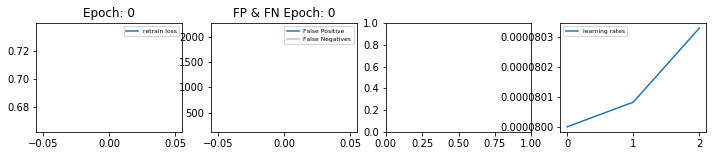

Epoch 1 started.
Retrain dataset size(s): 7774



Epoch 1 completed.
Retrain metrics
_________________________________________ METRICS for epoch 1 _______________________________________________________
accuracy         :0.69038   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.96082   bmark:(0.8974)  sen.beaten:True
specificity      :0.05147   bmark:(0.7601)  spe.beaten:False
mcc              :0.02775   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5248  | fp:2193 |
| fn:214  | tn:119  |
---------------------
Epoch 2 started.
Retrain dataset size(s): 7774



Epoch 2 completed.
Retrain metrics
_________________________________________ METRICS for epoch 2 _______________________________________________________
accuracy         :0.69488   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.96210   bmark:(0.8974)  sen.beaten:True
specificity      :0.06358   bmark:(0.7601)  spe.beaten:False
mcc              :0.05631   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5255  | fp:2165 |
| fn:207  | tn:147  |
---------------------
Epoch 3 started.
Retrain dataset size(s): 7774



Epoch 3 completed.
Retrain metrics
_________________________________________ METRICS for epoch 3 _______________________________________________________
accuracy         :0.69179   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.95588   bmark:(0.8974)  sen.beaten:True
specificity      :0.06791   bmark:(0.7601)  spe.beaten:False
mcc              :0.04933   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5221  | fp:2155 |
| fn:241  | tn:157  |
---------------------
Epoch 4 started.
Retrain dataset size(s): 7774



Epoch 4 completed.
Retrain metrics
_________________________________________ METRICS for epoch 4 _______________________________________________________
accuracy         :0.69372   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.96119   bmark:(0.8974)  sen.beaten:True
specificity      :0.06185   bmark:(0.7601)  spe.beaten:False
mcc              :0.05045   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5250  | fp:2169 |
| fn:212  | tn:143  |
---------------------
Epoch 5 started.
Retrain dataset size(s): 7774



Epoch 5 completed.
Retrain metrics
_________________________________________ METRICS for epoch 5 _______________________________________________________
accuracy         :0.69810   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.96412   bmark:(0.8974)  sen.beaten:True
specificity      :0.06964   bmark:(0.7601)  spe.beaten:False
mcc              :0.07371   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5266  | fp:2151 |
| fn:196  | tn:161  |
---------------------


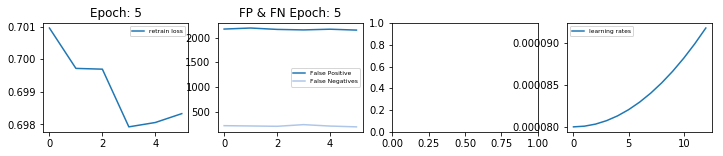

Epoch 6 started.
Retrain dataset size(s): 7774



Epoch 6 completed.
Retrain metrics
_________________________________________ METRICS for epoch 6 _______________________________________________________
accuracy         :0.69076   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.95936   bmark:(0.8974)  sen.beaten:True
specificity      :0.05623   bmark:(0.7601)  spe.beaten:False
mcc              :0.03426   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5240  | fp:2182 |
| fn:222  | tn:130  |
---------------------
Epoch 7 started.
Retrain dataset size(s): 7774



Epoch 7 completed.
Retrain metrics
_________________________________________ METRICS for epoch 7 _______________________________________________________
accuracy         :0.69488   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.96558   bmark:(0.8974)  sen.beaten:True
specificity      :0.05536   bmark:(0.7601)  spe.beaten:False
mcc              :0.04848   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5274  | fp:2184 |
| fn:188  | tn:128  |
---------------------
Epoch 8 started.
Retrain dataset size(s): 7774



Epoch 8 completed.
Retrain metrics
_________________________________________ METRICS for epoch 8 _______________________________________________________
accuracy         :0.69359   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.96082   bmark:(0.8974)  sen.beaten:True
specificity      :0.06228   bmark:(0.7601)  spe.beaten:False
mcc              :0.05039   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5248  | fp:2168 |
| fn:214  | tn:144  |
---------------------
Epoch 9 started.
Retrain dataset size(s): 7774



Epoch 9 completed.
Retrain metrics
_________________________________________ METRICS for epoch 9 _______________________________________________________
accuracy         :0.69874   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.96045   bmark:(0.8974)  sen.beaten:True
specificity      :0.08045   bmark:(0.7601)  spe.beaten:False
mcc              :0.08444   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5246  | fp:2126 |
| fn:216  | tn:186  |
---------------------
Epoch 10 started.
Retrain dataset size(s): 7774



Epoch 10 completed.
Retrain metrics
_________________________________________ METRICS for epoch 10 _______________________________________________________
accuracy         :0.70028   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.96338   bmark:(0.8974)  sen.beaten:True
specificity      :0.07872   bmark:(0.7601)  spe.beaten:False
mcc              :0.08904   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5262  | fp:2130 |
| fn:200  | tn:182  |
---------------------


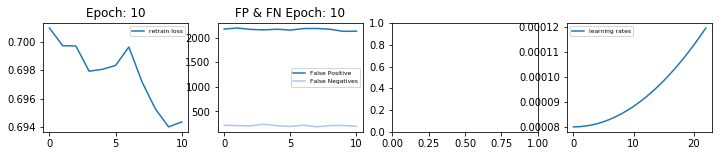

Epoch 11 started.
Retrain dataset size(s): 7774



Epoch 11 completed.
Retrain metrics
_________________________________________ METRICS for epoch 11 _______________________________________________________
accuracy         :0.69655   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.95881   bmark:(0.8974)  sen.beaten:True
specificity      :0.07699   bmark:(0.7601)  spe.beaten:False
mcc              :0.07381   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5237  | fp:2134 |
| fn:225  | tn:178  |
---------------------
Epoch 12 started.
Retrain dataset size(s): 7774



Epoch 12 completed.
Retrain metrics
_________________________________________ METRICS for epoch 12 _______________________________________________________
accuracy         :0.70041   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.96100   bmark:(0.8974)  sen.beaten:True
specificity      :0.08478   bmark:(0.7601)  spe.beaten:False
mcc              :0.09373   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5249  | fp:2116 |
| fn:213  | tn:196  |
---------------------
Epoch 13 started.
Retrain dataset size(s): 7774



Epoch 13 completed.
Retrain metrics
_________________________________________ METRICS for epoch 13 _______________________________________________________
accuracy         :0.69539   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.95643   bmark:(0.8974)  sen.beaten:True
specificity      :0.07872   bmark:(0.7601)  spe.beaten:False
mcc              :0.07107   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5224  | fp:2130 |
| fn:238  | tn:182  |
---------------------
Epoch 14 started.
Retrain dataset size(s): 7774



Epoch 14 completed.
Retrain metrics
_________________________________________ METRICS for epoch 14 _______________________________________________________
accuracy         :0.69848   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.95551   bmark:(0.8974)  sen.beaten:True
specificity      :0.09126   bmark:(0.7601)  spe.beaten:False
mcc              :0.09118   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5219  | fp:2101 |
| fn:243  | tn:211  |
---------------------
Epoch 15 started.
Retrain dataset size(s): 7774



Epoch 15 completed.
Retrain metrics
_________________________________________ METRICS for epoch 15 _______________________________________________________
accuracy         :0.69694   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.95551   bmark:(0.8974)  sen.beaten:True
specificity      :0.08607   bmark:(0.7601)  spe.beaten:False
mcc              :0.08209   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5219  | fp:2113 |
| fn:243  | tn:199  |
---------------------


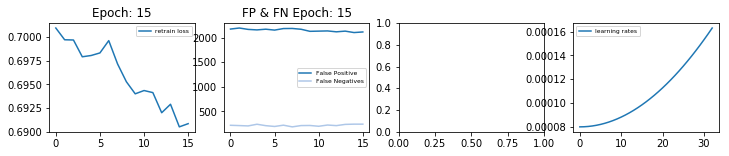

Epoch 16 started.
Retrain dataset size(s): 7774



Epoch 16 completed.
Retrain metrics
_________________________________________ METRICS for epoch 16 _______________________________________________________
accuracy         :0.70015   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.95990   bmark:(0.8974)  sen.beaten:True
specificity      :0.08651   bmark:(0.7601)  spe.beaten:False
mcc              :0.09395   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5243  | fp:2112 |
| fn:219  | tn:200  |
---------------------
Epoch 17 started.
Retrain dataset size(s): 7774



Epoch 17 completed.
Retrain metrics
_________________________________________ METRICS for epoch 17 _______________________________________________________
accuracy         :0.70221   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.95807   bmark:(0.8974)  sen.beaten:True
specificity      :0.09775   bmark:(0.7601)  spe.beaten:False
mcc              :0.10871   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5233  | fp:2086 |
| fn:229  | tn:226  |
---------------------
Epoch 18 started.
Retrain dataset size(s): 7774



Epoch 18 completed.
Retrain metrics
_________________________________________ METRICS for epoch 18 _______________________________________________________
accuracy         :0.70080   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.95862   bmark:(0.8974)  sen.beaten:True
specificity      :0.09170   bmark:(0.7601)  spe.beaten:False
mcc              :0.09975   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5236  | fp:2100 |
| fn:226  | tn:212  |
---------------------
Epoch 19 started.
Retrain dataset size(s): 7774



Epoch 19 completed.
Retrain metrics
_________________________________________ METRICS for epoch 19 _______________________________________________________
accuracy         :0.70311   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.95734   bmark:(0.8974)  sen.beaten:True
specificity      :0.10251   bmark:(0.7601)  spe.beaten:False
mcc              :0.11479   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5229  | fp:2075 |
| fn:233  | tn:237  |
---------------------
Epoch 20 started.
Retrain dataset size(s): 7774



Epoch 20 completed.
Retrain metrics
_________________________________________ METRICS for epoch 20 _______________________________________________________
accuracy         :0.70131   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.95405   bmark:(0.8974)  sen.beaten:True
specificity      :0.10424   bmark:(0.7601)  spe.beaten:False
mcc              :0.10943   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5211  | fp:2071 |
| fn:251  | tn:241  |
---------------------


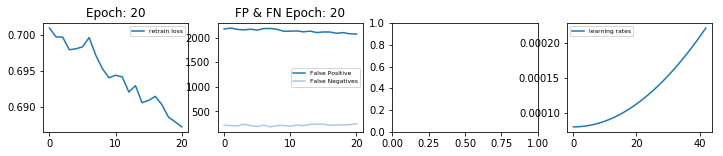

Epoch 21 started.
Retrain dataset size(s): 7774



Epoch 21 completed.
Retrain metrics
_________________________________________ METRICS for epoch 21 _______________________________________________________
accuracy         :0.70466   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.95295   bmark:(0.8974)  sen.beaten:True
specificity      :0.11808   bmark:(0.7601)  spe.beaten:False
mcc              :0.12882   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5205  | fp:2039 |
| fn:257  | tn:273  |
---------------------
Epoch 22 started.
Retrain dataset size(s): 7774



Epoch 22 completed.
Retrain metrics
_________________________________________ METRICS for epoch 22 _______________________________________________________
accuracy         :0.70697   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.95240   bmark:(0.8974)  sen.beaten:True
specificity      :0.12716   bmark:(0.7601)  spe.beaten:False
mcc              :0.14137   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5202  | fp:2018 |
| fn:260  | tn:294  |
---------------------
Epoch 23 started.
Retrain dataset size(s): 7774



Epoch 23 completed.
Retrain metrics
_________________________________________ METRICS for epoch 23 _______________________________________________________
accuracy         :0.71006   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.95038   bmark:(0.8974)  sen.beaten:True
specificity      :0.14230   bmark:(0.7601)  spe.beaten:False
mcc              :0.15875   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5191  | fp:1983 |
| fn:271  | tn:329  |
---------------------
Epoch 24 started.
Retrain dataset size(s): 7774



Epoch 24 completed.
Retrain metrics
_________________________________________ METRICS for epoch 24 _______________________________________________________
accuracy         :0.70980   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.94800   bmark:(0.8974)  sen.beaten:True
specificity      :0.14706   bmark:(0.7601)  spe.beaten:False
mcc              :0.15993   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5178  | fp:1972 |
| fn:284  | tn:340  |
---------------------
Epoch 25 started.
Retrain dataset size(s): 7774



Epoch 25 completed.
Retrain metrics
_________________________________________ METRICS for epoch 25 _______________________________________________________
accuracy         :0.71855   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.94910   bmark:(0.8974)  sen.beaten:True
specificity      :0.17388   bmark:(0.7601)  spe.beaten:False
mcc              :0.19897   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5184  | fp:1910 |
| fn:278  | tn:402  |
---------------------


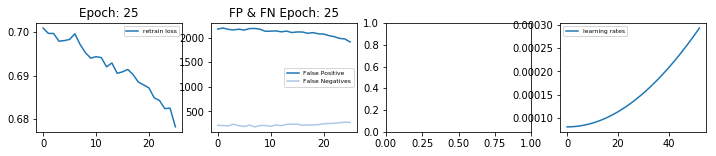

Epoch 26 started.
Retrain dataset size(s): 7774



Epoch 26 completed.
Retrain metrics
_________________________________________ METRICS for epoch 26 _______________________________________________________
accuracy         :0.71636   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.94617   bmark:(0.8974)  sen.beaten:True
specificity      :0.17344   bmark:(0.7601)  spe.beaten:False
mcc              :0.19164   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5168  | fp:1911 |
| fn:294  | tn:401  |
---------------------
Epoch 27 started.
Retrain dataset size(s): 7774



Epoch 27 completed.
Retrain metrics
_________________________________________ METRICS for epoch 27 _______________________________________________________
accuracy         :0.71791   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.94215   bmark:(0.8974)  sen.beaten:True
specificity      :0.18815   bmark:(0.7601)  spe.beaten:False
mcc              :0.20161   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5146  | fp:1877 |
| fn:316  | tn:435  |
---------------------
Epoch 28 started.
Retrain dataset size(s): 7774



Epoch 28 completed.
Retrain metrics
_________________________________________ METRICS for epoch 28 _______________________________________________________
accuracy         :0.71456   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.93226   bmark:(0.8974)  sen.beaten:True
specificity      :0.20026   bmark:(0.7601)  spe.beaten:False
mcc              :0.19585   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5092  | fp:1849 |
| fn:370  | tn:463  |
---------------------
Epoch 29 started.
Retrain dataset size(s): 7774



Epoch 29 completed.
Retrain metrics
_________________________________________ METRICS for epoch 29 _______________________________________________________
accuracy         :0.72511   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.93336   bmark:(0.8974)  sen.beaten:True
specificity      :0.23313   bmark:(0.7601)  spe.beaten:False
mcc              :0.23752   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5098  | fp:1773 |
| fn:364  | tn:539  |
---------------------
Epoch 30 started.
Retrain dataset size(s): 7774



Epoch 30 completed.
Retrain metrics
_________________________________________ METRICS for epoch 30 _______________________________________________________
accuracy         :0.73051   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.92201   bmark:(0.8974)  sen.beaten:True
specificity      :0.27811   bmark:(0.7601)  spe.beaten:False
mcc              :0.26563   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5036  | fp:1669 |
| fn:426  | tn:643  |
---------------------


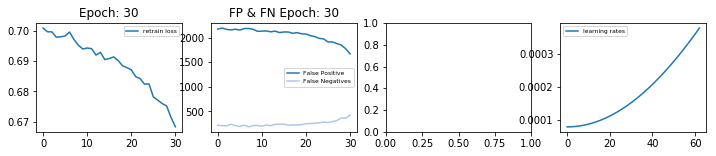

Epoch 31 started.
Retrain dataset size(s): 7774



Epoch 31 completed.
Retrain metrics
_________________________________________ METRICS for epoch 31 _______________________________________________________
accuracy         :0.73334   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.91725   bmark:(0.8974)  sen.beaten:True
specificity      :0.29888   bmark:(0.7601)  spe.beaten:False
mcc              :0.27897   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:5010  | fp:1621 |
| fn:452  | tn:691  |
---------------------
Epoch 32 started.
Retrain dataset size(s): 7774



Epoch 32 completed.
Retrain metrics
_________________________________________ METRICS for epoch 32 _______________________________________________________
accuracy         :0.73630   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.90553   bmark:(0.8974)  sen.beaten:True
specificity      :0.33651   bmark:(0.7601)  spe.beaten:False
mcc              :0.29702   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4946  | fp:1534 |
| fn:516  | tn:778  |
---------------------
Epoch 33 started.
Retrain dataset size(s): 7774



Epoch 33 completed.
Retrain metrics
_________________________________________ METRICS for epoch 33 _______________________________________________________
accuracy         :0.74170   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.89381   bmark:(0.8974)  sen.beaten:False
specificity      :0.38235   bmark:(0.7601)  spe.beaten:False
mcc              :0.32289   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4882  | fp:1428 |
| fn:580  | tn:884  |
---------------------
Epoch 34 started.
Retrain dataset size(s): 7774



Epoch 34 completed.
Retrain metrics
_________________________________________ METRICS for epoch 34 _______________________________________________________
accuracy         :0.73977   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.88136   bmark:(0.8974)  sen.beaten:False
specificity      :0.40528   bmark:(0.7601)  spe.beaten:False
mcc              :0.32522   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4814  | fp:1375 |
| fn:648  | tn:937  |
---------------------
Epoch 35 started.
Retrain dataset size(s): 7774



Epoch 35 completed.
Retrain metrics
_________________________________________ METRICS for epoch 35 _______________________________________________________
accuracy         :0.74029   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.86910   bmark:(0.8974)  sen.beaten:False
specificity      :0.43599   bmark:(0.7601)  spe.beaten:False
mcc              :0.33576   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4747  | fp:1304 |
| fn:715  | tn:1008 |
---------------------


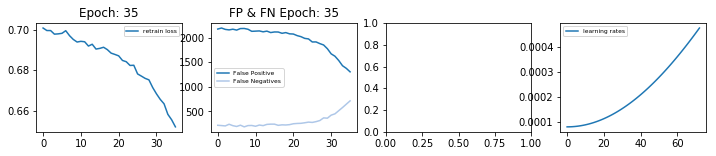

Epoch 36 started.
Retrain dataset size(s): 7774



Epoch 36 completed.
Retrain metrics
_________________________________________ METRICS for epoch 36 _______________________________________________________
accuracy         :0.74595   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.85427   bmark:(0.8974)  sen.beaten:False
specificity      :0.49005   bmark:(0.7601)  spe.beaten:False
mcc              :0.36439   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4666  | fp:1179 |
| fn:796  | tn:1133 |
---------------------
Epoch 37 started.
Retrain dataset size(s): 7774



Epoch 37 completed.
Retrain metrics
_________________________________________ METRICS for epoch 37 _______________________________________________________
accuracy         :0.74723   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.84145   bmark:(0.8974)  sen.beaten:False
specificity      :0.52465   bmark:(0.7601)  spe.beaten:False
mcc              :0.37809   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4596  | fp:1099 |
| fn:866  | tn:1213 |
---------------------
Epoch 38 started.
Retrain dataset size(s): 7774



Epoch 38 completed.
Retrain metrics
_________________________________________ METRICS for epoch 38 _______________________________________________________
accuracy         :0.75701   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.83596   bmark:(0.8974)  sen.beaten:False
specificity      :0.57050   bmark:(0.7601)  spe.beaten:False
mcc              :0.41162   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4566  | fp:993  |
| fn:896  | tn:1319 |
---------------------
Epoch 39 started.
Retrain dataset size(s): 7774



Epoch 39 completed.
Retrain metrics
_________________________________________ METRICS for epoch 39 _______________________________________________________
accuracy         :0.75984   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81893   bmark:(0.8974)  sen.beaten:False
specificity      :0.62024   bmark:(0.7601)  spe.beaten:False
mcc              :0.43342   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4473  | fp:878  |
| fn:989  | tn:1434 |
---------------------
Epoch 40 started.
Retrain dataset size(s): 7774



Epoch 40 completed.
Retrain metrics
_________________________________________ METRICS for epoch 40 _______________________________________________________
accuracy         :0.75637   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.80557   bmark:(0.8974)  sen.beaten:False
specificity      :0.64014   bmark:(0.7601)  spe.beaten:False
mcc              :0.43430   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4400  | fp:832  |
| fn:1062  | tn:1480 |
---------------------


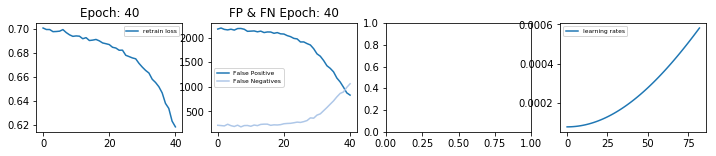

Epoch 41 started.
Retrain dataset size(s): 7774



Epoch 41 completed.
Retrain metrics
_________________________________________ METRICS for epoch 41 _______________________________________________________
accuracy         :0.75405   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.79769   bmark:(0.8974)  sen.beaten:False
specificity      :0.65095   bmark:(0.7601)  spe.beaten:False
mcc              :0.43427   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4357  | fp:807  |
| fn:1105  | tn:1505 |
---------------------
Epoch 42 started.
Retrain dataset size(s): 7774



Epoch 42 completed.
Retrain metrics
_________________________________________ METRICS for epoch 42 _______________________________________________________
accuracy         :0.77232   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.79971   bmark:(0.8974)  sen.beaten:False
specificity      :0.70761   bmark:(0.7601)  spe.beaten:False
mcc              :0.48583   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4368  | fp:676  |
| fn:1094  | tn:1636 |
---------------------
Epoch 43 started.
Retrain dataset size(s): 7774



Epoch 43 completed.
Retrain metrics
_________________________________________ METRICS for epoch 43 _______________________________________________________
accuracy         :0.76228   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.78268   bmark:(0.8974)  sen.beaten:False
specificity      :0.71410   bmark:(0.7601)  spe.beaten:False
mcc              :0.47167   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4275  | fp:661  |
| fn:1187  | tn:1651 |
---------------------
Epoch 44 started.
Retrain dataset size(s): 7774



Epoch 44 completed.
Retrain metrics
_________________________________________ METRICS for epoch 44 _______________________________________________________
accuracy         :0.76306   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.77371   bmark:(0.8974)  sen.beaten:False
specificity      :0.73789   bmark:(0.7601)  spe.beaten:False
mcc              :0.48219   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4226  | fp:606  |
| fn:1236  | tn:1706 |
---------------------
Epoch 45 started.
Retrain dataset size(s): 7774



Epoch 45 completed.
Retrain metrics
_________________________________________ METRICS for epoch 45 _______________________________________________________
accuracy         :0.77077   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.77646   bmark:(0.8974)  sen.beaten:False
specificity      :0.75735   bmark:(0.7601)  spe.beaten:False
mcc              :0.50213   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4241  | fp:561  |
| fn:1221  | tn:1751 |
---------------------


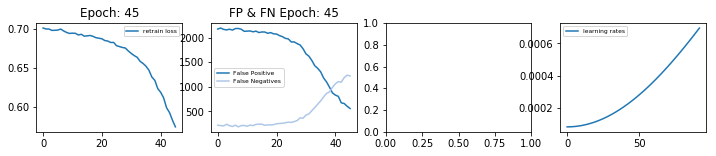

Epoch 46 started.
Retrain dataset size(s): 7774



Epoch 46 completed.
Retrain metrics
_________________________________________ METRICS for epoch 46 _______________________________________________________
accuracy         :0.76910   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.77188   bmark:(0.8974)  sen.beaten:False
specificity      :0.76254   bmark:(0.7601)  spe.beaten:True
mcc              :0.50155   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4216  | fp:549  |
| fn:1246  | tn:1763 |
---------------------
Epoch 47 started.
Retrain dataset size(s): 7774



Epoch 47 completed.
Retrain metrics
_________________________________________ METRICS for epoch 47 _______________________________________________________
accuracy         :0.77129   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.77224   bmark:(0.8974)  sen.beaten:False
specificity      :0.76903   bmark:(0.7601)  spe.beaten:True
mcc              :0.50758   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4218  | fp:534  |
| fn:1244  | tn:1778 |
---------------------
Epoch 48 started.
Retrain dataset size(s): 7774



Epoch 48 completed.
Retrain metrics
_________________________________________ METRICS for epoch 48 _______________________________________________________
accuracy         :0.77836   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.77554   bmark:(0.8974)  sen.beaten:False
specificity      :0.78503   bmark:(0.7601)  spe.beaten:True
mcc              :0.52508   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4236  | fp:497  |
| fn:1226  | tn:1815 |
---------------------
Epoch 49 started.
Retrain dataset size(s): 7774



Epoch 49 completed.
Retrain metrics
_________________________________________ METRICS for epoch 49 _______________________________________________________
accuracy         :0.78222   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.77517   bmark:(0.8974)  sen.beaten:False
specificity      :0.79888   bmark:(0.7601)  spe.beaten:True
mcc              :0.53665   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4234  | fp:465  |
| fn:1228  | tn:1847 |
---------------------
Epoch 50 started.
Retrain dataset size(s): 7774



Epoch 50 completed.
Retrain metrics
_________________________________________ METRICS for epoch 50 _______________________________________________________
accuracy         :0.78737   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.78689   bmark:(0.8974)  sen.beaten:False
specificity      :0.78849   bmark:(0.7601)  spe.beaten:True
mcc              :0.54073   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4298  | fp:489  |
| fn:1164  | tn:1823 |
---------------------


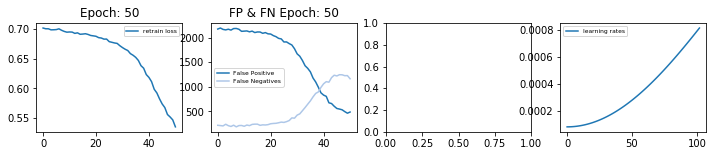

Epoch 51 started.
Retrain dataset size(s): 7774



Epoch 51 completed.
Retrain metrics
_________________________________________ METRICS for epoch 51 _______________________________________________________
accuracy         :0.79380   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.78927   bmark:(0.8974)  sen.beaten:False
specificity      :0.80450   bmark:(0.7601)  spe.beaten:True
mcc              :0.55718   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4311  | fp:452  |
| fn:1151  | tn:1860 |
---------------------
Epoch 52 started.
Retrain dataset size(s): 7774



Epoch 52 completed.
Retrain metrics
_________________________________________ METRICS for epoch 52 _______________________________________________________
accuracy         :0.79882   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.79641   bmark:(0.8974)  sen.beaten:False
specificity      :0.80450   bmark:(0.7601)  spe.beaten:True
mcc              :0.56525   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4350  | fp:452  |
| fn:1112  | tn:1860 |
---------------------
Epoch 53 started.
Retrain dataset size(s): 7774



Epoch 53 completed.
Retrain metrics
_________________________________________ METRICS for epoch 53 _______________________________________________________
accuracy         :0.80332   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.80282   bmark:(0.8974)  sen.beaten:False
specificity      :0.80450   bmark:(0.7601)  spe.beaten:True
mcc              :0.57259   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4385  | fp:452  |
| fn:1077  | tn:1860 |
---------------------
Epoch 54 started.
Retrain dataset size(s): 7774



Epoch 54 completed.
Retrain metrics
_________________________________________ METRICS for epoch 54 _______________________________________________________
accuracy         :0.80293   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.80154   bmark:(0.8974)  sen.beaten:False
specificity      :0.80623   bmark:(0.7601)  spe.beaten:True
mcc              :0.57260   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4378  | fp:448  |
| fn:1084  | tn:1864 |
---------------------
Epoch 55 started.
Retrain dataset size(s): 7774



Epoch 55 completed.
Retrain metrics
_________________________________________ METRICS for epoch 55 _______________________________________________________
accuracy         :0.80306   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.80575   bmark:(0.8974)  sen.beaten:False
specificity      :0.79671   bmark:(0.7601)  spe.beaten:True
mcc              :0.56933   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4401  | fp:470  |
| fn:1061  | tn:1842 |
---------------------


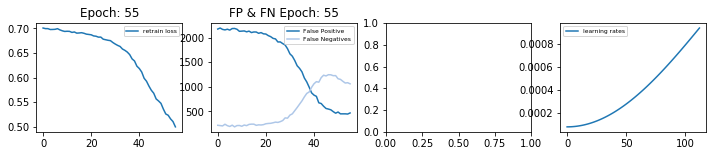

Epoch 56 started.
Retrain dataset size(s): 7774



Epoch 56 completed.
Retrain metrics
_________________________________________ METRICS for epoch 56 _______________________________________________________
accuracy         :0.80859   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81088   bmark:(0.8974)  sen.beaten:False
specificity      :0.80320   bmark:(0.7601)  spe.beaten:True
mcc              :0.58084   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4429  | fp:455  |
| fn:1033  | tn:1857 |
---------------------
Epoch 57 started.
Retrain dataset size(s): 7774



Epoch 57 completed.
Retrain metrics
_________________________________________ METRICS for epoch 57 _______________________________________________________
accuracy         :0.80744   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.80557   bmark:(0.8974)  sen.beaten:False
specificity      :0.81185   bmark:(0.7601)  spe.beaten:True
mcc              :0.58204   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4400  | fp:435  |
| fn:1062  | tn:1877 |
---------------------
Epoch 58 started.
Retrain dataset size(s): 7774



Epoch 58 completed.
Retrain metrics
_________________________________________ METRICS for epoch 58 _______________________________________________________
accuracy         :0.81168   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.80996   bmark:(0.8974)  sen.beaten:False
specificity      :0.81574   bmark:(0.7601)  spe.beaten:True
mcc              :0.59044   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4424  | fp:426  |
| fn:1038  | tn:1886 |
---------------------
Epoch 59 started.
Retrain dataset size(s): 7774



Epoch 59 completed.
Retrain metrics
_________________________________________ METRICS for epoch 59 _______________________________________________________
accuracy         :0.81515   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81124   bmark:(0.8974)  sen.beaten:False
specificity      :0.82439   bmark:(0.7601)  spe.beaten:True
mcc              :0.59929   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4431  | fp:406  |
| fn:1031  | tn:1906 |
---------------------
Epoch 60 started.
Retrain dataset size(s): 7774



Epoch 60 completed.
Retrain metrics
_________________________________________ METRICS for epoch 60 _______________________________________________________
accuracy         :0.81425   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81307   bmark:(0.8974)  sen.beaten:False
specificity      :0.81704   bmark:(0.7601)  spe.beaten:True
mcc              :0.59518   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4441  | fp:423  |
| fn:1021  | tn:1889 |
---------------------


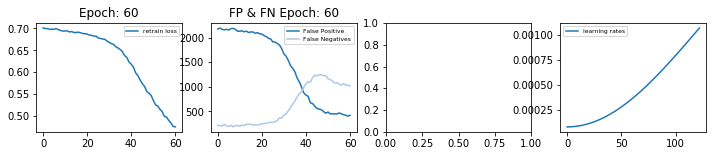

Epoch 61 started.
Retrain dataset size(s): 7774



Epoch 61 completed.
Retrain metrics
_________________________________________ METRICS for epoch 61 _______________________________________________________
accuracy         :0.82120   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81417   bmark:(0.8974)  sen.beaten:False
specificity      :0.83780   bmark:(0.7601)  spe.beaten:True
mcc              :0.61408   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4447  | fp:375  |
| fn:1015  | tn:1937 |
---------------------
Epoch 62 started.
Retrain dataset size(s): 7774



Epoch 62 completed.
Retrain metrics
_________________________________________ METRICS for epoch 62 _______________________________________________________
accuracy         :0.81708   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81106   bmark:(0.8974)  sen.beaten:False
specificity      :0.83131   bmark:(0.7601)  spe.beaten:True
mcc              :0.60496   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4430  | fp:390  |
| fn:1032  | tn:1922 |
---------------------
Epoch 63 started.
Retrain dataset size(s): 7774



Epoch 63 completed.
Retrain metrics
_________________________________________ METRICS for epoch 63 _______________________________________________________
accuracy         :0.81953   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81637   bmark:(0.8974)  sen.beaten:False
specificity      :0.82699   bmark:(0.7601)  spe.beaten:True
mcc              :0.60748   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4459  | fp:400  |
| fn:1003  | tn:1912 |
---------------------
Epoch 64 started.
Retrain dataset size(s): 7774



Epoch 64 completed.
Retrain metrics
_________________________________________ METRICS for epoch 64 _______________________________________________________
accuracy         :0.82261   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81765   bmark:(0.8974)  sen.beaten:False
specificity      :0.83434   bmark:(0.7601)  spe.beaten:True
mcc              :0.61521   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4466  | fp:383  |
| fn:996  | tn:1929 |
---------------------
Epoch 65 started.
Retrain dataset size(s): 7774



Epoch 65 completed.
Retrain metrics
_________________________________________ METRICS for epoch 65 _______________________________________________________
accuracy         :0.82313   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82186   bmark:(0.8974)  sen.beaten:False
specificity      :0.82612   bmark:(0.7601)  spe.beaten:True
mcc              :0.61322   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4489  | fp:402  |
| fn:973  | tn:1910 |
---------------------


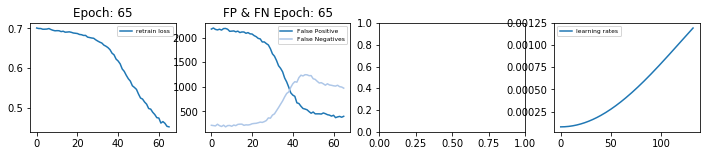

Epoch 66 started.
Retrain dataset size(s): 7774



Epoch 66 completed.
Retrain metrics
_________________________________________ METRICS for epoch 66 _______________________________________________________
accuracy         :0.82596   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82149   bmark:(0.8974)  sen.beaten:False
specificity      :0.83651   bmark:(0.7601)  spe.beaten:True
mcc              :0.62156   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4487  | fp:378  |
| fn:975  | tn:1934 |
---------------------
Epoch 67 started.
Retrain dataset size(s): 7774



Epoch 67 completed.
Retrain metrics
_________________________________________ METRICS for epoch 67 _______________________________________________________
accuracy         :0.82416   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82003   bmark:(0.8974)  sen.beaten:False
specificity      :0.83391   bmark:(0.7601)  spe.beaten:True
mcc              :0.61764   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4479  | fp:384  |
| fn:983  | tn:1928 |
---------------------
Epoch 68 started.
Retrain dataset size(s): 7774



Epoch 68 completed.
Retrain metrics
_________________________________________ METRICS for epoch 68 _______________________________________________________
accuracy         :0.82827   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82094   bmark:(0.8974)  sen.beaten:False
specificity      :0.84559   bmark:(0.7601)  spe.beaten:True
mcc              :0.62859   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4484  | fp:357  |
| fn:978  | tn:1955 |
---------------------
Epoch 69 started.
Retrain dataset size(s): 7774



Epoch 69 completed.
Retrain metrics
_________________________________________ METRICS for epoch 69 _______________________________________________________
accuracy         :0.82866   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82278   bmark:(0.8974)  sen.beaten:False
specificity      :0.84256   bmark:(0.7601)  spe.beaten:True
mcc              :0.62819   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4494  | fp:364  |
| fn:968  | tn:1948 |
---------------------
Epoch 70 started.
Retrain dataset size(s): 7774



Epoch 70 completed.
Retrain metrics
_________________________________________ METRICS for epoch 70 _______________________________________________________
accuracy         :0.82339   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81692   bmark:(0.8974)  sen.beaten:False
specificity      :0.83867   bmark:(0.7601)  spe.beaten:True
mcc              :0.61802   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4462  | fp:373  |
| fn:1000  | tn:1939 |
---------------------


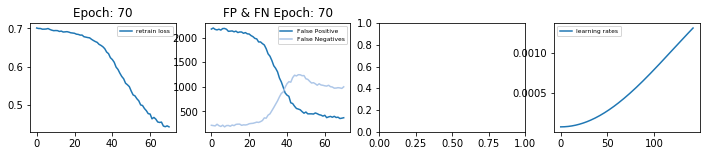

Epoch 71 started.
Retrain dataset size(s): 7774



Epoch 71 completed.
Retrain metrics
_________________________________________ METRICS for epoch 71 _______________________________________________________
accuracy         :0.82917   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82259   bmark:(0.8974)  sen.beaten:False
specificity      :0.84472   bmark:(0.7601)  spe.beaten:True
mcc              :0.62980   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4493  | fp:359  |
| fn:969  | tn:1953 |
---------------------
Epoch 72 started.
Retrain dataset size(s): 7774



Epoch 72 completed.
Retrain metrics
_________________________________________ METRICS for epoch 72 _______________________________________________________
accuracy         :0.83123   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82534   bmark:(0.8974)  sen.beaten:False
specificity      :0.84516   bmark:(0.7601)  spe.beaten:True
mcc              :0.63341   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4508  | fp:358  |
| fn:954  | tn:1954 |
---------------------
Epoch 73 started.
Retrain dataset size(s): 7774



Epoch 73 completed.
Retrain metrics
_________________________________________ METRICS for epoch 73 _______________________________________________________
accuracy         :0.82866   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82223   bmark:(0.8974)  sen.beaten:False
specificity      :0.84386   bmark:(0.7601)  spe.beaten:True
mcc              :0.62863   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4491  | fp:361  |
| fn:971  | tn:1951 |
---------------------
Epoch 74 started.
Retrain dataset size(s): 7774



Epoch 74 completed.
Retrain metrics
_________________________________________ METRICS for epoch 74 _______________________________________________________
accuracy         :0.82969   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82406   bmark:(0.8974)  sen.beaten:False
specificity      :0.84299   bmark:(0.7601)  spe.beaten:True
mcc              :0.63006   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4501  | fp:363  |
| fn:961  | tn:1949 |
---------------------
Epoch 75 started.
Retrain dataset size(s): 7774



Epoch 75 completed.
Retrain metrics
_________________________________________ METRICS for epoch 75 _______________________________________________________
accuracy         :0.82956   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82369   bmark:(0.8974)  sen.beaten:False
specificity      :0.84343   bmark:(0.7601)  spe.beaten:True
mcc              :0.63000   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4499  | fp:362  |
| fn:963  | tn:1950 |
---------------------


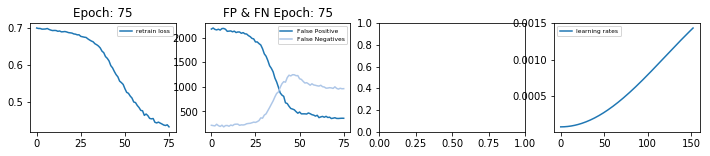

Epoch 76 started.
Retrain dataset size(s): 7774



Epoch 76 completed.
Retrain metrics
_________________________________________ METRICS for epoch 76 _______________________________________________________
accuracy         :0.83046   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82699   bmark:(0.8974)  sen.beaten:False
specificity      :0.83867   bmark:(0.7601)  spe.beaten:True
mcc              :0.62989   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4517  | fp:373  |
| fn:945  | tn:1939 |
---------------------
Epoch 77 started.
Retrain dataset size(s): 7774



Epoch 77 completed.
Retrain metrics
_________________________________________ METRICS for epoch 77 _______________________________________________________
accuracy         :0.83007   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82204   bmark:(0.8974)  sen.beaten:False
specificity      :0.84905   bmark:(0.7601)  spe.beaten:True
mcc              :0.63280   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4490  | fp:349  |
| fn:972  | tn:1963 |
---------------------
Epoch 78 started.
Retrain dataset size(s): 7774



Epoch 78 completed.
Retrain metrics
_________________________________________ METRICS for epoch 78 _______________________________________________________
accuracy         :0.82673   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82040   bmark:(0.8974)  sen.beaten:False
specificity      :0.84170   bmark:(0.7601)  spe.beaten:True
mcc              :0.62465   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4481  | fp:366  |
| fn:981  | tn:1946 |
---------------------
Epoch 79 started.
Retrain dataset size(s): 7774



Epoch 79 completed.
Retrain metrics
_________________________________________ METRICS for epoch 79 _______________________________________________________
accuracy         :0.83188   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82040   bmark:(0.8974)  sen.beaten:False
specificity      :0.85900   bmark:(0.7601)  spe.beaten:True
mcc              :0.63928   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4481  | fp:326  |
| fn:981  | tn:1986 |
---------------------
Epoch 80 started.
Retrain dataset size(s): 7774



Epoch 80 completed.
Retrain metrics
_________________________________________ METRICS for epoch 80 _______________________________________________________
accuracy         :0.83599   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.83211   bmark:(0.8974)  sen.beaten:False
specificity      :0.84516   bmark:(0.7601)  spe.beaten:True
mcc              :0.64148   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4545  | fp:358  |
| fn:917  | tn:1954 |
---------------------


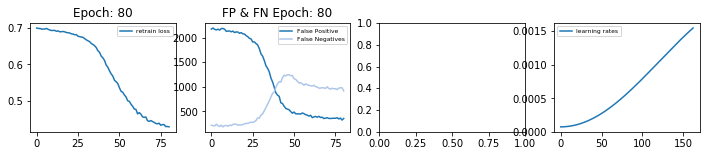

Epoch 81 started.
Retrain dataset size(s): 7774



Epoch 81 completed.
Retrain metrics
_________________________________________ METRICS for epoch 81 _______________________________________________________
accuracy         :0.83535   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82589   bmark:(0.8974)  sen.beaten:False
specificity      :0.85770   bmark:(0.7601)  spe.beaten:True
mcc              :0.64463   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4511  | fp:329  |
| fn:951  | tn:1983 |
---------------------
Epoch 82 started.
Retrain dataset size(s): 7774



Epoch 82 completed.
Retrain metrics
_________________________________________ METRICS for epoch 82 _______________________________________________________
accuracy         :0.82956   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82040   bmark:(0.8974)  sen.beaten:False
specificity      :0.85121   bmark:(0.7601)  spe.beaten:True
mcc              :0.63270   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4481  | fp:344  |
| fn:981  | tn:1968 |
---------------------
Epoch 83 started.
Retrain dataset size(s): 7774



Epoch 83 completed.
Retrain metrics
_________________________________________ METRICS for epoch 83 _______________________________________________________
accuracy         :0.82917   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81911   bmark:(0.8974)  sen.beaten:False
specificity      :0.85294   bmark:(0.7601)  spe.beaten:True
mcc              :0.63267   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4474  | fp:340  |
| fn:988  | tn:1972 |
---------------------
Epoch 84 started.
Retrain dataset size(s): 7774



Epoch 84 completed.
Retrain metrics
_________________________________________ METRICS for epoch 84 _______________________________________________________
accuracy         :0.83072   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82223   bmark:(0.8974)  sen.beaten:False
specificity      :0.85078   bmark:(0.7601)  spe.beaten:True
mcc              :0.63448   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4491  | fp:345  |
| fn:971  | tn:1967 |
---------------------
Epoch 85 started.
Retrain dataset size(s): 7774



Epoch 85 completed.
Retrain metrics
_________________________________________ METRICS for epoch 85 _______________________________________________________
accuracy         :0.83303   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82497   bmark:(0.8974)  sen.beaten:False
specificity      :0.85208   bmark:(0.7601)  spe.beaten:True
mcc              :0.63881   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4506  | fp:342  |
| fn:956  | tn:1970 |
---------------------


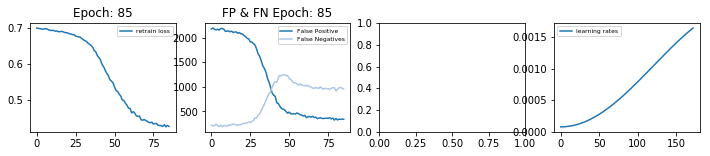

Epoch 86 started.
Retrain dataset size(s): 7774



Epoch 86 completed.
Retrain metrics
_________________________________________ METRICS for epoch 86 _______________________________________________________
accuracy         :0.83316   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82680   bmark:(0.8974)  sen.beaten:False
specificity      :0.84818   bmark:(0.7601)  spe.beaten:True
mcc              :0.63769   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4516  | fp:351  |
| fn:946  | tn:1961 |
---------------------
Epoch 87 started.
Retrain dataset size(s): 7774



Epoch 87 completed.
Retrain metrics
_________________________________________ METRICS for epoch 87 _______________________________________________________
accuracy         :0.83522   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82479   bmark:(0.8974)  sen.beaten:False
specificity      :0.85986   bmark:(0.7601)  spe.beaten:True
mcc              :0.64516   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4505  | fp:324  |
| fn:957  | tn:1988 |
---------------------
Epoch 88 started.
Retrain dataset size(s): 7774



Epoch 88 completed.
Retrain metrics
_________________________________________ METRICS for epoch 88 _______________________________________________________
accuracy         :0.82737   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81765   bmark:(0.8974)  sen.beaten:False
specificity      :0.85035   bmark:(0.7601)  spe.beaten:True
mcc              :0.62876   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4466  | fp:346  |
| fn:996  | tn:1966 |
---------------------
Epoch 89 started.
Retrain dataset size(s): 7774



Epoch 89 completed.
Retrain metrics
_________________________________________ METRICS for epoch 89 _______________________________________________________
accuracy         :0.83162   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82186   bmark:(0.8974)  sen.beaten:False
specificity      :0.85467   bmark:(0.7601)  spe.beaten:True
mcc              :0.63734   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4489  | fp:336  |
| fn:973  | tn:1976 |
---------------------
Epoch 90 started.
Retrain dataset size(s): 7774



Epoch 90 completed.
Retrain metrics
_________________________________________ METRICS for epoch 90 _______________________________________________________
accuracy         :0.83406   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82790   bmark:(0.8974)  sen.beaten:False
specificity      :0.84862   bmark:(0.7601)  spe.beaten:True
mcc              :0.63936   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4522  | fp:350  |
| fn:940  | tn:1962 |
---------------------


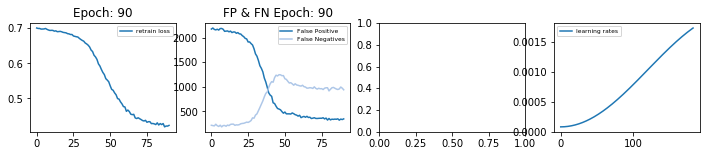

Epoch 91 started.
Retrain dataset size(s): 7774



Epoch 91 completed.
Retrain metrics
_________________________________________ METRICS for epoch 91 _______________________________________________________
accuracy         :0.83638   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.83047   bmark:(0.8974)  sen.beaten:False
specificity      :0.85035   bmark:(0.7601)  spe.beaten:True
mcc              :0.64387   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4536  | fp:346  |
| fn:926  | tn:1966 |
---------------------
Epoch 92 started.
Retrain dataset size(s): 7774



Epoch 92 completed.
Retrain metrics
_________________________________________ METRICS for epoch 92 _______________________________________________________
accuracy         :0.83162   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82369   bmark:(0.8974)  sen.beaten:False
specificity      :0.85035   bmark:(0.7601)  spe.beaten:True
mcc              :0.63584   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4499  | fp:346  |
| fn:963  | tn:1966 |
---------------------
Epoch 93 started.
Retrain dataset size(s): 7774



Epoch 93 completed.
Retrain metrics
_________________________________________ METRICS for epoch 93 _______________________________________________________
accuracy         :0.83535   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.83047   bmark:(0.8974)  sen.beaten:False
specificity      :0.84689   bmark:(0.7601)  spe.beaten:True
mcc              :0.64096   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4536  | fp:354  |
| fn:926  | tn:1958 |
---------------------
Epoch 94 started.
Retrain dataset size(s): 7774



Epoch 94 completed.
Retrain metrics
_________________________________________ METRICS for epoch 94 _______________________________________________________
accuracy         :0.83496   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82845   bmark:(0.8974)  sen.beaten:False
specificity      :0.85035   bmark:(0.7601)  spe.beaten:True
mcc              :0.64147   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4525  | fp:346  |
| fn:937  | tn:1966 |
---------------------
Epoch 95 started.
Retrain dataset size(s): 7774



Epoch 95 completed.
Retrain metrics
_________________________________________ METRICS for epoch 95 _______________________________________________________
accuracy         :0.83072   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82186   bmark:(0.8974)  sen.beaten:False
specificity      :0.85164   bmark:(0.7601)  spe.beaten:True
mcc              :0.63478   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4489  | fp:343  |
| fn:973  | tn:1969 |
---------------------


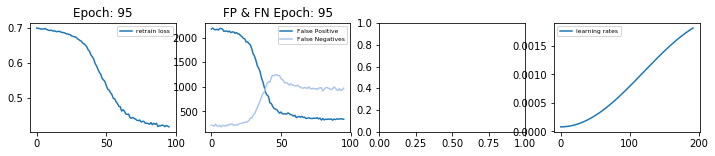

Epoch 96 started.
Retrain dataset size(s): 7774



Epoch 96 completed.
Retrain metrics
_________________________________________ METRICS for epoch 96 _______________________________________________________
accuracy         :0.83393   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82808   bmark:(0.8974)  sen.beaten:False
specificity      :0.84775   bmark:(0.7601)  spe.beaten:True
mcc              :0.63885   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4523  | fp:352  |
| fn:939  | tn:1960 |
---------------------
Epoch 97 started.
Retrain dataset size(s): 7774



Epoch 97 completed.
Retrain metrics
_________________________________________ METRICS for epoch 97 _______________________________________________________
accuracy         :0.83766   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82845   bmark:(0.8974)  sen.beaten:False
specificity      :0.85943   bmark:(0.7601)  spe.beaten:True
mcc              :0.64912   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4525  | fp:325  |
| fn:937  | tn:1987 |
---------------------
Epoch 98 started.
Retrain dataset size(s): 7774



Epoch 98 completed.
Retrain metrics
_________________________________________ METRICS for epoch 98 _______________________________________________________
accuracy         :0.83548   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82589   bmark:(0.8974)  sen.beaten:False
specificity      :0.85813   bmark:(0.7601)  spe.beaten:True
mcc              :0.64499   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4511  | fp:328  |
| fn:951  | tn:1984 |
---------------------
Epoch 99 started.
Retrain dataset size(s): 7774



Epoch 99 completed.
Retrain metrics
_________________________________________ METRICS for epoch 99 _______________________________________________________
accuracy         :0.83329   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82461   bmark:(0.8974)  sen.beaten:False
specificity      :0.85381   bmark:(0.7601)  spe.beaten:True
mcc              :0.63984   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4504  | fp:338  |
| fn:958  | tn:1974 |
---------------------
Epoch 100 started.
Retrain dataset size(s): 7774



Epoch 100 completed.
Retrain metrics
_________________________________________ METRICS for epoch 100 _______________________________________________________
accuracy         :0.83123   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82314   bmark:(0.8974)  sen.beaten:False
specificity      :0.85035   bmark:(0.7601)  spe.beaten:True
mcc              :0.63519   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4496  | fp:346  |
| fn:966  | tn:1966 |
---------------------


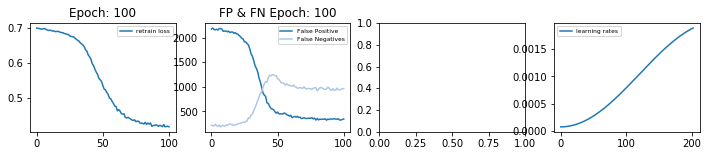

Epoch 101 started.
Retrain dataset size(s): 7774



Epoch 101 completed.
Retrain metrics
_________________________________________ METRICS for epoch 101 _______________________________________________________
accuracy         :0.83548   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82552   bmark:(0.8974)  sen.beaten:False
specificity      :0.85900   bmark:(0.7601)  spe.beaten:True
mcc              :0.64529   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4509  | fp:326  |
| fn:953  | tn:1986 |
---------------------
Epoch 102 started.
Retrain dataset size(s): 7774



Epoch 102 completed.
Retrain metrics
_________________________________________ METRICS for epoch 102 _______________________________________________________
accuracy         :0.83136   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82369   bmark:(0.8974)  sen.beaten:False
specificity      :0.84948   bmark:(0.7601)  spe.beaten:True
mcc              :0.63511   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4499  | fp:348  |
| fn:963  | tn:1964 |
---------------------
Epoch 103 started.
Retrain dataset size(s): 7774



Epoch 103 completed.
Retrain metrics
_________________________________________ METRICS for epoch 103 _______________________________________________________
accuracy         :0.83625   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82479   bmark:(0.8974)  sen.beaten:False
specificity      :0.86332   bmark:(0.7601)  spe.beaten:True
mcc              :0.64808   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4505  | fp:316  |
| fn:957  | tn:1996 |
---------------------
Epoch 104 started.
Retrain dataset size(s): 7774



Epoch 104 completed.
Retrain metrics
_________________________________________ METRICS for epoch 104 _______________________________________________________
accuracy         :0.83663   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82644   bmark:(0.8974)  sen.beaten:False
specificity      :0.86073   bmark:(0.7601)  spe.beaten:True
mcc              :0.64783   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4514  | fp:322  |
| fn:948  | tn:1990 |
---------------------
Epoch 105 started.
Retrain dataset size(s): 7774



Epoch 105 completed.
Retrain metrics
_________________________________________ METRICS for epoch 105 _______________________________________________________
accuracy         :0.83586   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82827   bmark:(0.8974)  sen.beaten:False
specificity      :0.85381   bmark:(0.7601)  spe.beaten:True
mcc              :0.64417   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4524  | fp:338  |
| fn:938  | tn:1974 |
---------------------


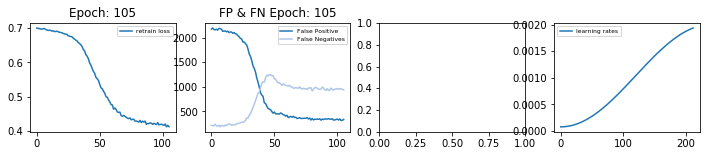

Epoch 106 started.
Retrain dataset size(s): 7774



Epoch 106 completed.
Retrain metrics
_________________________________________ METRICS for epoch 106 _______________________________________________________
accuracy         :0.83406   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.83065   bmark:(0.8974)  sen.beaten:False
specificity      :0.84213   bmark:(0.7601)  spe.beaten:True
mcc              :0.63718   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4537  | fp:365  |
| fn:925  | tn:1947 |
---------------------
Epoch 107 started.
Retrain dataset size(s): 7774



Epoch 107 completed.
Retrain metrics
_________________________________________ METRICS for epoch 107 _______________________________________________________
accuracy         :0.83663   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82900   bmark:(0.8974)  sen.beaten:False
specificity      :0.85467   bmark:(0.7601)  spe.beaten:True
mcc              :0.64576   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4528  | fp:336  |
| fn:934  | tn:1976 |
---------------------
Epoch 108 started.
Retrain dataset size(s): 7774



Epoch 108 completed.
Retrain metrics
_________________________________________ METRICS for epoch 108 _______________________________________________________
accuracy         :0.83831   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.83230   bmark:(0.8974)  sen.beaten:False
specificity      :0.85251   bmark:(0.7601)  spe.beaten:True
mcc              :0.64788   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4546  | fp:341  |
| fn:916  | tn:1971 |
---------------------
Epoch 109 started.
Retrain dataset size(s): 7774



Epoch 109 completed.
Retrain metrics
_________________________________________ METRICS for epoch 109 _______________________________________________________
accuracy         :0.83059   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82076   bmark:(0.8974)  sen.beaten:False
specificity      :0.85381   bmark:(0.7601)  spe.beaten:True
mcc              :0.63532   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4483  | fp:338  |
| fn:979  | tn:1974 |
---------------------
Epoch 110 started.
Retrain dataset size(s): 7774



Epoch 110 completed.
Retrain metrics
_________________________________________ METRICS for epoch 110 _______________________________________________________
accuracy         :0.83496   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82387   bmark:(0.8974)  sen.beaten:False
specificity      :0.86116   bmark:(0.7601)  spe.beaten:True
mcc              :0.64518   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4500  | fp:321  |
| fn:962  | tn:1991 |
---------------------


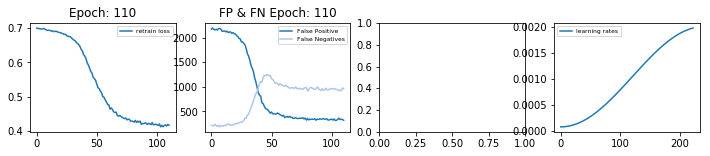

Epoch 111 started.
Retrain dataset size(s): 7774



Epoch 111 completed.
Retrain metrics
_________________________________________ METRICS for epoch 111 _______________________________________________________
accuracy         :0.83368   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82772   bmark:(0.8974)  sen.beaten:False
specificity      :0.84775   bmark:(0.7601)  spe.beaten:True
mcc              :0.63842   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4521  | fp:352  |
| fn:941  | tn:1960 |
---------------------
Epoch 112 started.
Retrain dataset size(s): 7774



Epoch 112 completed.
Retrain metrics
_________________________________________ METRICS for epoch 112 _______________________________________________________
accuracy         :0.83406   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82516   bmark:(0.8974)  sen.beaten:False
specificity      :0.85510   bmark:(0.7601)  spe.beaten:True
mcc              :0.64158   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4507  | fp:335  |
| fn:955  | tn:1977 |
---------------------
Epoch 113 started.
Retrain dataset size(s): 7774



Epoch 113 completed.
Retrain metrics
_________________________________________ METRICS for epoch 113 _______________________________________________________
accuracy         :0.83380   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82076   bmark:(0.8974)  sen.beaten:False
specificity      :0.86462   bmark:(0.7601)  spe.beaten:True
mcc              :0.64447   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4483  | fp:313  |
| fn:979  | tn:1999 |
---------------------
Epoch 114 started.
Retrain dataset size(s): 7774



Epoch 114 completed.
Retrain metrics
_________________________________________ METRICS for epoch 114 _______________________________________________________
accuracy         :0.83393   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82461   bmark:(0.8974)  sen.beaten:False
specificity      :0.85597   bmark:(0.7601)  spe.beaten:True
mcc              :0.64166   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4504  | fp:333  |
| fn:958  | tn:1979 |
---------------------
Epoch 115 started.
Retrain dataset size(s): 7774



Epoch 115 completed.
Retrain metrics
_________________________________________ METRICS for epoch 115 _______________________________________________________
accuracy         :0.83818   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.83358   bmark:(0.8974)  sen.beaten:False
specificity      :0.84905   bmark:(0.7601)  spe.beaten:True
mcc              :0.64651   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4553  | fp:349  |
| fn:909  | tn:1963 |
---------------------


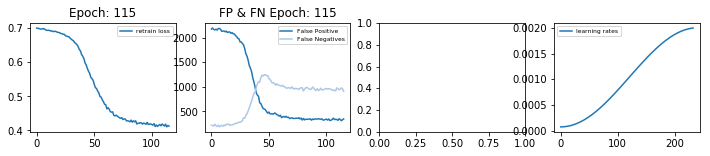

Epoch 116 started.
Retrain dataset size(s): 7774



Epoch 116 completed.
Retrain metrics
_________________________________________ METRICS for epoch 116 _______________________________________________________
accuracy         :0.83445   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82699   bmark:(0.8974)  sen.beaten:False
specificity      :0.85208   bmark:(0.7601)  spe.beaten:True
mcc              :0.64119   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4517  | fp:342  |
| fn:945  | tn:1970 |
---------------------
Epoch 117 started.
Retrain dataset size(s): 7774



Epoch 117 completed.
Retrain metrics
_________________________________________ METRICS for epoch 117 _______________________________________________________
accuracy         :0.83226   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82278   bmark:(0.8974)  sen.beaten:False
specificity      :0.85467   bmark:(0.7601)  spe.beaten:True
mcc              :0.63841   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4494  | fp:336  |
| fn:968  | tn:1976 |
---------------------
Epoch 118 started.
Retrain dataset size(s): 7774



Epoch 118 completed.
Retrain metrics
_________________________________________ METRICS for epoch 118 _______________________________________________________
accuracy         :0.83676   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82387   bmark:(0.8974)  sen.beaten:False
specificity      :0.86721   bmark:(0.7601)  spe.beaten:True
mcc              :0.65029   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4500  | fp:307  |
| fn:962  | tn:2005 |
---------------------
Epoch 119 started.
Retrain dataset size(s): 7774



Epoch 119 completed.
Retrain metrics
_________________________________________ METRICS for epoch 119 _______________________________________________________
accuracy         :0.83663   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82644   bmark:(0.8974)  sen.beaten:False
specificity      :0.86073   bmark:(0.7601)  spe.beaten:True
mcc              :0.64783   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4514  | fp:322  |
| fn:948  | tn:1990 |
---------------------
Epoch 120 started.
Retrain dataset size(s): 7774



Epoch 120 completed.
Retrain metrics
_________________________________________ METRICS for epoch 120 _______________________________________________________
accuracy         :0.83702   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.83010   bmark:(0.8974)  sen.beaten:False
specificity      :0.85337   bmark:(0.7601)  spe.beaten:True
mcc              :0.64598   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4534  | fp:339  |
| fn:928  | tn:1973 |
---------------------


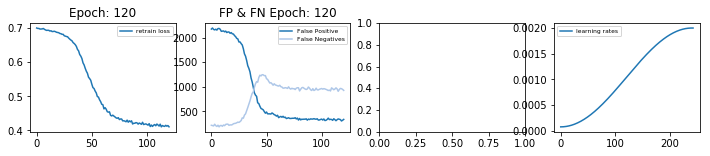

Epoch 121 started.
Retrain dataset size(s): 7774



Epoch 121 completed.
Retrain metrics
_________________________________________ METRICS for epoch 121 _______________________________________________________
accuracy         :0.83213   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82168   bmark:(0.8974)  sen.beaten:False
specificity      :0.85683   bmark:(0.7601)  spe.beaten:True
mcc              :0.63895   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4488  | fp:331  |
| fn:974  | tn:1981 |
---------------------
Epoch 122 started.
Retrain dataset size(s): 7774



Epoch 122 completed.
Retrain metrics
_________________________________________ METRICS for epoch 122 _______________________________________________________
accuracy         :0.83239   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82094   bmark:(0.8974)  sen.beaten:False
specificity      :0.85943   bmark:(0.7601)  spe.beaten:True
mcc              :0.64029   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4484  | fp:325  |
| fn:978  | tn:1987 |
---------------------
Epoch 123 started.
Retrain dataset size(s): 7774



Epoch 123 completed.
Retrain metrics
_________________________________________ METRICS for epoch 123 _______________________________________________________
accuracy         :0.83393   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82589   bmark:(0.8974)  sen.beaten:False
specificity      :0.85294   bmark:(0.7601)  spe.beaten:True
mcc              :0.64062   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4511  | fp:340  |
| fn:951  | tn:1972 |
---------------------
Epoch 124 started.
Retrain dataset size(s): 7774



Epoch 124 completed.
Retrain metrics
_________________________________________ METRICS for epoch 124 _______________________________________________________
accuracy         :0.84024   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.83120   bmark:(0.8974)  sen.beaten:False
specificity      :0.86159   bmark:(0.7601)  spe.beaten:True
mcc              :0.65420   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4540  | fp:320  |
| fn:922  | tn:1992 |
---------------------
Epoch 125 started.
Retrain dataset size(s): 7774



Epoch 125 completed.
Retrain metrics
_________________________________________ METRICS for epoch 125 _______________________________________________________
accuracy         :0.83252   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82314   bmark:(0.8974)  sen.beaten:False
specificity      :0.85467   bmark:(0.7601)  spe.beaten:True
mcc              :0.63884   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4496  | fp:336  |
| fn:966  | tn:1976 |
---------------------


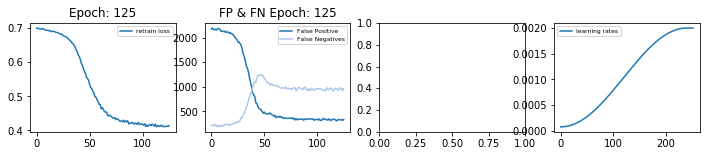

Epoch 126 started.
Retrain dataset size(s): 7774



Epoch 126 completed.
Retrain metrics
_________________________________________ METRICS for epoch 126 _______________________________________________________
accuracy         :0.83458   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82186   bmark:(0.8974)  sen.beaten:False
specificity      :0.86462   bmark:(0.7601)  spe.beaten:True
mcc              :0.64575   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4489  | fp:313  |
| fn:973  | tn:1999 |
---------------------
Epoch 127 started.
Retrain dataset size(s): 7774



Epoch 127 completed.
Retrain metrics
_________________________________________ METRICS for epoch 127 _______________________________________________________
accuracy         :0.83355   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82442   bmark:(0.8974)  sen.beaten:False
specificity      :0.85510   bmark:(0.7601)  spe.beaten:True
mcc              :0.64072   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4503  | fp:335  |
| fn:959  | tn:1977 |
---------------------
Epoch 128 started.
Retrain dataset size(s): 7774



Epoch 128 completed.
Retrain metrics
_________________________________________ METRICS for epoch 128 _______________________________________________________
accuracy         :0.83689   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.83047   bmark:(0.8974)  sen.beaten:False
specificity      :0.85208   bmark:(0.7601)  spe.beaten:True
mcc              :0.64532   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4536  | fp:342  |
| fn:926  | tn:1970 |
---------------------
Epoch 129 started.
Retrain dataset size(s): 7774



Epoch 129 completed.
Retrain metrics
_________________________________________ METRICS for epoch 129 _______________________________________________________
accuracy         :0.83175   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82149   bmark:(0.8974)  sen.beaten:False
specificity      :0.85597   bmark:(0.7601)  spe.beaten:True
mcc              :0.63801   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4487  | fp:333  |
| fn:975  | tn:1979 |
---------------------
Epoch 130 started.
Retrain dataset size(s): 7774



Epoch 130 completed.
Retrain metrics
_________________________________________ METRICS for epoch 130 _______________________________________________________
accuracy         :0.83290   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82113   bmark:(0.8974)  sen.beaten:False
specificity      :0.86073   bmark:(0.7601)  spe.beaten:True
mcc              :0.64160   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4485  | fp:322  |
| fn:977  | tn:1990 |
---------------------


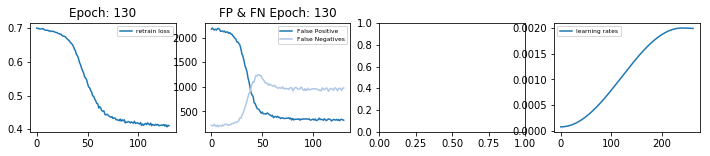

Epoch 131 started.
Retrain dataset size(s): 7774



Epoch 131 completed.
Retrain metrics
_________________________________________ METRICS for epoch 131 _______________________________________________________
accuracy         :0.84024   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.83083   bmark:(0.8974)  sen.beaten:False
specificity      :0.86246   bmark:(0.7601)  spe.beaten:True
mcc              :0.65449   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4538  | fp:318  |
| fn:924  | tn:1994 |
---------------------
Epoch 132 started.
Retrain dataset size(s): 7774



Epoch 132 completed.
Retrain metrics
_________________________________________ METRICS for epoch 132 _______________________________________________________
accuracy         :0.83548   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82699   bmark:(0.8974)  sen.beaten:False
specificity      :0.85554   bmark:(0.7601)  spe.beaten:True
mcc              :0.64411   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4517  | fp:334  |
| fn:945  | tn:1978 |
---------------------
Epoch 133 started.
Retrain dataset size(s): 7774



Epoch 133 completed.
Retrain metrics
_________________________________________ METRICS for epoch 133 _______________________________________________________
accuracy         :0.83818   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82992   bmark:(0.8974)  sen.beaten:False
specificity      :0.85770   bmark:(0.7601)  spe.beaten:True
mcc              :0.64940   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4533  | fp:329  |
| fn:929  | tn:1983 |
---------------------
Epoch 134 started.
Retrain dataset size(s): 7774



Epoch 134 completed.
Retrain metrics
_________________________________________ METRICS for epoch 134 _______________________________________________________
accuracy         :0.83844   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82662   bmark:(0.8974)  sen.beaten:False
specificity      :0.86635   bmark:(0.7601)  spe.beaten:True
mcc              :0.65278   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4515  | fp:309  |
| fn:947  | tn:2003 |
---------------------
Epoch 135 started.
Retrain dataset size(s): 7774



Epoch 135 completed.
Retrain metrics
_________________________________________ METRICS for epoch 135 _______________________________________________________
accuracy         :0.83445   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82424   bmark:(0.8974)  sen.beaten:False
specificity      :0.85856   bmark:(0.7601)  spe.beaten:True
mcc              :0.64342   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4502  | fp:327  |
| fn:960  | tn:1985 |
---------------------


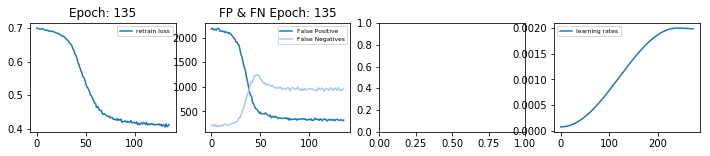

Epoch 136 started.
Retrain dataset size(s): 7774



Epoch 136 completed.
Retrain metrics
_________________________________________ METRICS for epoch 136 _______________________________________________________
accuracy         :0.83471   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82534   bmark:(0.8974)  sen.beaten:False
specificity      :0.85683   bmark:(0.7601)  spe.beaten:True
mcc              :0.64325   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4508  | fp:331  |
| fn:954  | tn:1981 |
---------------------
Epoch 137 started.
Retrain dataset size(s): 7774



Epoch 137 completed.
Retrain metrics
_________________________________________ METRICS for epoch 137 _______________________________________________________
accuracy         :0.83573   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82808   bmark:(0.8974)  sen.beaten:False
specificity      :0.85381   bmark:(0.7601)  spe.beaten:True
mcc              :0.64395   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4523  | fp:338  |
| fn:939  | tn:1974 |
---------------------
Epoch 138 started.
Retrain dataset size(s): 7774



Epoch 138 completed.
Retrain metrics
_________________________________________ METRICS for epoch 138 _______________________________________________________
accuracy         :0.83548   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82955   bmark:(0.8974)  sen.beaten:False
specificity      :0.84948   bmark:(0.7601)  spe.beaten:True
mcc              :0.64205   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4531  | fp:348  |
| fn:931  | tn:1964 |
---------------------
Epoch 139 started.
Retrain dataset size(s): 7774



Epoch 139 completed.
Retrain metrics
_________________________________________ METRICS for epoch 139 _______________________________________________________
accuracy         :0.83316   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82223   bmark:(0.8974)  sen.beaten:False
specificity      :0.85900   bmark:(0.7601)  spe.beaten:True
mcc              :0.64142   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4491  | fp:326  |
| fn:971  | tn:1986 |
---------------------
Epoch 140 started.
Retrain dataset size(s): 7774



Epoch 140 completed.
Retrain metrics
_________________________________________ METRICS for epoch 140 _______________________________________________________
accuracy         :0.83406   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82351   bmark:(0.8974)  sen.beaten:False
specificity      :0.85900   bmark:(0.7601)  spe.beaten:True
mcc              :0.64293   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4498  | fp:326  |
| fn:964  | tn:1986 |
---------------------


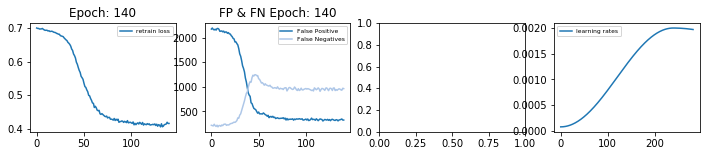

Epoch 141 started.
Retrain dataset size(s): 7774



Epoch 141 completed.
Retrain metrics
_________________________________________ METRICS for epoch 141 _______________________________________________________
accuracy         :0.83342   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82479   bmark:(0.8974)  sen.beaten:False
specificity      :0.85381   bmark:(0.7601)  spe.beaten:True
mcc              :0.64005   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4505  | fp:338  |
| fn:957  | tn:1974 |
---------------------
Epoch 142 started.
Retrain dataset size(s): 7774



Epoch 142 completed.
Retrain metrics
_________________________________________ METRICS for epoch 142 _______________________________________________________
accuracy         :0.83483   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82278   bmark:(0.8974)  sen.beaten:False
specificity      :0.86332   bmark:(0.7601)  spe.beaten:True
mcc              :0.64572   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4494  | fp:316  |
| fn:968  | tn:1996 |
---------------------
Epoch 143 started.
Retrain dataset size(s): 7774



Epoch 143 completed.
Retrain metrics
_________________________________________ METRICS for epoch 143 _______________________________________________________
accuracy         :0.83625   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82808   bmark:(0.8974)  sen.beaten:False
specificity      :0.85554   bmark:(0.7601)  spe.beaten:True
mcc              :0.64541   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4523  | fp:334  |
| fn:939  | tn:1978 |
---------------------
Epoch 144 started.
Retrain dataset size(s): 7774



Epoch 144 completed.
Retrain metrics
_________________________________________ METRICS for epoch 144 _______________________________________________________
accuracy         :0.83329   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82552   bmark:(0.8974)  sen.beaten:False
specificity      :0.85164   bmark:(0.7601)  spe.beaten:True
mcc              :0.63909   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4509  | fp:343  |
| fn:953  | tn:1969 |
---------------------
Epoch 145 started.
Retrain dataset size(s): 7774



Epoch 145 completed.
Retrain metrics
_________________________________________ METRICS for epoch 145 _______________________________________________________
accuracy         :0.83483   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82516   bmark:(0.8974)  sen.beaten:False
specificity      :0.85770   bmark:(0.7601)  spe.beaten:True
mcc              :0.64377   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4507  | fp:329  |
| fn:955  | tn:1983 |
---------------------


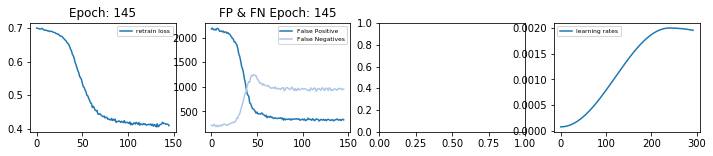

Epoch 146 started.
Retrain dataset size(s): 7774



Epoch 146 completed.
Retrain metrics
_________________________________________ METRICS for epoch 146 _______________________________________________________
accuracy         :0.84088   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82992   bmark:(0.8974)  sen.beaten:False
specificity      :0.86678   bmark:(0.7601)  spe.beaten:True
mcc              :0.65704   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4533  | fp:308  |
| fn:929  | tn:2004 |
---------------------
Epoch 147 started.
Retrain dataset size(s): 7774



Epoch 147 completed.
Retrain metrics
_________________________________________ METRICS for epoch 147 _______________________________________________________
accuracy         :0.83522   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82735   bmark:(0.8974)  sen.beaten:False
specificity      :0.85381   bmark:(0.7601)  spe.beaten:True
mcc              :0.64308   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4519  | fp:338  |
| fn:943  | tn:1974 |
---------------------
Epoch 148 started.
Retrain dataset size(s): 7774



Epoch 148 completed.
Retrain metrics
_________________________________________ METRICS for epoch 148 _______________________________________________________
accuracy         :0.83342   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82479   bmark:(0.8974)  sen.beaten:False
specificity      :0.85381   bmark:(0.7601)  spe.beaten:True
mcc              :0.64005   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4505  | fp:338  |
| fn:957  | tn:1974 |
---------------------
Epoch 149 started.
Retrain dataset size(s): 7774



Epoch 149 completed.
Retrain metrics
_________________________________________ METRICS for epoch 149 _______________________________________________________
accuracy         :0.83265   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82516   bmark:(0.8974)  sen.beaten:False
specificity      :0.85035   bmark:(0.7601)  spe.beaten:True
mcc              :0.63757   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4507  | fp:346  |
| fn:955  | tn:1966 |
---------------------
Epoch 150 started.
Retrain dataset size(s): 7774



Epoch 150 completed.
Retrain metrics
_________________________________________ METRICS for epoch 150 _______________________________________________________
accuracy         :0.83882   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82680   bmark:(0.8974)  sen.beaten:False
specificity      :0.86721   bmark:(0.7601)  spe.beaten:True
mcc              :0.65373   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4516  | fp:307  |
| fn:946  | tn:2005 |
---------------------


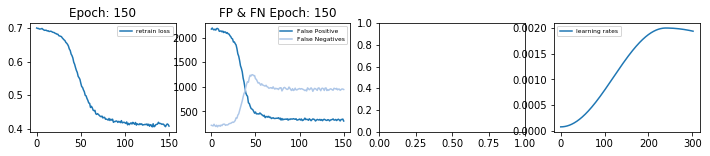

Epoch 151 started.
Retrain dataset size(s): 7774



Epoch 151 completed.
Retrain metrics
_________________________________________ METRICS for epoch 151 _______________________________________________________
accuracy         :0.83895   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82845   bmark:(0.8974)  sen.beaten:False
specificity      :0.86375   bmark:(0.7601)  spe.beaten:True
mcc              :0.65276   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4525  | fp:315  |
| fn:937  | tn:1997 |
---------------------
Epoch 152 started.
Retrain dataset size(s): 7774



Epoch 152 completed.
Retrain metrics
_________________________________________ METRICS for epoch 152 _______________________________________________________
accuracy         :0.83548   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82534   bmark:(0.8974)  sen.beaten:False
specificity      :0.85943   bmark:(0.7601)  spe.beaten:True
mcc              :0.64544   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4508  | fp:325  |
| fn:954  | tn:1987 |
---------------------
Epoch 153 started.
Retrain dataset size(s): 7774



Epoch 153 completed.
Retrain metrics
_________________________________________ METRICS for epoch 153 _______________________________________________________
accuracy         :0.83586   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82332   bmark:(0.8974)  sen.beaten:False
specificity      :0.86548   bmark:(0.7601)  spe.beaten:True
mcc              :0.64819   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4497  | fp:311  |
| fn:965  | tn:2001 |
---------------------
Epoch 154 started.
Retrain dataset size(s): 7774



Epoch 154 completed.
Retrain metrics
_________________________________________ METRICS for epoch 154 _______________________________________________________
accuracy         :0.83651   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82662   bmark:(0.8974)  sen.beaten:False
specificity      :0.85986   bmark:(0.7601)  spe.beaten:True
mcc              :0.64732   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4515  | fp:324  |
| fn:947  | tn:1988 |
---------------------
Epoch 155 started.
Retrain dataset size(s): 7774



Epoch 155 completed.
Retrain metrics
_________________________________________ METRICS for epoch 155 _______________________________________________________
accuracy         :0.83561   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82442   bmark:(0.8974)  sen.beaten:False
specificity      :0.86202   bmark:(0.7601)  spe.beaten:True
mcc              :0.64655   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4503  | fp:319  |
| fn:959  | tn:1993 |
---------------------


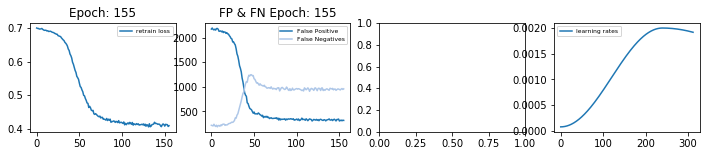

Epoch 156 started.
Retrain dataset size(s): 7774



Epoch 156 completed.
Retrain metrics
_________________________________________ METRICS for epoch 156 _______________________________________________________
accuracy         :0.83316   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82003   bmark:(0.8974)  sen.beaten:False
specificity      :0.86419   bmark:(0.7601)  spe.beaten:True
mcc              :0.64325   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4479  | fp:314  |
| fn:983  | tn:1998 |
---------------------
Epoch 157 started.
Retrain dataset size(s): 7774



Epoch 157 completed.
Retrain metrics
_________________________________________ METRICS for epoch 157 _______________________________________________________
accuracy         :0.83458   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82699   bmark:(0.8974)  sen.beaten:False
specificity      :0.85251   bmark:(0.7601)  spe.beaten:True
mcc              :0.64155   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4517  | fp:341  |
| fn:945  | tn:1971 |
---------------------
Epoch 158 started.
Retrain dataset size(s): 7774



Epoch 158 completed.
Retrain metrics
_________________________________________ METRICS for epoch 158 _______________________________________________________
accuracy         :0.84165   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.83248   bmark:(0.8974)  sen.beaten:False
specificity      :0.86332   bmark:(0.7601)  spe.beaten:True
mcc              :0.65718   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4547  | fp:316  |
| fn:915  | tn:1996 |
---------------------
Epoch 159 started.
Retrain dataset size(s): 7774



Epoch 159 completed.
Retrain metrics
_________________________________________ METRICS for epoch 159 _______________________________________________________
accuracy         :0.83432   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82149   bmark:(0.8974)  sen.beaten:False
specificity      :0.86462   bmark:(0.7601)  spe.beaten:True
mcc              :0.64532   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4487  | fp:313  |
| fn:975  | tn:1999 |
---------------------
Epoch 160 started.
Retrain dataset size(s): 7774



Epoch 160 completed.
Retrain metrics
_________________________________________ METRICS for epoch 160 _______________________________________________________
accuracy         :0.83561   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82680   bmark:(0.8974)  sen.beaten:False
specificity      :0.85640   bmark:(0.7601)  spe.beaten:True
mcc              :0.64462   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4516  | fp:332  |
| fn:946  | tn:1980 |
---------------------


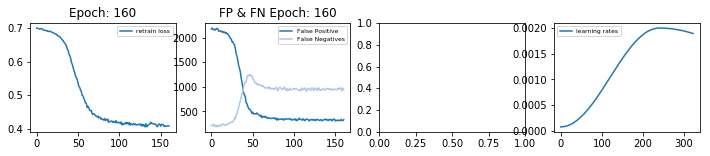

Epoch 161 started.
Retrain dataset size(s): 7774



Epoch 161 completed.
Retrain metrics
_________________________________________ METRICS for epoch 161 _______________________________________________________
accuracy         :0.83972   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.83010   bmark:(0.8974)  sen.beaten:False
specificity      :0.86246   bmark:(0.7601)  spe.beaten:True
mcc              :0.65362   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4534  | fp:318  |
| fn:928  | tn:1994 |
---------------------
Epoch 162 started.
Retrain dataset size(s): 7774



Epoch 162 completed.
Retrain metrics
_________________________________________ METRICS for epoch 162 _______________________________________________________
accuracy         :0.83946   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82863   bmark:(0.8974)  sen.beaten:False
specificity      :0.86505   bmark:(0.7601)  spe.beaten:True
mcc              :0.65407   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4526  | fp:312  |
| fn:936  | tn:2000 |
---------------------
Epoch 163 started.
Retrain dataset size(s): 7774



Epoch 163 completed.
Retrain metrics
_________________________________________ METRICS for epoch 163 _______________________________________________________
accuracy         :0.83959   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82442   bmark:(0.8974)  sen.beaten:False
specificity      :0.87543   bmark:(0.7601)  spe.beaten:True
mcc              :0.65787   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4503  | fp:288  |
| fn:959  | tn:2024 |
---------------------
Epoch 164 started.
Retrain dataset size(s): 7774



Epoch 164 completed.
Retrain metrics
_________________________________________ METRICS for epoch 164 _______________________________________________________
accuracy         :0.83959   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82680   bmark:(0.8974)  sen.beaten:False
specificity      :0.86981   bmark:(0.7601)  spe.beaten:True
mcc              :0.65591   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4516  | fp:301  |
| fn:946  | tn:2011 |
---------------------
Epoch 165 started.
Retrain dataset size(s): 7774



Epoch 165 completed.
Retrain metrics
_________________________________________ METRICS for epoch 165 _______________________________________________________
accuracy         :0.83754   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82625   bmark:(0.8974)  sen.beaten:False
specificity      :0.86419   bmark:(0.7601)  spe.beaten:True
mcc              :0.65053   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4513  | fp:314  |
| fn:949  | tn:1998 |
---------------------


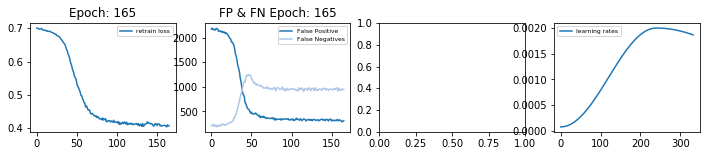

Epoch 166 started.
Retrain dataset size(s): 7774



Epoch 166 completed.
Retrain metrics
_________________________________________ METRICS for epoch 166 _______________________________________________________
accuracy         :0.83766   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81966   bmark:(0.8974)  sen.beaten:False
specificity      :0.88019   bmark:(0.7601)  spe.beaten:True
mcc              :0.65636   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4477  | fp:277  |
| fn:985  | tn:2035 |
---------------------
Epoch 167 started.
Retrain dataset size(s): 7774



Epoch 167 completed.
Retrain metrics
_________________________________________ METRICS for epoch 167 _______________________________________________________
accuracy         :0.83895   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82021   bmark:(0.8974)  sen.beaten:False
specificity      :0.88322   bmark:(0.7601)  spe.beaten:True
mcc              :0.65956   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4480  | fp:270  |
| fn:982  | tn:2042 |
---------------------
Epoch 168 started.
Retrain dataset size(s): 7774



Epoch 168 completed.
Retrain metrics
_________________________________________ METRICS for epoch 168 _______________________________________________________
accuracy         :0.83779   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82406   bmark:(0.8974)  sen.beaten:False
specificity      :0.87024   bmark:(0.7601)  spe.beaten:True
mcc              :0.65306   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4501  | fp:300  |
| fn:961  | tn:2012 |
---------------------
Epoch 169 started.
Retrain dataset size(s): 7774



Epoch 169 completed.
Retrain metrics
_________________________________________ METRICS for epoch 169 _______________________________________________________
accuracy         :0.84088   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.83047   bmark:(0.8974)  sen.beaten:False
specificity      :0.86548   bmark:(0.7601)  spe.beaten:True
mcc              :0.65660   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4536  | fp:311  |
| fn:926  | tn:2001 |
---------------------
Epoch 170 started.
Retrain dataset size(s): 7774



Epoch 170 completed.
Retrain metrics
_________________________________________ METRICS for epoch 170 _______________________________________________________
accuracy         :0.84217   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82644   bmark:(0.8974)  sen.beaten:False
specificity      :0.87933   bmark:(0.7601)  spe.beaten:True
mcc              :0.66350   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4514  | fp:279  |
| fn:948  | tn:2033 |
---------------------


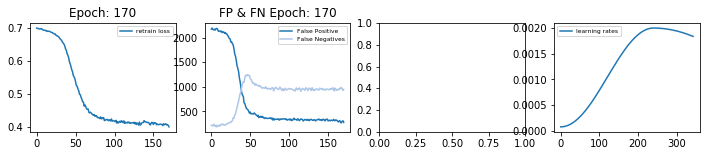

Epoch 171 started.
Retrain dataset size(s): 7774



Epoch 171 completed.
Retrain metrics
_________________________________________ METRICS for epoch 171 _______________________________________________________
accuracy         :0.83805   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81710   bmark:(0.8974)  sen.beaten:False
specificity      :0.88754   bmark:(0.7601)  spe.beaten:True
mcc              :0.65964   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4463  | fp:260  |
| fn:999  | tn:2052 |
---------------------
Epoch 172 started.
Retrain dataset size(s): 7774



Epoch 172 completed.
Retrain metrics
_________________________________________ METRICS for epoch 172 _______________________________________________________
accuracy         :0.83844   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82406   bmark:(0.8974)  sen.beaten:False
specificity      :0.87240   bmark:(0.7601)  spe.beaten:True
mcc              :0.65489   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4501  | fp:295  |
| fn:961  | tn:2017 |
---------------------
Epoch 173 started.
Retrain dataset size(s): 7774



Epoch 173 completed.
Retrain metrics
_________________________________________ METRICS for epoch 173 _______________________________________________________
accuracy         :0.84320   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.83394   bmark:(0.8974)  sen.beaten:False
specificity      :0.86505   bmark:(0.7601)  spe.beaten:True
mcc              :0.66038   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4555  | fp:312  |
| fn:907  | tn:2000 |
---------------------
Epoch 174 started.
Retrain dataset size(s): 7774



Epoch 174 completed.
Retrain metrics
_________________________________________ METRICS for epoch 174 _______________________________________________________
accuracy         :0.83728   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82497   bmark:(0.8974)  sen.beaten:False
specificity      :0.86635   bmark:(0.7601)  spe.beaten:True
mcc              :0.65085   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4506  | fp:309  |
| fn:956  | tn:2003 |
---------------------
Epoch 175 started.
Retrain dataset size(s): 7774



Epoch 175 completed.
Retrain metrics
_________________________________________ METRICS for epoch 175 _______________________________________________________
accuracy         :0.83934   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81875   bmark:(0.8974)  sen.beaten:False
specificity      :0.88798   bmark:(0.7601)  spe.beaten:True
mcc              :0.66190   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4472  | fp:259  |
| fn:990  | tn:2053 |
---------------------


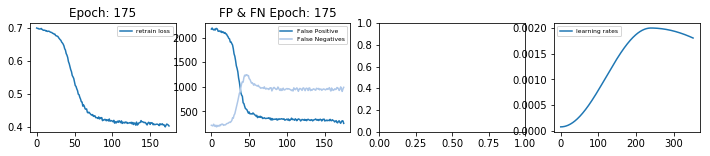

Epoch 176 started.
Retrain dataset size(s): 7774



Epoch 176 completed.
Retrain metrics
_________________________________________ METRICS for epoch 176 _______________________________________________________
accuracy         :0.84049   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82223   bmark:(0.8974)  sen.beaten:False
specificity      :0.88365   bmark:(0.7601)  spe.beaten:True
mcc              :0.66225   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4491  | fp:269  |
| fn:971  | tn:2043 |
---------------------
Epoch 177 started.
Retrain dataset size(s): 7774



Epoch 177 completed.
Retrain metrics
_________________________________________ METRICS for epoch 177 _______________________________________________________
accuracy         :0.83998   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82625   bmark:(0.8974)  sen.beaten:False
specificity      :0.87240   bmark:(0.7601)  spe.beaten:True
mcc              :0.65746   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4513  | fp:295  |
| fn:949  | tn:2017 |
---------------------
Epoch 178 started.
Retrain dataset size(s): 7774



Epoch 178 completed.
Retrain metrics
_________________________________________ METRICS for epoch 178 _______________________________________________________
accuracy         :0.83779   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82644   bmark:(0.8974)  sen.beaten:False
specificity      :0.86462   bmark:(0.7601)  spe.beaten:True
mcc              :0.65111   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4514  | fp:313  |
| fn:948  | tn:1999 |
---------------------
Epoch 179 started.
Retrain dataset size(s): 7774



Epoch 179 completed.
Retrain metrics
_________________________________________ METRICS for epoch 179 _______________________________________________________
accuracy         :0.83689   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82131   bmark:(0.8974)  sen.beaten:False
specificity      :0.87370   bmark:(0.7601)  spe.beaten:True
mcc              :0.65278   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4486  | fp:292  |
| fn:976  | tn:2020 |
---------------------
Epoch 180 started.
Retrain dataset size(s): 7774



Epoch 180 completed.
Retrain metrics
_________________________________________ METRICS for epoch 180 _______________________________________________________
accuracy         :0.83548   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81966   bmark:(0.8974)  sen.beaten:False
specificity      :0.87284   bmark:(0.7601)  spe.beaten:True
mcc              :0.65014   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4477  | fp:294  |
| fn:985  | tn:2018 |
---------------------


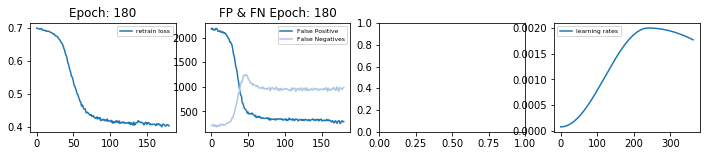

Epoch 181 started.
Retrain dataset size(s): 7774



Epoch 181 completed.
Retrain metrics
_________________________________________ METRICS for epoch 181 _______________________________________________________
accuracy         :0.83921   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82607   bmark:(0.8974)  sen.beaten:False
specificity      :0.87024   bmark:(0.7601)  spe.beaten:True
mcc              :0.65542   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4512  | fp:300  |
| fn:950  | tn:2012 |
---------------------
Epoch 182 started.
Retrain dataset size(s): 7774



Epoch 182 completed.
Retrain metrics
_________________________________________ METRICS for epoch 182 _______________________________________________________
accuracy         :0.83625   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81673   bmark:(0.8974)  sen.beaten:False
specificity      :0.88235   bmark:(0.7601)  spe.beaten:True
mcc              :0.65482   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4461  | fp:272  |
| fn:1001  | tn:2040 |
---------------------
Epoch 183 started.
Retrain dataset size(s): 7774



Epoch 183 completed.
Retrain metrics
_________________________________________ METRICS for epoch 183 _______________________________________________________
accuracy         :0.83856   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81930   bmark:(0.8974)  sen.beaten:False
specificity      :0.88408   bmark:(0.7601)  spe.beaten:True
mcc              :0.65923   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4475  | fp:268  |
| fn:987  | tn:2044 |
---------------------
Epoch 184 started.
Retrain dataset size(s): 7774



Epoch 184 completed.
Retrain metrics
_________________________________________ METRICS for epoch 184 _______________________________________________________
accuracy         :0.83985   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82461   bmark:(0.8974)  sen.beaten:False
specificity      :0.87587   bmark:(0.7601)  spe.beaten:True
mcc              :0.65845   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4504  | fp:287  |
| fn:958  | tn:2025 |
---------------------
Epoch 185 started.
Retrain dataset size(s): 7774



Epoch 185 completed.
Retrain metrics
_________________________________________ METRICS for epoch 185 _______________________________________________________
accuracy         :0.84127   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82644   bmark:(0.8974)  sen.beaten:False
specificity      :0.87630   bmark:(0.7601)  spe.beaten:True
mcc              :0.66095   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4514  | fp:286  |
| fn:948  | tn:2026 |
---------------------


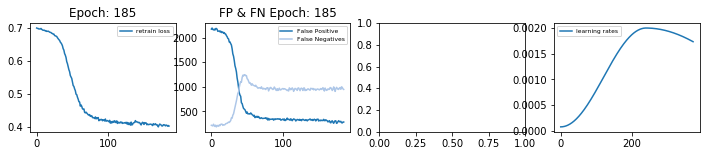

Epoch 186 started.
Retrain dataset size(s): 7774



Epoch 186 completed.
Retrain metrics
_________________________________________ METRICS for epoch 186 _______________________________________________________
accuracy         :0.83882   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82204   bmark:(0.8974)  sen.beaten:False
specificity      :0.87846   bmark:(0.7601)  spe.beaten:True
mcc              :0.65765   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4490  | fp:281  |
| fn:972  | tn:2031 |
---------------------
Epoch 187 started.
Retrain dataset size(s): 7774



Epoch 187 completed.
Retrain metrics
_________________________________________ METRICS for epoch 187 _______________________________________________________
accuracy         :0.84191   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82424   bmark:(0.8974)  sen.beaten:False
specificity      :0.88365   bmark:(0.7601)  spe.beaten:True
mcc              :0.66459   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4502  | fp:269  |
| fn:960  | tn:2043 |
---------------------
Epoch 188 started.
Retrain dataset size(s): 7774



Epoch 188 completed.
Retrain metrics
_________________________________________ METRICS for epoch 188 _______________________________________________________
accuracy         :0.83959   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82369   bmark:(0.8974)  sen.beaten:False
specificity      :0.87716   bmark:(0.7601)  spe.beaten:True
mcc              :0.65847   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4499  | fp:284  |
| fn:963  | tn:2028 |
---------------------
Epoch 189 started.
Retrain dataset size(s): 7774



Epoch 189 completed.
Retrain metrics
_________________________________________ METRICS for epoch 189 _______________________________________________________
accuracy         :0.83754   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82516   bmark:(0.8974)  sen.beaten:False
specificity      :0.86678   bmark:(0.7601)  spe.beaten:True
mcc              :0.65143   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4507  | fp:308  |
| fn:955  | tn:2004 |
---------------------
Epoch 190 started.
Retrain dataset size(s): 7774



Epoch 190 completed.
Retrain metrics
_________________________________________ METRICS for epoch 190 _______________________________________________________
accuracy         :0.83998   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82387   bmark:(0.8974)  sen.beaten:False
specificity      :0.87803   bmark:(0.7601)  spe.beaten:True
mcc              :0.65942   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4500  | fp:282  |
| fn:962  | tn:2030 |
---------------------


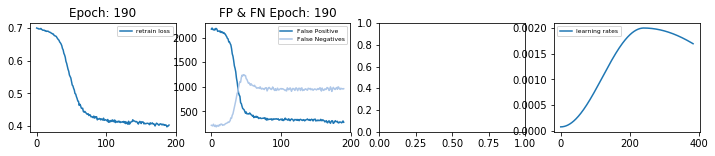

Epoch 191 started.
Retrain dataset size(s): 7774



Epoch 191 completed.
Retrain metrics
_________________________________________ METRICS for epoch 191 _______________________________________________________
accuracy         :0.83766   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81985   bmark:(0.8974)  sen.beaten:False
specificity      :0.87976   bmark:(0.7601)  spe.beaten:True
mcc              :0.65621   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4478  | fp:278  |
| fn:984  | tn:2034 |
---------------------
Epoch 192 started.
Retrain dataset size(s): 7774



Epoch 192 completed.
Retrain metrics
_________________________________________ METRICS for epoch 192 _______________________________________________________
accuracy         :0.83805   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81948   bmark:(0.8974)  sen.beaten:False
specificity      :0.88192   bmark:(0.7601)  spe.beaten:True
mcc              :0.65762   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4476  | fp:273  |
| fn:986  | tn:2039 |
---------------------
Epoch 193 started.
Retrain dataset size(s): 7774



Epoch 193 completed.
Retrain metrics
_________________________________________ METRICS for epoch 193 _______________________________________________________
accuracy         :0.84062   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82223   bmark:(0.8974)  sen.beaten:False
specificity      :0.88408   bmark:(0.7601)  spe.beaten:True
mcc              :0.66262   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4491  | fp:268  |
| fn:971  | tn:2044 |
---------------------
Epoch 194 started.
Retrain dataset size(s): 7774



Epoch 194 completed.
Retrain metrics
_________________________________________ METRICS for epoch 194 _______________________________________________________
accuracy         :0.83676   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82241   bmark:(0.8974)  sen.beaten:False
specificity      :0.87067   bmark:(0.7601)  spe.beaten:True
mcc              :0.65150   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4492  | fp:299  |
| fn:970  | tn:2013 |
---------------------
Epoch 195 started.
Retrain dataset size(s): 7774



Epoch 195 completed.
Retrain metrics
_________________________________________ METRICS for epoch 195 _______________________________________________________
accuracy         :0.83844   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82278   bmark:(0.8974)  sen.beaten:False
specificity      :0.87543   bmark:(0.7601)  spe.beaten:True
mcc              :0.65595   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4494  | fp:288  |
| fn:968  | tn:2024 |
---------------------


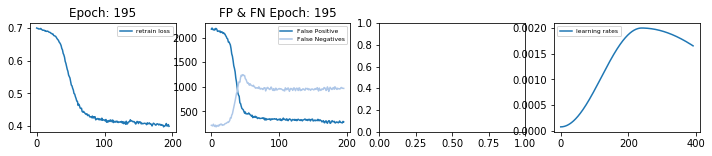

Epoch 196 started.
Retrain dataset size(s): 7774



Epoch 196 completed.
Retrain metrics
_________________________________________ METRICS for epoch 196 _______________________________________________________
accuracy         :0.83985   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82552   bmark:(0.8974)  sen.beaten:False
specificity      :0.87370   bmark:(0.7601)  spe.beaten:True
mcc              :0.65769   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4509  | fp:292  |
| fn:953  | tn:2020 |
---------------------
Epoch 197 started.
Retrain dataset size(s): 7774



Epoch 197 completed.
Retrain metrics
_________________________________________ METRICS for epoch 197 _______________________________________________________
accuracy         :0.83586   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82241   bmark:(0.8974)  sen.beaten:False
specificity      :0.86765   bmark:(0.7601)  spe.beaten:True
mcc              :0.64894   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4492  | fp:306  |
| fn:970  | tn:2006 |
---------------------
Epoch 198 started.
Retrain dataset size(s): 7774



Epoch 198 completed.
Retrain metrics
_________________________________________ METRICS for epoch 198 _______________________________________________________
accuracy         :0.83689   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81948   bmark:(0.8974)  sen.beaten:False
specificity      :0.87803   bmark:(0.7601)  spe.beaten:True
mcc              :0.65432   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4476  | fp:282  |
| fn:986  | tn:2030 |
---------------------
Epoch 199 started.
Retrain dataset size(s): 7774



Epoch 199 completed.
Retrain metrics
_________________________________________ METRICS for epoch 199 _______________________________________________________
accuracy         :0.83728   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82094   bmark:(0.8974)  sen.beaten:False
specificity      :0.87587   bmark:(0.7601)  spe.beaten:True
mcc              :0.65419   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4484  | fp:287  |
| fn:978  | tn:2025 |
---------------------
Epoch 200 started.
Retrain dataset size(s): 7774



Epoch 200 completed.
Retrain metrics
_________________________________________ METRICS for epoch 200 _______________________________________________________
accuracy         :0.84075   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82442   bmark:(0.8974)  sen.beaten:False
specificity      :0.87933   bmark:(0.7601)  spe.beaten:True
mcc              :0.66115   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4503  | fp:279  |
| fn:959  | tn:2033 |
---------------------


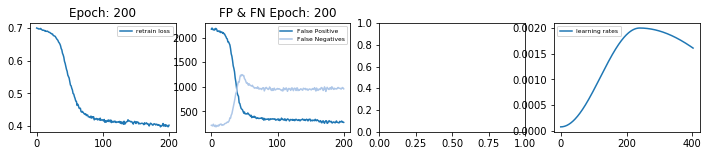

Epoch 201 started.
Retrain dataset size(s): 7774



Epoch 201 completed.
Retrain metrics
_________________________________________ METRICS for epoch 201 _______________________________________________________
accuracy         :0.83805   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82278   bmark:(0.8974)  sen.beaten:False
specificity      :0.87413   bmark:(0.7601)  spe.beaten:True
mcc              :0.65485   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4494  | fp:291  |
| fn:968  | tn:2021 |
---------------------
Epoch 202 started.
Retrain dataset size(s): 7774



Epoch 202 completed.
Retrain metrics
_________________________________________ METRICS for epoch 202 _______________________________________________________
accuracy         :0.83972   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82058   bmark:(0.8974)  sen.beaten:False
specificity      :0.88495   bmark:(0.7601)  spe.beaten:True
mcc              :0.66144   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4482  | fp:266  |
| fn:980  | tn:2046 |
---------------------
Epoch 203 started.
Retrain dataset size(s): 7774



Epoch 203 completed.
Retrain metrics
_________________________________________ METRICS for epoch 203 _______________________________________________________
accuracy         :0.83959   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81966   bmark:(0.8974)  sen.beaten:False
specificity      :0.88668   bmark:(0.7601)  spe.beaten:True
mcc              :0.66185   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4477  | fp:262  |
| fn:985  | tn:2050 |
---------------------
Epoch 204 started.
Retrain dataset size(s): 7774



Epoch 204 completed.
Retrain metrics
_________________________________________ METRICS for epoch 204 _______________________________________________________
accuracy         :0.83998   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82204   bmark:(0.8974)  sen.beaten:False
specificity      :0.88235   bmark:(0.7601)  spe.beaten:True
mcc              :0.66094   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4490  | fp:272  |
| fn:972  | tn:2040 |
---------------------
Epoch 205 started.
Retrain dataset size(s): 7774



Epoch 205 completed.
Retrain metrics
_________________________________________ METRICS for epoch 205 _______________________________________________________
accuracy         :0.84384   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82735   bmark:(0.8974)  sen.beaten:False
specificity      :0.88279   bmark:(0.7601)  spe.beaten:True
mcc              :0.66749   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4519  | fp:271  |
| fn:943  | tn:2041 |
---------------------


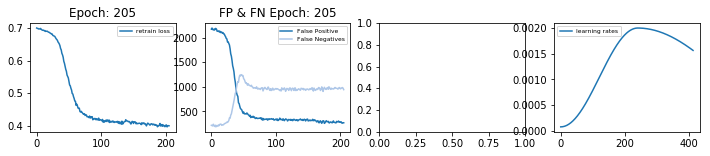

Epoch 206 started.
Retrain dataset size(s): 7774



Epoch 206 completed.
Retrain metrics
_________________________________________ METRICS for epoch 206 _______________________________________________________
accuracy         :0.83818   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81856   bmark:(0.8974)  sen.beaten:False
specificity      :0.88452   bmark:(0.7601)  spe.beaten:True
mcc              :0.65876   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4471  | fp:267  |
| fn:991  | tn:2045 |
---------------------
Epoch 207 started.
Retrain dataset size(s): 7774



Epoch 207 completed.
Retrain metrics
_________________________________________ METRICS for epoch 207 _______________________________________________________
accuracy         :0.83972   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81893   bmark:(0.8974)  sen.beaten:False
specificity      :0.88884   bmark:(0.7601)  spe.beaten:True
mcc              :0.66284   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4473  | fp:257  |
| fn:989  | tn:2055 |
---------------------
Epoch 208 started.
Retrain dataset size(s): 7774



Epoch 208 completed.
Retrain metrics
_________________________________________ METRICS for epoch 208 _______________________________________________________
accuracy         :0.84165   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82259   bmark:(0.8974)  sen.beaten:False
specificity      :0.88668   bmark:(0.7601)  spe.beaten:True
mcc              :0.66523   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4493  | fp:262  |
| fn:969  | tn:2050 |
---------------------
Epoch 209 started.
Retrain dataset size(s): 7774



Epoch 209 completed.
Retrain metrics
_________________________________________ METRICS for epoch 209 _______________________________________________________
accuracy         :0.84410   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82717   bmark:(0.8974)  sen.beaten:False
specificity      :0.88408   bmark:(0.7601)  spe.beaten:True
mcc              :0.66837   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4518  | fp:268  |
| fn:944  | tn:2044 |
---------------------
Epoch 210 started.
Retrain dataset size(s): 7774



Epoch 210 completed.
Retrain metrics
_________________________________________ METRICS for epoch 210 _______________________________________________________
accuracy         :0.84037   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82186   bmark:(0.8974)  sen.beaten:False
specificity      :0.88408   bmark:(0.7601)  spe.beaten:True
mcc              :0.66219   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4489  | fp:268  |
| fn:973  | tn:2044 |
---------------------


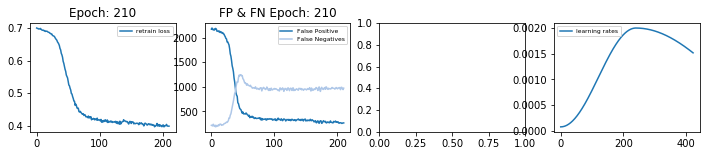

Epoch 211 started.
Retrain dataset size(s): 7774



Epoch 211 completed.
Retrain metrics
_________________________________________ METRICS for epoch 211 _______________________________________________________
accuracy         :0.83805   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81509   bmark:(0.8974)  sen.beaten:False
specificity      :0.89230   bmark:(0.7601)  spe.beaten:True
mcc              :0.66138   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4452  | fp:249  |
| fn:1010  | tn:2063 |
---------------------
Epoch 212 started.
Retrain dataset size(s): 7774



Epoch 212 completed.
Retrain metrics
_________________________________________ METRICS for epoch 212 _______________________________________________________
accuracy         :0.83831   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81545   bmark:(0.8974)  sen.beaten:False
specificity      :0.89230   bmark:(0.7601)  spe.beaten:True
mcc              :0.66180   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4454  | fp:249  |
| fn:1008  | tn:2063 |
---------------------
Epoch 213 started.
Retrain dataset size(s): 7774



Epoch 213 completed.
Retrain metrics
_________________________________________ METRICS for epoch 213 _______________________________________________________
accuracy         :0.84268   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82662   bmark:(0.8974)  sen.beaten:False
specificity      :0.88062   bmark:(0.7601)  spe.beaten:True
mcc              :0.66481   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4515  | fp:276  |
| fn:947  | tn:2036 |
---------------------
Epoch 214 started.
Retrain dataset size(s): 7774



Epoch 214 completed.
Retrain metrics
_________________________________________ METRICS for epoch 214 _______________________________________________________
accuracy         :0.84628   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.83339   bmark:(0.8974)  sen.beaten:False
specificity      :0.87673   bmark:(0.7601)  spe.beaten:True
mcc              :0.66952   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4552  | fp:285  |
| fn:910  | tn:2027 |
---------------------
Epoch 215 started.
Retrain dataset size(s): 7774



Epoch 215 completed.
Retrain metrics
_________________________________________ METRICS for epoch 215 _______________________________________________________
accuracy         :0.83792   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81911   bmark:(0.8974)  sen.beaten:False
specificity      :0.88235   bmark:(0.7601)  spe.beaten:True
mcc              :0.65756   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4474  | fp:272  |
| fn:988  | tn:2040 |
---------------------


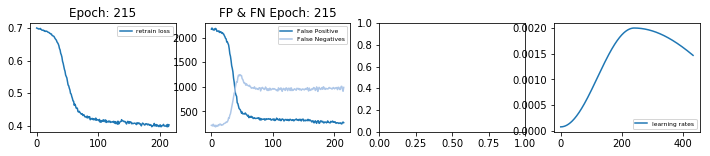

Epoch 216 started.
Retrain dataset size(s): 7774



Epoch 216 completed.
Retrain metrics
_________________________________________ METRICS for epoch 216 _______________________________________________________
accuracy         :0.83496   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81088   bmark:(0.8974)  sen.beaten:False
specificity      :0.89187   bmark:(0.7601)  spe.beaten:True
mcc              :0.65624   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4429  | fp:250  |
| fn:1033  | tn:2062 |
---------------------
Epoch 217 started.
Retrain dataset size(s): 7774



Epoch 217 completed.
Retrain metrics
_________________________________________ METRICS for epoch 217 _______________________________________________________
accuracy         :0.84255   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82332   bmark:(0.8974)  sen.beaten:False
specificity      :0.88798   bmark:(0.7601)  spe.beaten:True
mcc              :0.66718   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4497  | fp:259  |
| fn:965  | tn:2053 |
---------------------
Epoch 218 started.
Retrain dataset size(s): 7774



Epoch 218 completed.
Retrain metrics
_________________________________________ METRICS for epoch 218 _______________________________________________________
accuracy         :0.84204   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82058   bmark:(0.8974)  sen.beaten:False
specificity      :0.89273   bmark:(0.7601)  spe.beaten:True
mcc              :0.66803   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4482  | fp:248  |
| fn:980  | tn:2064 |
---------------------
Epoch 219 started.
Retrain dataset size(s): 7774



Epoch 219 completed.
Retrain metrics
_________________________________________ METRICS for epoch 219 _______________________________________________________
accuracy         :0.83869   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81838   bmark:(0.8974)  sen.beaten:False
specificity      :0.88668   bmark:(0.7601)  spe.beaten:True
mcc              :0.66038   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4470  | fp:262  |
| fn:992  | tn:2050 |
---------------------
Epoch 220 started.
Retrain dataset size(s): 7774



Epoch 220 completed.
Retrain metrics
_________________________________________ METRICS for epoch 220 _______________________________________________________
accuracy         :0.84075   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81673   bmark:(0.8974)  sen.beaten:False
specificity      :0.89749   bmark:(0.7601)  spe.beaten:True
mcc              :0.66766   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4461  | fp:237  |
| fn:1001  | tn:2075 |
---------------------


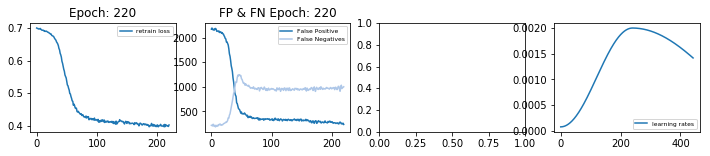

Epoch 221 started.
Retrain dataset size(s): 7774



Epoch 221 completed.
Retrain metrics
_________________________________________ METRICS for epoch 221 _______________________________________________________
accuracy         :0.84320   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82369   bmark:(0.8974)  sen.beaten:False
specificity      :0.88927   bmark:(0.7601)  spe.beaten:True
mcc              :0.66870   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4499  | fp:256  |
| fn:963  | tn:2056 |
---------------------
Epoch 222 started.
Retrain dataset size(s): 7774



Epoch 222 completed.
Retrain metrics
_________________________________________ METRICS for epoch 222 _______________________________________________________
accuracy         :0.84088   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82278   bmark:(0.8974)  sen.beaten:False
specificity      :0.88365   bmark:(0.7601)  spe.beaten:True
mcc              :0.66289   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4494  | fp:269  |
| fn:968  | tn:2043 |
---------------------
Epoch 223 started.
Retrain dataset size(s): 7774



Epoch 223 completed.
Retrain metrics
_________________________________________ METRICS for epoch 223 _______________________________________________________
accuracy         :0.83908   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82094   bmark:(0.8974)  sen.beaten:False
specificity      :0.88192   bmark:(0.7601)  spe.beaten:True
mcc              :0.65931   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4484  | fp:273  |
| fn:978  | tn:2039 |
---------------------
Epoch 224 started.
Retrain dataset size(s): 7774



Epoch 224 completed.
Retrain metrics
_________________________________________ METRICS for epoch 224 _______________________________________________________
accuracy         :0.84422   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82479   bmark:(0.8974)  sen.beaten:False
specificity      :0.89014   bmark:(0.7601)  spe.beaten:True
mcc              :0.67070   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4505  | fp:254  |
| fn:957  | tn:2058 |
---------------------
Epoch 225 started.
Retrain dataset size(s): 7774



Epoch 225 completed.
Retrain metrics
_________________________________________ METRICS for epoch 225 _______________________________________________________
accuracy         :0.84037   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81728   bmark:(0.8974)  sen.beaten:False
specificity      :0.89490   bmark:(0.7601)  spe.beaten:True
mcc              :0.66609   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4464  | fp:243  |
| fn:998  | tn:2069 |
---------------------


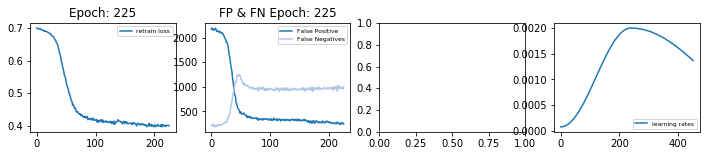

Epoch 226 started.
Retrain dataset size(s): 7774



Epoch 226 completed.
Retrain metrics
_________________________________________ METRICS for epoch 226 _______________________________________________________
accuracy         :0.84204   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82186   bmark:(0.8974)  sen.beaten:False
specificity      :0.88971   bmark:(0.7601)  spe.beaten:True
mcc              :0.66695   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4489  | fp:255  |
| fn:973  | tn:2057 |
---------------------
Epoch 227 started.
Retrain dataset size(s): 7774



Epoch 227 completed.
Retrain metrics
_________________________________________ METRICS for epoch 227 _______________________________________________________
accuracy         :0.84101   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82387   bmark:(0.8974)  sen.beaten:False
specificity      :0.88149   bmark:(0.7601)  spe.beaten:True
mcc              :0.66234   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4500  | fp:274  |
| fn:962  | tn:2038 |
---------------------
Epoch 228 started.
Retrain dataset size(s): 7774



Epoch 228 completed.
Retrain metrics
_________________________________________ METRICS for epoch 228 _______________________________________________________
accuracy         :0.84127   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81930   bmark:(0.8974)  sen.beaten:False
specificity      :0.89317   bmark:(0.7601)  spe.beaten:True
mcc              :0.66692   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4475  | fp:247  |
| fn:987  | tn:2065 |
---------------------
Epoch 229 started.
Retrain dataset size(s): 7774



Epoch 229 completed.
Retrain metrics
_________________________________________ METRICS for epoch 229 _______________________________________________________
accuracy         :0.83908   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81747   bmark:(0.8974)  sen.beaten:False
specificity      :0.89014   bmark:(0.7601)  spe.beaten:True
mcc              :0.66226   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4465  | fp:254  |
| fn:997  | tn:2058 |
---------------------
Epoch 230 started.
Retrain dataset size(s): 7774



Epoch 230 completed.
Retrain metrics
_________________________________________ METRICS for epoch 230 _______________________________________________________
accuracy         :0.84320   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82461   bmark:(0.8974)  sen.beaten:False
specificity      :0.88711   bmark:(0.7601)  spe.beaten:True
mcc              :0.66794   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4504  | fp:261  |
| fn:958  | tn:2051 |
---------------------


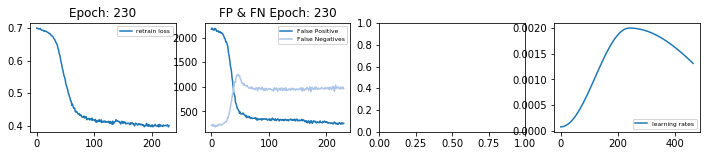

Epoch 231 started.
Retrain dataset size(s): 7774



Epoch 231 completed.
Retrain metrics
_________________________________________ METRICS for epoch 231 _______________________________________________________
accuracy         :0.84191   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82113   bmark:(0.8974)  sen.beaten:False
specificity      :0.89100   bmark:(0.7601)  spe.beaten:True
mcc              :0.66720   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4485  | fp:252  |
| fn:977  | tn:2060 |
---------------------
Epoch 232 started.
Retrain dataset size(s): 7774



Epoch 232 completed.
Retrain metrics
_________________________________________ METRICS for epoch 232 _______________________________________________________
accuracy         :0.84024   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81985   bmark:(0.8974)  sen.beaten:False
specificity      :0.88841   bmark:(0.7601)  spe.beaten:True
mcc              :0.66353   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4478  | fp:258  |
| fn:984  | tn:2054 |
---------------------
Epoch 233 started.
Retrain dataset size(s): 7774



Epoch 233 completed.
Retrain metrics
_________________________________________ METRICS for epoch 233 _______________________________________________________
accuracy         :0.84294   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82369   bmark:(0.8974)  sen.beaten:False
specificity      :0.88841   bmark:(0.7601)  spe.beaten:True
mcc              :0.66797   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4499  | fp:258  |
| fn:963  | tn:2054 |
---------------------
Epoch 234 started.
Retrain dataset size(s): 7774



Epoch 234 completed.
Retrain metrics
_________________________________________ METRICS for epoch 234 _______________________________________________________
accuracy         :0.84088   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82296   bmark:(0.8974)  sen.beaten:False
specificity      :0.88322   bmark:(0.7601)  spe.beaten:True
mcc              :0.66274   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4495  | fp:270  |
| fn:967  | tn:2042 |
---------------------
Epoch 235 started.
Retrain dataset size(s): 7774



Epoch 235 completed.
Retrain metrics
_________________________________________ METRICS for epoch 235 _______________________________________________________
accuracy         :0.83959   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81728   bmark:(0.8974)  sen.beaten:False
specificity      :0.89230   bmark:(0.7601)  spe.beaten:True
mcc              :0.66389   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4464  | fp:249  |
| fn:998  | tn:2063 |
---------------------


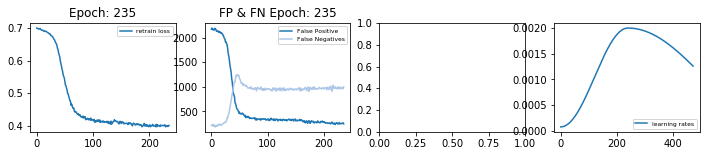

Epoch 236 started.
Retrain dataset size(s): 7774



Epoch 236 completed.
Retrain metrics
_________________________________________ METRICS for epoch 236 _______________________________________________________
accuracy         :0.83934   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81655   bmark:(0.8974)  sen.beaten:False
specificity      :0.89317   bmark:(0.7601)  spe.beaten:True
mcc              :0.66378   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4460  | fp:247  |
| fn:1002  | tn:2065 |
---------------------
Epoch 237 started.
Retrain dataset size(s): 7774



Epoch 237 completed.
Retrain metrics
_________________________________________ METRICS for epoch 237 _______________________________________________________
accuracy         :0.84217   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82204   bmark:(0.8974)  sen.beaten:False
specificity      :0.88971   bmark:(0.7601)  spe.beaten:True
mcc              :0.66716   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4490  | fp:255  |
| fn:972  | tn:2057 |
---------------------
Epoch 238 started.
Retrain dataset size(s): 7774



Epoch 238 completed.
Retrain metrics
_________________________________________ METRICS for epoch 238 _______________________________________________________
accuracy         :0.84165   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82204   bmark:(0.8974)  sen.beaten:False
specificity      :0.88798   bmark:(0.7601)  spe.beaten:True
mcc              :0.66570   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4490  | fp:259  |
| fn:972  | tn:2053 |
---------------------
Epoch 239 started.
Retrain dataset size(s): 7774



Epoch 239 completed.
Retrain metrics
_________________________________________ METRICS for epoch 239 _______________________________________________________
accuracy         :0.84178   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82369   bmark:(0.8974)  sen.beaten:False
specificity      :0.88452   bmark:(0.7601)  spe.beaten:True
mcc              :0.66468   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4499  | fp:267  |
| fn:963  | tn:2045 |
---------------------
Epoch 240 started.
Retrain dataset size(s): 7774



Epoch 240 completed.
Retrain metrics
_________________________________________ METRICS for epoch 240 _______________________________________________________
accuracy         :0.83934   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81600   bmark:(0.8974)  sen.beaten:False
specificity      :0.89446   bmark:(0.7601)  spe.beaten:True
mcc              :0.66426   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4457  | fp:244  |
| fn:1005  | tn:2068 |
---------------------


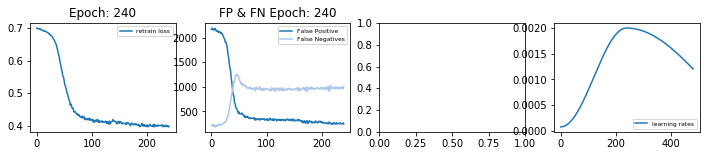

Epoch 241 started.
Retrain dataset size(s): 7774



Epoch 241 completed.
Retrain metrics
_________________________________________ METRICS for epoch 241 _______________________________________________________
accuracy         :0.84088   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81765   bmark:(0.8974)  sen.beaten:False
specificity      :0.89576   bmark:(0.7601)  spe.beaten:True
mcc              :0.66724   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4466  | fp:241  |
| fn:996  | tn:2071 |
---------------------
Epoch 242 started.
Retrain dataset size(s): 7774



Epoch 242 completed.
Retrain metrics
_________________________________________ METRICS for epoch 242 _______________________________________________________
accuracy         :0.84114   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82223   bmark:(0.8974)  sen.beaten:False
specificity      :0.88581   bmark:(0.7601)  spe.beaten:True
mcc              :0.66408   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4491  | fp:264  |
| fn:971  | tn:2048 |
---------------------
Epoch 243 started.
Retrain dataset size(s): 7774



Epoch 243 completed.
Retrain metrics
_________________________________________ METRICS for epoch 243 _______________________________________________________
accuracy         :0.84320   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82699   bmark:(0.8974)  sen.beaten:False
specificity      :0.88149   bmark:(0.7601)  spe.beaten:True
mcc              :0.66597   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4517  | fp:274  |
| fn:945  | tn:2038 |
---------------------
Epoch 244 started.
Retrain dataset size(s): 7774



Epoch 244 completed.
Retrain metrics
_________________________________________ METRICS for epoch 244 _______________________________________________________
accuracy         :0.84024   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82186   bmark:(0.8974)  sen.beaten:False
specificity      :0.88365   bmark:(0.7601)  spe.beaten:True
mcc              :0.66183   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4489  | fp:269  |
| fn:973  | tn:2043 |
---------------------
Epoch 245 started.
Retrain dataset size(s): 7774



Epoch 245 completed.
Retrain metrics
_________________________________________ METRICS for epoch 245 _______________________________________________________
accuracy         :0.83856   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81545   bmark:(0.8974)  sen.beaten:False
specificity      :0.89317   bmark:(0.7601)  spe.beaten:True
mcc              :0.66253   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4454  | fp:247  |
| fn:1008  | tn:2065 |
---------------------


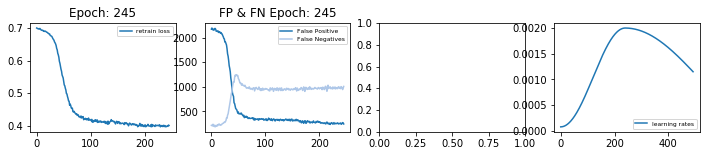

Epoch 246 started.
Retrain dataset size(s): 7774



Epoch 246 completed.
Retrain metrics
_________________________________________ METRICS for epoch 246 _______________________________________________________
accuracy         :0.84127   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81911   bmark:(0.8974)  sen.beaten:False
specificity      :0.89360   bmark:(0.7601)  spe.beaten:True
mcc              :0.66708   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4474  | fp:246  |
| fn:988  | tn:2066 |
---------------------
Epoch 247 started.
Retrain dataset size(s): 7774



Epoch 247 completed.
Retrain metrics
_________________________________________ METRICS for epoch 247 _______________________________________________________
accuracy         :0.84448   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82790   bmark:(0.8974)  sen.beaten:False
specificity      :0.88365   bmark:(0.7601)  spe.beaten:True
mcc              :0.66886   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4522  | fp:269  |
| fn:940  | tn:2043 |
---------------------
Epoch 248 started.
Retrain dataset size(s): 7774



Epoch 248 completed.
Retrain metrics
_________________________________________ METRICS for epoch 248 _______________________________________________________
accuracy         :0.84178   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82131   bmark:(0.8974)  sen.beaten:False
specificity      :0.89014   bmark:(0.7601)  spe.beaten:True
mcc              :0.66668   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4486  | fp:254  |
| fn:976  | tn:2058 |
---------------------
Epoch 249 started.
Retrain dataset size(s): 7774



Epoch 249 completed.
Retrain metrics
_________________________________________ METRICS for epoch 249 _______________________________________________________
accuracy         :0.84114   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81710   bmark:(0.8974)  sen.beaten:False
specificity      :0.89792   bmark:(0.7601)  spe.beaten:True
mcc              :0.66844   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4463  | fp:236  |
| fn:999  | tn:2076 |
---------------------
Epoch 250 started.
Retrain dataset size(s): 7774



Epoch 250 completed.
Retrain metrics
_________________________________________ METRICS for epoch 250 _______________________________________________________
accuracy         :0.83882   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81600   bmark:(0.8974)  sen.beaten:False
specificity      :0.89273   bmark:(0.7601)  spe.beaten:True
mcc              :0.66279   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4457  | fp:248  |
| fn:1005  | tn:2064 |
---------------------


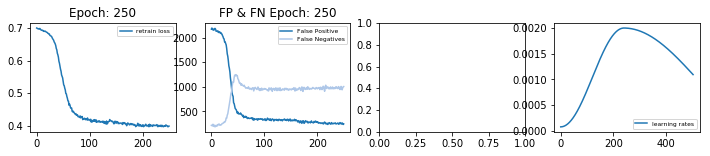

Epoch 251 started.
Retrain dataset size(s): 7774



Epoch 251 completed.
Retrain metrics
_________________________________________ METRICS for epoch 251 _______________________________________________________
accuracy         :0.84384   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82424   bmark:(0.8974)  sen.beaten:False
specificity      :0.89014   bmark:(0.7601)  spe.beaten:True
mcc              :0.67007   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4502  | fp:254  |
| fn:960  | tn:2058 |
---------------------
Epoch 252 started.
Retrain dataset size(s): 7774



Epoch 252 completed.
Retrain metrics
_________________________________________ METRICS for epoch 252 _______________________________________________________
accuracy         :0.84410   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82461   bmark:(0.8974)  sen.beaten:False
specificity      :0.89014   bmark:(0.7601)  spe.beaten:True
mcc              :0.67049   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4504  | fp:254  |
| fn:958  | tn:2058 |
---------------------
Epoch 253 started.
Retrain dataset size(s): 7774



Epoch 253 completed.
Retrain metrics
_________________________________________ METRICS for epoch 253 _______________________________________________________
accuracy         :0.84332   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82570   bmark:(0.8974)  sen.beaten:False
specificity      :0.88495   bmark:(0.7601)  spe.beaten:True
mcc              :0.66739   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4510  | fp:266  |
| fn:952  | tn:2046 |
---------------------
Epoch 254 started.
Retrain dataset size(s): 7774



Epoch 254 completed.
Retrain metrics
_________________________________________ METRICS for epoch 254 _______________________________________________________
accuracy         :0.84294   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82332   bmark:(0.8974)  sen.beaten:False
specificity      :0.88927   bmark:(0.7601)  spe.beaten:True
mcc              :0.66827   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4497  | fp:256  |
| fn:965  | tn:2056 |
---------------------
Epoch 255 started.
Retrain dataset size(s): 7774



Epoch 255 completed.
Retrain metrics
_________________________________________ METRICS for epoch 255 _______________________________________________________
accuracy         :0.84345   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82387   bmark:(0.8974)  sen.beaten:False
specificity      :0.88971   bmark:(0.7601)  spe.beaten:True
mcc              :0.66928   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4500  | fp:255  |
| fn:962  | tn:2057 |
---------------------


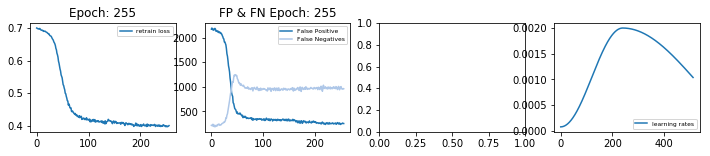

Epoch 256 started.
Retrain dataset size(s): 7774



Epoch 256 completed.
Retrain metrics
_________________________________________ METRICS for epoch 256 _______________________________________________________
accuracy         :0.84551   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82534   bmark:(0.8974)  sen.beaten:False
specificity      :0.89317   bmark:(0.7601)  spe.beaten:True
mcc              :0.67390   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4508  | fp:247  |
| fn:954  | tn:2065 |
---------------------
Epoch 257 started.
Retrain dataset size(s): 7774



Epoch 257 completed.
Retrain metrics
_________________________________________ METRICS for epoch 257 _______________________________________________________
accuracy         :0.84371   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82497   bmark:(0.8974)  sen.beaten:False
specificity      :0.88798   bmark:(0.7601)  spe.beaten:True
mcc              :0.66909   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4506  | fp:259  |
| fn:956  | tn:2053 |
---------------------
Epoch 258 started.
Retrain dataset size(s): 7774



Epoch 258 completed.
Retrain metrics
_________________________________________ METRICS for epoch 258 _______________________________________________________
accuracy         :0.84242   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82442   bmark:(0.8974)  sen.beaten:False
specificity      :0.88495   bmark:(0.7601)  spe.beaten:True
mcc              :0.66590   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4503  | fp:266  |
| fn:959  | tn:2046 |
---------------------
Epoch 259 started.
Retrain dataset size(s): 7774



Epoch 259 completed.
Retrain metrics
_________________________________________ METRICS for epoch 259 _______________________________________________________
accuracy         :0.84294   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82442   bmark:(0.8974)  sen.beaten:False
specificity      :0.88668   bmark:(0.7601)  spe.beaten:True
mcc              :0.66736   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4503  | fp:262  |
| fn:959  | tn:2050 |
---------------------
Epoch 260 started.
Retrain dataset size(s): 7774



Epoch 260 completed.
Retrain metrics
_________________________________________ METRICS for epoch 260 _______________________________________________________
accuracy         :0.84255   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82021   bmark:(0.8974)  sen.beaten:False
specificity      :0.89533   bmark:(0.7601)  spe.beaten:True
mcc              :0.66981   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4480  | fp:242  |
| fn:982  | tn:2070 |
---------------------


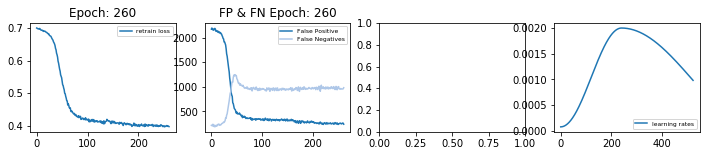

Epoch 261 started.
Retrain dataset size(s): 7774



Epoch 261 completed.
Retrain metrics
_________________________________________ METRICS for epoch 261 _______________________________________________________
accuracy         :0.84358   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82406   bmark:(0.8974)  sen.beaten:False
specificity      :0.88971   bmark:(0.7601)  spe.beaten:True
mcc              :0.66949   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4501  | fp:255  |
| fn:961  | tn:2057 |
---------------------
Epoch 262 started.
Retrain dataset size(s): 7774



Epoch 262 completed.
Retrain metrics
_________________________________________ METRICS for epoch 262 _______________________________________________________
accuracy         :0.84217   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82406   bmark:(0.8974)  sen.beaten:False
specificity      :0.88495   bmark:(0.7601)  spe.beaten:True
mcc              :0.66547   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4501  | fp:266  |
| fn:961  | tn:2046 |
---------------------
Epoch 263 started.
Retrain dataset size(s): 7774



Epoch 263 completed.
Retrain metrics
_________________________________________ METRICS for epoch 263 _______________________________________________________
accuracy         :0.84281   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82497   bmark:(0.8974)  sen.beaten:False
specificity      :0.88495   bmark:(0.7601)  spe.beaten:True
mcc              :0.66654   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4506  | fp:266  |
| fn:956  | tn:2046 |
---------------------
Epoch 264 started.
Retrain dataset size(s): 7774



Epoch 264 completed.
Retrain metrics
_________________________________________ METRICS for epoch 264 _______________________________________________________
accuracy         :0.84500   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82662   bmark:(0.8974)  sen.beaten:False
specificity      :0.88841   bmark:(0.7601)  spe.beaten:True
mcc              :0.67137   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4515  | fp:258  |
| fn:947  | tn:2054 |
---------------------
Epoch 265 started.
Retrain dataset size(s): 7774



Epoch 265 completed.
Retrain metrics
_________________________________________ METRICS for epoch 265 _______________________________________________________
accuracy         :0.84178   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82094   bmark:(0.8974)  sen.beaten:False
specificity      :0.89100   bmark:(0.7601)  spe.beaten:True
mcc              :0.66699   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4484  | fp:252  |
| fn:978  | tn:2060 |
---------------------


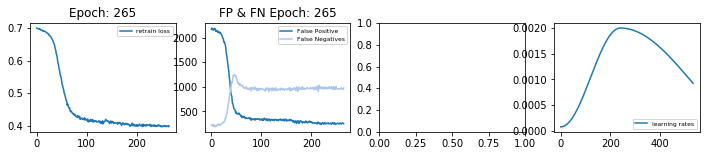

Epoch 266 started.
Retrain dataset size(s): 7774



Epoch 266 completed.
Retrain metrics
_________________________________________ METRICS for epoch 266 _______________________________________________________
accuracy         :0.84204   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82058   bmark:(0.8974)  sen.beaten:False
specificity      :0.89273   bmark:(0.7601)  spe.beaten:True
mcc              :0.66803   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4482  | fp:248  |
| fn:980  | tn:2064 |
---------------------
Epoch 267 started.
Retrain dataset size(s): 7774



Epoch 267 completed.
Retrain metrics
_________________________________________ METRICS for epoch 267 _______________________________________________________
accuracy         :0.84268   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82186   bmark:(0.8974)  sen.beaten:False
specificity      :0.89187   bmark:(0.7601)  spe.beaten:True
mcc              :0.66878   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4489  | fp:250  |
| fn:973  | tn:2062 |
---------------------
Epoch 268 started.
Retrain dataset size(s): 7774



Epoch 268 completed.
Retrain metrics
_________________________________________ METRICS for epoch 268 _______________________________________________________
accuracy         :0.84088   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82003   bmark:(0.8974)  sen.beaten:False
specificity      :0.89014   bmark:(0.7601)  spe.beaten:True
mcc              :0.66520   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4479  | fp:254  |
| fn:983  | tn:2058 |
---------------------
Epoch 269 started.
Retrain dataset size(s): 7774



Epoch 269 completed.
Retrain metrics
_________________________________________ METRICS for epoch 269 _______________________________________________________
accuracy         :0.84049   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82168   bmark:(0.8974)  sen.beaten:False
specificity      :0.88495   bmark:(0.7601)  spe.beaten:True
mcc              :0.66271   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4488  | fp:266  |
| fn:974  | tn:2046 |
---------------------
Epoch 270 started.
Retrain dataset size(s): 7774



Epoch 270 completed.
Retrain metrics
_________________________________________ METRICS for epoch 270 _______________________________________________________
accuracy         :0.84320   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82497   bmark:(0.8974)  sen.beaten:False
specificity      :0.88625   bmark:(0.7601)  spe.beaten:True
mcc              :0.66763   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4506  | fp:263  |
| fn:956  | tn:2049 |
---------------------


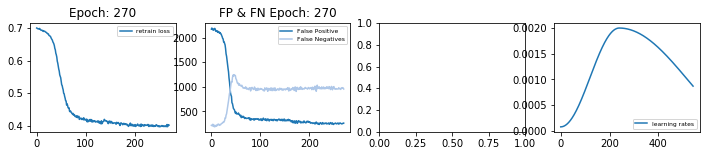

Epoch 271 started.
Retrain dataset size(s): 7774



Epoch 271 completed.
Retrain metrics
_________________________________________ METRICS for epoch 271 _______________________________________________________
accuracy         :0.84577   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82644   bmark:(0.8974)  sen.beaten:False
specificity      :0.89144   bmark:(0.7601)  spe.beaten:True
mcc              :0.67371   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4514  | fp:251  |
| fn:948  | tn:2061 |
---------------------
Epoch 272 started.
Retrain dataset size(s): 7774



Epoch 272 completed.
Retrain metrics
_________________________________________ METRICS for epoch 272 _______________________________________________________
accuracy         :0.84307   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82351   bmark:(0.8974)  sen.beaten:False
specificity      :0.88927   bmark:(0.7601)  spe.beaten:True
mcc              :0.66849   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4498  | fp:256  |
| fn:964  | tn:2056 |
---------------------
Epoch 273 started.
Retrain dataset size(s): 7774



Epoch 273 completed.
Retrain metrics
_________________________________________ METRICS for epoch 273 _______________________________________________________
accuracy         :0.84062   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81985   bmark:(0.8974)  sen.beaten:False
specificity      :0.88971   bmark:(0.7601)  spe.beaten:True
mcc              :0.66463   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4478  | fp:255  |
| fn:984  | tn:2057 |
---------------------
Epoch 274 started.
Retrain dataset size(s): 7774



Epoch 274 completed.
Retrain metrics
_________________________________________ METRICS for epoch 274 _______________________________________________________
accuracy         :0.83959   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81692   bmark:(0.8974)  sen.beaten:False
specificity      :0.89317   bmark:(0.7601)  spe.beaten:True
mcc              :0.66420   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4462  | fp:247  |
| fn:1000  | tn:2065 |
---------------------
Epoch 275 started.
Retrain dataset size(s): 7774



Epoch 275 completed.
Retrain metrics
_________________________________________ METRICS for epoch 275 _______________________________________________________
accuracy         :0.84152   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82296   bmark:(0.8974)  sen.beaten:False
specificity      :0.88538   bmark:(0.7601)  spe.beaten:True
mcc              :0.66456   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4495  | fp:265  |
| fn:967  | tn:2047 |
---------------------


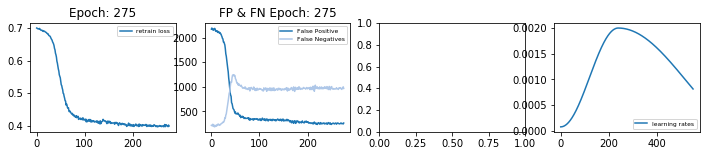

Epoch 276 started.
Retrain dataset size(s): 7774



Epoch 276 completed.
Retrain metrics
_________________________________________ METRICS for epoch 276 _______________________________________________________
accuracy         :0.84307   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82479   bmark:(0.8974)  sen.beaten:False
specificity      :0.88625   bmark:(0.7601)  spe.beaten:True
mcc              :0.66742   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4505  | fp:263  |
| fn:957  | tn:2049 |
---------------------
Epoch 277 started.
Retrain dataset size(s): 7774



Epoch 277 completed.
Retrain metrics
_________________________________________ METRICS for epoch 277 _______________________________________________________
accuracy         :0.84294   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82332   bmark:(0.8974)  sen.beaten:False
specificity      :0.88927   bmark:(0.7601)  spe.beaten:True
mcc              :0.66827   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4497  | fp:256  |
| fn:965  | tn:2056 |
---------------------
Epoch 278 started.
Retrain dataset size(s): 7774



Epoch 278 completed.
Retrain metrics
_________________________________________ METRICS for epoch 278 _______________________________________________________
accuracy         :0.84101   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82076   bmark:(0.8974)  sen.beaten:False
specificity      :0.88884   bmark:(0.7601)  spe.beaten:True
mcc              :0.66495   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4483  | fp:257  |
| fn:979  | tn:2055 |
---------------------
Epoch 279 started.
Retrain dataset size(s): 7774



Epoch 279 completed.
Retrain metrics
_________________________________________ METRICS for epoch 279 _______________________________________________________
accuracy         :0.84512   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82534   bmark:(0.8974)  sen.beaten:False
specificity      :0.89187   bmark:(0.7601)  spe.beaten:True
mcc              :0.67280   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4508  | fp:250  |
| fn:954  | tn:2062 |
---------------------
Epoch 280 started.
Retrain dataset size(s): 7774



Epoch 280 completed.
Retrain metrics
_________________________________________ METRICS for epoch 280 _______________________________________________________
accuracy         :0.84011   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82296   bmark:(0.8974)  sen.beaten:False
specificity      :0.88062   bmark:(0.7601)  spe.beaten:True
mcc              :0.66054   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4495  | fp:276  |
| fn:967  | tn:2036 |
---------------------


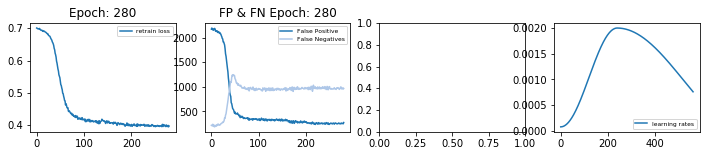

Epoch 281 started.
Retrain dataset size(s): 7774



Epoch 281 completed.
Retrain metrics
_________________________________________ METRICS for epoch 281 _______________________________________________________
accuracy         :0.84152   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82186   bmark:(0.8974)  sen.beaten:False
specificity      :0.88798   bmark:(0.7601)  spe.beaten:True
mcc              :0.66548   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4489  | fp:259  |
| fn:973  | tn:2053 |
---------------------
Epoch 282 started.
Retrain dataset size(s): 7774



Epoch 282 completed.
Retrain metrics
_________________________________________ METRICS for epoch 282 _______________________________________________________
accuracy         :0.84320   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82351   bmark:(0.8974)  sen.beaten:False
specificity      :0.88971   bmark:(0.7601)  spe.beaten:True
mcc              :0.66885   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4498  | fp:255  |
| fn:964  | tn:2057 |
---------------------
Epoch 283 started.
Retrain dataset size(s): 7774



Epoch 283 completed.
Retrain metrics
_________________________________________ METRICS for epoch 283 _______________________________________________________
accuracy         :0.84500   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82332   bmark:(0.8974)  sen.beaten:False
specificity      :0.89619   bmark:(0.7601)  spe.beaten:True
mcc              :0.67412   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4497  | fp:240  |
| fn:965  | tn:2072 |
---------------------
Epoch 284 started.
Retrain dataset size(s): 7774



Epoch 284 completed.
Retrain metrics
_________________________________________ METRICS for epoch 284 _______________________________________________________
accuracy         :0.84127   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81948   bmark:(0.8974)  sen.beaten:False
specificity      :0.89273   bmark:(0.7601)  spe.beaten:True
mcc              :0.66677   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4476  | fp:248  |
| fn:986  | tn:2064 |
---------------------
Epoch 285 started.
Retrain dataset size(s): 7774



Epoch 285 completed.
Retrain metrics
_________________________________________ METRICS for epoch 285 _______________________________________________________
accuracy         :0.84139   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82351   bmark:(0.8974)  sen.beaten:False
specificity      :0.88365   bmark:(0.7601)  spe.beaten:True
mcc              :0.66374   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4498  | fp:269  |
| fn:964  | tn:2043 |
---------------------


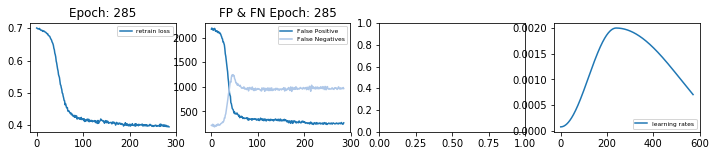

Epoch 286 started.
Retrain dataset size(s): 7774



Epoch 286 completed.
Retrain metrics
_________________________________________ METRICS for epoch 286 _______________________________________________________
accuracy         :0.84551   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82827   bmark:(0.8974)  sen.beaten:False
specificity      :0.88625   bmark:(0.7601)  spe.beaten:True
mcc              :0.67148   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4524  | fp:263  |
| fn:938  | tn:2049 |
---------------------
Epoch 287 started.
Retrain dataset size(s): 7774



Epoch 287 completed.
Retrain metrics
_________________________________________ METRICS for epoch 287 _______________________________________________________
accuracy         :0.84461   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82552   bmark:(0.8974)  sen.beaten:False
specificity      :0.88971   bmark:(0.7601)  spe.beaten:True
mcc              :0.67119   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4509  | fp:255  |
| fn:953  | tn:2057 |
---------------------
Epoch 288 started.
Retrain dataset size(s): 7774



Epoch 288 completed.
Retrain metrics
_________________________________________ METRICS for epoch 288 _______________________________________________________
accuracy         :0.84281   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82241   bmark:(0.8974)  sen.beaten:False
specificity      :0.89100   bmark:(0.7601)  spe.beaten:True
mcc              :0.66868   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4492  | fp:252  |
| fn:970  | tn:2060 |
---------------------
Epoch 289 started.
Retrain dataset size(s): 7774



Epoch 289 completed.
Retrain metrics
_________________________________________ METRICS for epoch 289 _______________________________________________________
accuracy         :0.83946   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81930   bmark:(0.8974)  sen.beaten:False
specificity      :0.88711   bmark:(0.7601)  spe.beaten:True
mcc              :0.66180   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4475  | fp:261  |
| fn:987  | tn:2051 |
---------------------
Epoch 290 started.
Retrain dataset size(s): 7774



Epoch 290 completed.
Retrain metrics
_________________________________________ METRICS for epoch 290 _______________________________________________________
accuracy         :0.84178   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82040   bmark:(0.8974)  sen.beaten:False
specificity      :0.89230   bmark:(0.7601)  spe.beaten:True
mcc              :0.66745   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4481  | fp:249  |
| fn:981  | tn:2063 |
---------------------


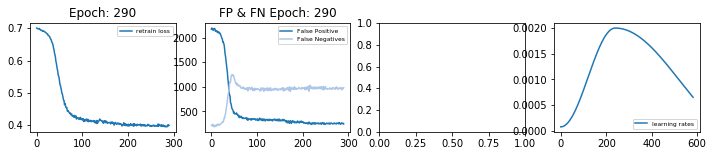

Epoch 291 started.
Retrain dataset size(s): 7774



Epoch 291 completed.
Retrain metrics
_________________________________________ METRICS for epoch 291 _______________________________________________________
accuracy         :0.84422   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82442   bmark:(0.8974)  sen.beaten:False
specificity      :0.89100   bmark:(0.7601)  spe.beaten:True
mcc              :0.67101   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4503  | fp:252  |
| fn:959  | tn:2060 |
---------------------
Epoch 292 started.
Retrain dataset size(s): 7774



Epoch 292 completed.
Retrain metrics
_________________________________________ METRICS for epoch 292 _______________________________________________________
accuracy         :0.84345   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82387   bmark:(0.8974)  sen.beaten:False
specificity      :0.88971   bmark:(0.7601)  spe.beaten:True
mcc              :0.66928   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4500  | fp:255  |
| fn:962  | tn:2057 |
---------------------
Epoch 293 started.
Retrain dataset size(s): 7774



Epoch 293 completed.
Retrain metrics
_________________________________________ METRICS for epoch 293 _______________________________________________________
accuracy         :0.84229   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82589   bmark:(0.8974)  sen.beaten:False
specificity      :0.88106   bmark:(0.7601)  spe.beaten:True
mcc              :0.66432   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4511  | fp:275  |
| fn:951  | tn:2037 |
---------------------
Epoch 294 started.
Retrain dataset size(s): 7774



Epoch 294 completed.
Retrain metrics
_________________________________________ METRICS for epoch 294 _______________________________________________________
accuracy         :0.84127   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81948   bmark:(0.8974)  sen.beaten:False
specificity      :0.89273   bmark:(0.7601)  spe.beaten:True
mcc              :0.66677   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4476  | fp:248  |
| fn:986  | tn:2064 |
---------------------
Epoch 295 started.
Retrain dataset size(s): 7774



Epoch 295 completed.
Retrain metrics
_________________________________________ METRICS for epoch 295 _______________________________________________________
accuracy         :0.84101   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81875   bmark:(0.8974)  sen.beaten:False
specificity      :0.89360   bmark:(0.7601)  spe.beaten:True
mcc              :0.66666   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4472  | fp:246  |
| fn:990  | tn:2066 |
---------------------


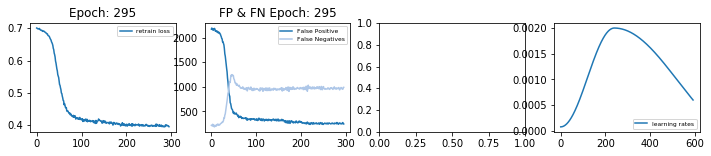

Epoch 296 started.
Retrain dataset size(s): 7774



Epoch 296 completed.
Retrain metrics
_________________________________________ METRICS for epoch 296 _______________________________________________________
accuracy         :0.84165   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82296   bmark:(0.8974)  sen.beaten:False
specificity      :0.88581   bmark:(0.7601)  spe.beaten:True
mcc              :0.66493   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4495  | fp:264  |
| fn:967  | tn:2048 |
---------------------
Epoch 297 started.
Retrain dataset size(s): 7774



Epoch 297 completed.
Retrain metrics
_________________________________________ METRICS for epoch 297 _______________________________________________________
accuracy         :0.84435   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82625   bmark:(0.8974)  sen.beaten:False
specificity      :0.88711   bmark:(0.7601)  spe.beaten:True
mcc              :0.66985   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4513  | fp:261  |
| fn:949  | tn:2051 |
---------------------
Epoch 298 started.
Retrain dataset size(s): 7774



Epoch 298 completed.
Retrain metrics
_________________________________________ METRICS for epoch 298 _______________________________________________________
accuracy         :0.84422   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82204   bmark:(0.8974)  sen.beaten:False
specificity      :0.89663   bmark:(0.7601)  spe.beaten:True
mcc              :0.67301   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4490  | fp:239  |
| fn:972  | tn:2073 |
---------------------
Epoch 299 started.
Retrain dataset size(s): 7774



Epoch 299 completed.
Retrain metrics
_________________________________________ METRICS for epoch 299 _______________________________________________________
accuracy         :0.84538   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82442   bmark:(0.8974)  sen.beaten:False
specificity      :0.89490   bmark:(0.7601)  spe.beaten:True
mcc              :0.67429   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4503  | fp:243  |
| fn:959  | tn:2069 |
---------------------
Epoch 300 started.
Retrain dataset size(s): 7774



Epoch 300 completed.
Retrain metrics
_________________________________________ METRICS for epoch 300 _______________________________________________________
accuracy         :0.84255   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82186   bmark:(0.8974)  sen.beaten:False
specificity      :0.89144   bmark:(0.7601)  spe.beaten:True
mcc              :0.66841   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4489  | fp:251  |
| fn:973  | tn:2061 |
---------------------


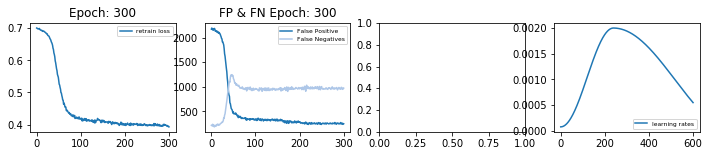

Epoch 301 started.
Retrain dataset size(s): 7774



Epoch 301 completed.
Retrain metrics
_________________________________________ METRICS for epoch 301 _______________________________________________________
accuracy         :0.84345   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82808   bmark:(0.8974)  sen.beaten:False
specificity      :0.87976   bmark:(0.7601)  spe.beaten:True
mcc              :0.66580   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4523  | fp:278  |
| fn:939  | tn:2034 |
---------------------
Epoch 302 started.
Retrain dataset size(s): 7774



Epoch 302 completed.
Retrain metrics
_________________________________________ METRICS for epoch 302 _______________________________________________________
accuracy         :0.84422   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82717   bmark:(0.8974)  sen.beaten:False
specificity      :0.88452   bmark:(0.7601)  spe.beaten:True
mcc              :0.66873   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4518  | fp:267  |
| fn:944  | tn:2045 |
---------------------
Epoch 303 started.
Retrain dataset size(s): 7774



Epoch 303 completed.
Retrain metrics
_________________________________________ METRICS for epoch 303 _______________________________________________________
accuracy         :0.84474   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82369   bmark:(0.8974)  sen.beaten:False
specificity      :0.89446   bmark:(0.7601)  spe.beaten:True
mcc              :0.67308   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4499  | fp:244  |
| fn:963  | tn:2068 |
---------------------
Epoch 304 started.
Retrain dataset size(s): 7774



Epoch 304 completed.
Retrain metrics
_________________________________________ METRICS for epoch 304 _______________________________________________________
accuracy         :0.84127   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81966   bmark:(0.8974)  sen.beaten:False
specificity      :0.89230   bmark:(0.7601)  spe.beaten:True
mcc              :0.66661   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4477  | fp:249  |
| fn:985  | tn:2063 |
---------------------
Epoch 305 started.
Retrain dataset size(s): 7774



Epoch 305 completed.
Retrain metrics
_________________________________________ METRICS for epoch 305 _______________________________________________________
accuracy         :0.84049   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81985   bmark:(0.8974)  sen.beaten:False
specificity      :0.88927   bmark:(0.7601)  spe.beaten:True
mcc              :0.66426   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4478  | fp:256  |
| fn:984  | tn:2056 |
---------------------


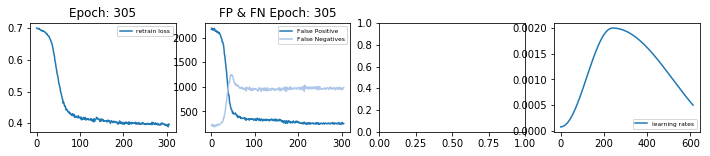

Epoch 306 started.
Retrain dataset size(s): 7774



Epoch 306 completed.
Retrain metrics
_________________________________________ METRICS for epoch 306 _______________________________________________________
accuracy         :0.84037   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81985   bmark:(0.8974)  sen.beaten:False
specificity      :0.88884   bmark:(0.7601)  spe.beaten:True
mcc              :0.66389   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4478  | fp:257  |
| fn:984  | tn:2055 |
---------------------
Epoch 307 started.
Retrain dataset size(s): 7774



Epoch 307 completed.
Retrain metrics
_________________________________________ METRICS for epoch 307 _______________________________________________________
accuracy         :0.84358   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82369   bmark:(0.8974)  sen.beaten:False
specificity      :0.89057   bmark:(0.7601)  spe.beaten:True
mcc              :0.66979   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4499  | fp:253  |
| fn:963  | tn:2059 |
---------------------
Epoch 308 started.
Retrain dataset size(s): 7774



Epoch 308 completed.
Retrain metrics
_________________________________________ METRICS for epoch 308 _______________________________________________________
accuracy         :0.84461   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82461   bmark:(0.8974)  sen.beaten:False
specificity      :0.89187   bmark:(0.7601)  spe.beaten:True
mcc              :0.67195   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4504  | fp:250  |
| fn:958  | tn:2062 |
---------------------
Epoch 309 started.
Retrain dataset size(s): 7774



Epoch 309 completed.
Retrain metrics
_________________________________________ METRICS for epoch 309 _______________________________________________________
accuracy         :0.84268   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82296   bmark:(0.8974)  sen.beaten:False
specificity      :0.88927   bmark:(0.7601)  spe.beaten:True
mcc              :0.66785   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4495  | fp:256  |
| fn:967  | tn:2056 |
---------------------
Epoch 310 started.
Retrain dataset size(s): 7774



Epoch 310 completed.
Retrain metrics
_________________________________________ METRICS for epoch 310 _______________________________________________________
accuracy         :0.84088   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82094   bmark:(0.8974)  sen.beaten:False
specificity      :0.88798   bmark:(0.7601)  spe.beaten:True
mcc              :0.66443   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4484  | fp:259  |
| fn:978  | tn:2053 |
---------------------


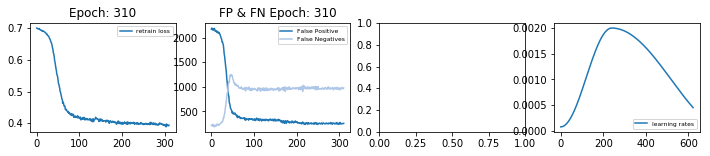

Epoch 311 started.
Retrain dataset size(s): 7774



Epoch 311 completed.
Retrain metrics
_________________________________________ METRICS for epoch 311 _______________________________________________________
accuracy         :0.84165   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82314   bmark:(0.8974)  sen.beaten:False
specificity      :0.88538   bmark:(0.7601)  spe.beaten:True
mcc              :0.66477   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4496  | fp:265  |
| fn:966  | tn:2047 |
---------------------
Epoch 312 started.
Retrain dataset size(s): 7774



Epoch 312 completed.
Retrain metrics
_________________________________________ METRICS for epoch 312 _______________________________________________________
accuracy         :0.84654   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82699   bmark:(0.8974)  sen.beaten:False
specificity      :0.89273   bmark:(0.7601)  spe.beaten:True
mcc              :0.67545   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4517  | fp:248  |
| fn:945  | tn:2064 |
---------------------
Epoch 313 started.
Retrain dataset size(s): 7774



Epoch 313 completed.
Retrain metrics
_________________________________________ METRICS for epoch 313 _______________________________________________________
accuracy         :0.84448   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82589   bmark:(0.8974)  sen.beaten:False
specificity      :0.88841   bmark:(0.7601)  spe.beaten:True
mcc              :0.67052   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4511  | fp:258  |
| fn:951  | tn:2054 |
---------------------
Epoch 314 started.
Retrain dataset size(s): 7774



Epoch 314 completed.
Retrain metrics
_________________________________________ METRICS for epoch 314 _______________________________________________________
accuracy         :0.83998   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82241   bmark:(0.8974)  sen.beaten:False
specificity      :0.88149   bmark:(0.7601)  spe.beaten:True
mcc              :0.66064   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4492  | fp:274  |
| fn:970  | tn:2038 |
---------------------
Epoch 315 started.
Retrain dataset size(s): 7774



Epoch 315 completed.
Retrain metrics
_________________________________________ METRICS for epoch 315 _______________________________________________________
accuracy         :0.84744   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82827   bmark:(0.8974)  sen.beaten:False
specificity      :0.89273   bmark:(0.7601)  spe.beaten:True
mcc              :0.67694   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4524  | fp:248  |
| fn:938  | tn:2064 |
---------------------


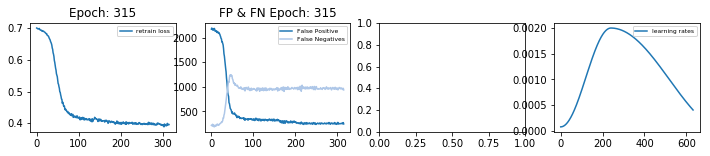

Epoch 316 started.
Retrain dataset size(s): 7774



Epoch 316 completed.
Retrain metrics
_________________________________________ METRICS for epoch 316 _______________________________________________________
accuracy         :0.84229   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82149   bmark:(0.8974)  sen.beaten:False
specificity      :0.89144   bmark:(0.7601)  spe.beaten:True
mcc              :0.66799   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4487  | fp:251  |
| fn:975  | tn:2061 |
---------------------
Epoch 317 started.
Retrain dataset size(s): 7774



Epoch 317 completed.
Retrain metrics
_________________________________________ METRICS for epoch 317 _______________________________________________________
accuracy         :0.84242   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82094   bmark:(0.8974)  sen.beaten:False
specificity      :0.89317   bmark:(0.7601)  spe.beaten:True
mcc              :0.66882   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4484  | fp:247  |
| fn:978  | tn:2065 |
---------------------
Epoch 318 started.
Retrain dataset size(s): 7774



Epoch 318 completed.
Retrain metrics
_________________________________________ METRICS for epoch 318 _______________________________________________________
accuracy         :0.84332   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82351   bmark:(0.8974)  sen.beaten:False
specificity      :0.89014   bmark:(0.7601)  spe.beaten:True
mcc              :0.66922   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4498  | fp:254  |
| fn:964  | tn:2058 |
---------------------
Epoch 319 started.
Retrain dataset size(s): 7774



Epoch 319 completed.
Retrain metrics
_________________________________________ METRICS for epoch 319 _______________________________________________________
accuracy         :0.84217   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82332   bmark:(0.8974)  sen.beaten:False
specificity      :0.88668   bmark:(0.7601)  spe.beaten:True
mcc              :0.66608   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4497  | fp:262  |
| fn:965  | tn:2050 |
---------------------
Epoch 320 started.
Retrain dataset size(s): 7774



Epoch 320 completed.
Retrain metrics
_________________________________________ METRICS for epoch 320 _______________________________________________________
accuracy         :0.84294   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82278   bmark:(0.8974)  sen.beaten:False
specificity      :0.89057   bmark:(0.7601)  spe.beaten:True
mcc              :0.66874   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4494  | fp:253  |
| fn:968  | tn:2059 |
---------------------


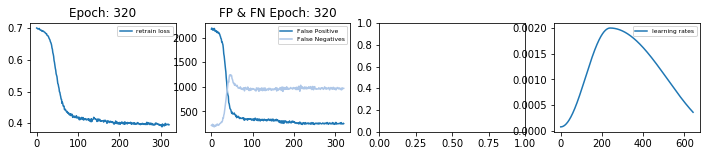

Epoch 321 started.
Retrain dataset size(s): 7774



Epoch 321 completed.
Retrain metrics
_________________________________________ METRICS for epoch 321 _______________________________________________________
accuracy         :0.84255   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82223   bmark:(0.8974)  sen.beaten:False
specificity      :0.89057   bmark:(0.7601)  spe.beaten:True
mcc              :0.66810   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4491  | fp:253  |
| fn:971  | tn:2059 |
---------------------
Epoch 322 started.
Retrain dataset size(s): 7774



Epoch 322 completed.
Retrain metrics
_________________________________________ METRICS for epoch 322 _______________________________________________________
accuracy         :0.84410   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82186   bmark:(0.8974)  sen.beaten:False
specificity      :0.89663   bmark:(0.7601)  spe.beaten:True
mcc              :0.67280   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4489  | fp:239  |
| fn:973  | tn:2073 |
---------------------
Epoch 323 started.
Retrain dataset size(s): 7774



Epoch 323 completed.
Retrain metrics
_________________________________________ METRICS for epoch 323 _______________________________________________________
accuracy         :0.84564   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82442   bmark:(0.8974)  sen.beaten:False
specificity      :0.89576   bmark:(0.7601)  spe.beaten:True
mcc              :0.67503   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4503  | fp:241  |
| fn:959  | tn:2071 |
---------------------
Epoch 324 started.
Retrain dataset size(s): 7774



Epoch 324 completed.
Retrain metrics
_________________________________________ METRICS for epoch 324 _______________________________________________________
accuracy         :0.84268   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82497   bmark:(0.8974)  sen.beaten:False
specificity      :0.88452   bmark:(0.7601)  spe.beaten:True
mcc              :0.66617   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4506  | fp:267  |
| fn:956  | tn:2045 |
---------------------
Epoch 325 started.
Retrain dataset size(s): 7774



Epoch 325 completed.
Retrain metrics
_________________________________________ METRICS for epoch 325 _______________________________________________________
accuracy         :0.84320   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82406   bmark:(0.8974)  sen.beaten:False
specificity      :0.88841   bmark:(0.7601)  spe.beaten:True
mcc              :0.66839   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4501  | fp:258  |
| fn:961  | tn:2054 |
---------------------


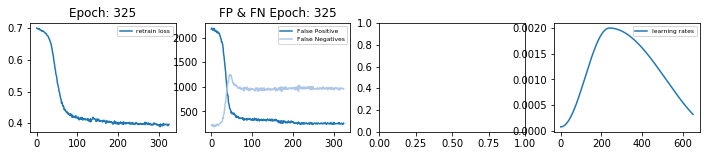

Epoch 326 started.
Retrain dataset size(s): 7774



Epoch 326 completed.
Retrain metrics
_________________________________________ METRICS for epoch 326 _______________________________________________________
accuracy         :0.84500   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82552   bmark:(0.8974)  sen.beaten:False
specificity      :0.89100   bmark:(0.7601)  spe.beaten:True
mcc              :0.67228   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4509  | fp:252  |
| fn:953  | tn:2060 |
---------------------
Epoch 327 started.
Retrain dataset size(s): 7774



Epoch 327 completed.
Retrain metrics
_________________________________________ METRICS for epoch 327 _______________________________________________________
accuracy         :0.84101   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81948   bmark:(0.8974)  sen.beaten:False
specificity      :0.89187   bmark:(0.7601)  spe.beaten:True
mcc              :0.66604   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4476  | fp:250  |
| fn:986  | tn:2062 |
---------------------
Epoch 328 started.
Retrain dataset size(s): 7774



Epoch 328 completed.
Retrain metrics
_________________________________________ METRICS for epoch 328 _______________________________________________________
accuracy         :0.84564   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82680   bmark:(0.8974)  sen.beaten:False
specificity      :0.89014   bmark:(0.7601)  spe.beaten:True
mcc              :0.67305   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4516  | fp:254  |
| fn:946  | tn:2058 |
---------------------
Epoch 329 started.
Retrain dataset size(s): 7774



Epoch 329 completed.
Retrain metrics
_________________________________________ METRICS for epoch 329 _______________________________________________________
accuracy         :0.84525   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82717   bmark:(0.8974)  sen.beaten:False
specificity      :0.88798   bmark:(0.7601)  spe.beaten:True
mcc              :0.67165   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4518  | fp:259  |
| fn:944  | tn:2053 |
---------------------
Epoch 330 started.
Retrain dataset size(s): 7774



Epoch 330 completed.
Retrain metrics
_________________________________________ METRICS for epoch 330 _______________________________________________________
accuracy         :0.84448   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82625   bmark:(0.8974)  sen.beaten:False
specificity      :0.88754   bmark:(0.7601)  spe.beaten:True
mcc              :0.67022   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4513  | fp:260  |
| fn:949  | tn:2052 |
---------------------


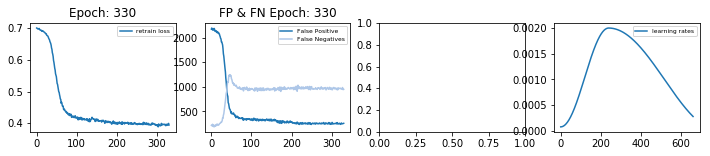

Epoch 331 started.
Retrain dataset size(s): 7774



Epoch 331 completed.
Retrain metrics
_________________________________________ METRICS for epoch 331 _______________________________________________________
accuracy         :0.84384   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82552   bmark:(0.8974)  sen.beaten:False
specificity      :0.88711   bmark:(0.7601)  spe.beaten:True
mcc              :0.66900   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4509  | fp:261  |
| fn:953  | tn:2051 |
---------------------
Epoch 332 started.
Retrain dataset size(s): 7774



Epoch 332 completed.
Retrain metrics
_________________________________________ METRICS for epoch 332 _______________________________________________________
accuracy         :0.84204   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82314   bmark:(0.8974)  sen.beaten:False
specificity      :0.88668   bmark:(0.7601)  spe.beaten:True
mcc              :0.66587   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4496  | fp:262  |
| fn:966  | tn:2050 |
---------------------
Epoch 333 started.
Retrain dataset size(s): 7774



Epoch 333 completed.
Retrain metrics
_________________________________________ METRICS for epoch 333 _______________________________________________________
accuracy         :0.84384   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82479   bmark:(0.8974)  sen.beaten:False
specificity      :0.88884   bmark:(0.7601)  spe.beaten:True
mcc              :0.66961   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4505  | fp:257  |
| fn:957  | tn:2055 |
---------------------
Epoch 334 started.
Retrain dataset size(s): 7774



Epoch 334 completed.
Retrain metrics
_________________________________________ METRICS for epoch 334 _______________________________________________________
accuracy         :0.84268   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82387   bmark:(0.8974)  sen.beaten:False
specificity      :0.88711   bmark:(0.7601)  spe.beaten:True
mcc              :0.66709   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4500  | fp:261  |
| fn:962  | tn:2051 |
---------------------
Epoch 335 started.
Retrain dataset size(s): 7774



Epoch 335 completed.
Retrain metrics
_________________________________________ METRICS for epoch 335 _______________________________________________________
accuracy         :0.84152   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82149   bmark:(0.8974)  sen.beaten:False
specificity      :0.88884   bmark:(0.7601)  spe.beaten:True
mcc              :0.66579   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4487  | fp:257  |
| fn:975  | tn:2055 |
---------------------


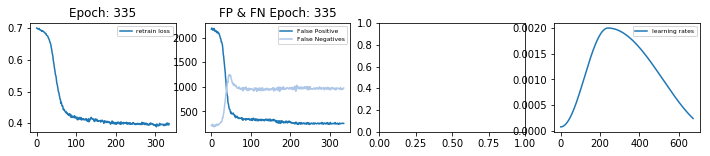

Epoch 336 started.
Retrain dataset size(s): 7774



Epoch 336 completed.
Retrain metrics
_________________________________________ METRICS for epoch 336 _______________________________________________________
accuracy         :0.84371   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82131   bmark:(0.8974)  sen.beaten:False
specificity      :0.89663   bmark:(0.7601)  spe.beaten:True
mcc              :0.67217   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4486  | fp:239  |
| fn:976  | tn:2073 |
---------------------
Epoch 337 started.
Retrain dataset size(s): 7774



Epoch 337 completed.
Retrain metrics
_________________________________________ METRICS for epoch 337 _______________________________________________________
accuracy         :0.84603   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82406   bmark:(0.8974)  sen.beaten:False
specificity      :0.89792   bmark:(0.7601)  spe.beaten:True
mcc              :0.67643   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4501  | fp:236  |
| fn:961  | tn:2076 |
---------------------
Epoch 338 started.
Retrain dataset size(s): 7774



Epoch 338 completed.
Retrain metrics
_________________________________________ METRICS for epoch 338 _______________________________________________________
accuracy         :0.84294   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82204   bmark:(0.8974)  sen.beaten:False
specificity      :0.89230   bmark:(0.7601)  spe.beaten:True
mcc              :0.66935   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4490  | fp:249  |
| fn:972  | tn:2063 |
---------------------
Epoch 339 started.
Retrain dataset size(s): 7774



Epoch 339 completed.
Retrain metrics
_________________________________________ METRICS for epoch 339 _______________________________________________________
accuracy         :0.84461   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82351   bmark:(0.8974)  sen.beaten:False
specificity      :0.89446   bmark:(0.7601)  spe.beaten:True
mcc              :0.67287   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4498  | fp:244  |
| fn:964  | tn:2068 |
---------------------
Epoch 340 started.
Retrain dataset size(s): 7774



Epoch 340 completed.
Retrain metrics
_________________________________________ METRICS for epoch 340 _______________________________________________________
accuracy         :0.84191   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82204   bmark:(0.8974)  sen.beaten:False
specificity      :0.88884   bmark:(0.7601)  spe.beaten:True
mcc              :0.66643   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4490  | fp:257  |
| fn:972  | tn:2055 |
---------------------


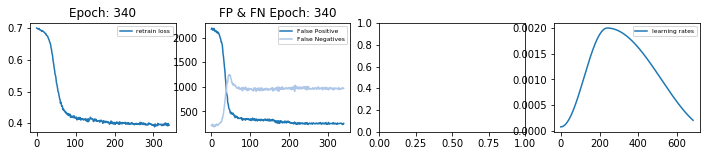

Epoch 341 started.
Retrain dataset size(s): 7774



Epoch 341 completed.
Retrain metrics
_________________________________________ METRICS for epoch 341 _______________________________________________________
accuracy         :0.84603   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82607   bmark:(0.8974)  sen.beaten:False
specificity      :0.89317   bmark:(0.7601)  spe.beaten:True
mcc              :0.67475   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4512  | fp:247  |
| fn:950  | tn:2065 |
---------------------
Epoch 342 started.
Retrain dataset size(s): 7774



Epoch 342 completed.
Retrain metrics
_________________________________________ METRICS for epoch 342 _______________________________________________________
accuracy         :0.84229   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82186   bmark:(0.8974)  sen.beaten:False
specificity      :0.89057   bmark:(0.7601)  spe.beaten:True
mcc              :0.66768   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4489  | fp:253  |
| fn:973  | tn:2059 |
---------------------
Epoch 343 started.
Retrain dataset size(s): 7774



Epoch 343 completed.
Retrain metrics
_________________________________________ METRICS for epoch 343 _______________________________________________________
accuracy         :0.84397   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82369   bmark:(0.8974)  sen.beaten:False
specificity      :0.89187   bmark:(0.7601)  spe.beaten:True
mcc              :0.67089   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4499  | fp:250  |
| fn:963  | tn:2062 |
---------------------
Epoch 344 started.
Retrain dataset size(s): 7774



Epoch 344 completed.
Retrain metrics
_________________________________________ METRICS for epoch 344 _______________________________________________________
accuracy         :0.84667   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82937   bmark:(0.8974)  sen.beaten:False
specificity      :0.88754   bmark:(0.7601)  spe.beaten:True
mcc              :0.67386   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4530  | fp:260  |
| fn:932  | tn:2052 |
---------------------
Epoch 345 started.
Retrain dataset size(s): 7774



Epoch 345 completed.
Retrain metrics
_________________________________________ METRICS for epoch 345 _______________________________________________________
accuracy         :0.84461   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82497   bmark:(0.8974)  sen.beaten:False
specificity      :0.89100   bmark:(0.7601)  spe.beaten:True
mcc              :0.67165   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4506  | fp:252  |
| fn:956  | tn:2060 |
---------------------


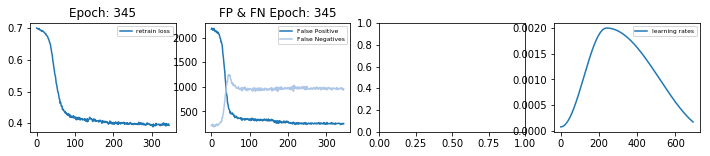

Epoch 346 started.
Retrain dataset size(s): 7774



Epoch 346 completed.
Retrain metrics
_________________________________________ METRICS for epoch 346 _______________________________________________________
accuracy         :0.84512   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82314   bmark:(0.8974)  sen.beaten:False
specificity      :0.89706   bmark:(0.7601)  spe.beaten:True
mcc              :0.67464   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4496  | fp:238  |
| fn:966  | tn:2074 |
---------------------
Epoch 347 started.
Retrain dataset size(s): 7774



Epoch 347 completed.
Retrain metrics
_________________________________________ METRICS for epoch 347 _______________________________________________________
accuracy         :0.84461   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82259   bmark:(0.8974)  sen.beaten:False
specificity      :0.89663   bmark:(0.7601)  spe.beaten:True
mcc              :0.67364   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4493  | fp:239  |
| fn:969  | tn:2073 |
---------------------
Epoch 348 started.
Retrain dataset size(s): 7774



Epoch 348 completed.
Retrain metrics
_________________________________________ METRICS for epoch 348 _______________________________________________________
accuracy         :0.84268   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82058   bmark:(0.8974)  sen.beaten:False
specificity      :0.89490   bmark:(0.7601)  spe.beaten:True
mcc              :0.66986   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4482  | fp:243  |
| fn:980  | tn:2069 |
---------------------
Epoch 349 started.
Retrain dataset size(s): 7774



Epoch 349 completed.
Retrain metrics
_________________________________________ METRICS for epoch 349 _______________________________________________________
accuracy         :0.84255   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82278   bmark:(0.8974)  sen.beaten:False
specificity      :0.88927   bmark:(0.7601)  spe.beaten:True
mcc              :0.66764   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4494  | fp:256  |
| fn:968  | tn:2056 |
---------------------
Epoch 350 started.
Retrain dataset size(s): 7774



Epoch 350 completed.
Retrain metrics
_________________________________________ METRICS for epoch 350 _______________________________________________________
accuracy         :0.84332   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82259   bmark:(0.8974)  sen.beaten:False
specificity      :0.89230   bmark:(0.7601)  spe.beaten:True
mcc              :0.66999   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4493  | fp:249  |
| fn:969  | tn:2063 |
---------------------


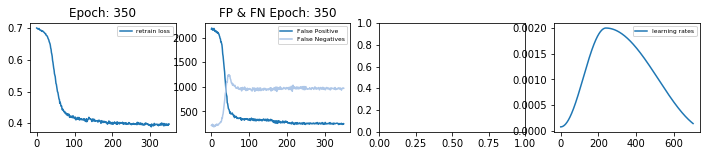

Epoch 351 started.
Retrain dataset size(s): 7774



Epoch 351 completed.
Retrain metrics
_________________________________________ METRICS for epoch 351 _______________________________________________________
accuracy         :0.84474   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82442   bmark:(0.8974)  sen.beaten:False
specificity      :0.89273   bmark:(0.7601)  spe.beaten:True
mcc              :0.67247   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4503  | fp:248  |
| fn:959  | tn:2064 |
---------------------
Epoch 352 started.
Retrain dataset size(s): 7774



Epoch 352 completed.
Retrain metrics
_________________________________________ METRICS for epoch 352 _______________________________________________________
accuracy         :0.84435   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82241   bmark:(0.8974)  sen.beaten:False
specificity      :0.89619   bmark:(0.7601)  spe.beaten:True
mcc              :0.67306   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4492  | fp:240  |
| fn:970  | tn:2072 |
---------------------
Epoch 353 started.
Retrain dataset size(s): 7774



Epoch 353 completed.
Retrain metrics
_________________________________________ METRICS for epoch 353 _______________________________________________________
accuracy         :0.84577   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82387   bmark:(0.8974)  sen.beaten:False
specificity      :0.89749   bmark:(0.7601)  spe.beaten:True
mcc              :0.67585   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4500  | fp:237  |
| fn:962  | tn:2075 |
---------------------
Epoch 354 started.
Retrain dataset size(s): 7774



Epoch 354 completed.
Retrain metrics
_________________________________________ METRICS for epoch 354 _______________________________________________________
accuracy         :0.84178   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82296   bmark:(0.8974)  sen.beaten:False
specificity      :0.88625   bmark:(0.7601)  spe.beaten:True
mcc              :0.66529   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4495  | fp:263  |
| fn:967  | tn:2049 |
---------------------
Epoch 355 started.
Retrain dataset size(s): 7774



Epoch 355 completed.
Retrain metrics
_________________________________________ METRICS for epoch 355 _______________________________________________________
accuracy         :0.84448   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82534   bmark:(0.8974)  sen.beaten:False
specificity      :0.88971   bmark:(0.7601)  spe.beaten:True
mcc              :0.67098   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4508  | fp:255  |
| fn:954  | tn:2057 |
---------------------


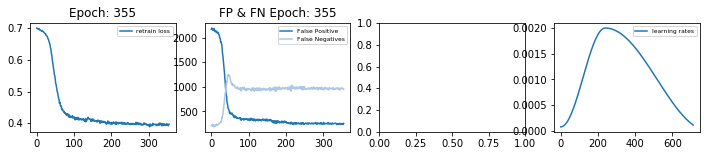

Epoch 356 started.
Retrain dataset size(s): 7774



Epoch 356 completed.
Retrain metrics
_________________________________________ METRICS for epoch 356 _______________________________________________________
accuracy         :0.84564   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82461   bmark:(0.8974)  sen.beaten:False
specificity      :0.89533   bmark:(0.7601)  spe.beaten:True
mcc              :0.67487   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4504  | fp:242  |
| fn:958  | tn:2070 |
---------------------
Epoch 357 started.
Retrain dataset size(s): 7774



Epoch 357 completed.
Retrain metrics
_________________________________________ METRICS for epoch 357 _______________________________________________________
accuracy         :0.84101   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82278   bmark:(0.8974)  sen.beaten:False
specificity      :0.88408   bmark:(0.7601)  spe.beaten:True
mcc              :0.66325   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4494  | fp:268  |
| fn:968  | tn:2044 |
---------------------
Epoch 358 started.
Retrain dataset size(s): 7774



Epoch 358 completed.
Retrain metrics
_________________________________________ METRICS for epoch 358 _______________________________________________________
accuracy         :0.84152   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82168   bmark:(0.8974)  sen.beaten:False
specificity      :0.88841   bmark:(0.7601)  spe.beaten:True
mcc              :0.66564   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4488  | fp:258  |
| fn:974  | tn:2054 |
---------------------
Epoch 359 started.
Retrain dataset size(s): 7774



Epoch 359 completed.
Retrain metrics
_________________________________________ METRICS for epoch 359 _______________________________________________________
accuracy         :0.84422   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82332   bmark:(0.8974)  sen.beaten:False
specificity      :0.89360   bmark:(0.7601)  spe.beaten:True
mcc              :0.67193   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4497  | fp:246  |
| fn:965  | tn:2066 |
---------------------
Epoch 360 started.
Retrain dataset size(s): 7774



Epoch 360 completed.
Retrain metrics
_________________________________________ METRICS for epoch 360 _______________________________________________________
accuracy         :0.84512   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82406   bmark:(0.8974)  sen.beaten:False
specificity      :0.89490   bmark:(0.7601)  spe.beaten:True
mcc              :0.67387   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4501  | fp:243  |
| fn:961  | tn:2069 |
---------------------


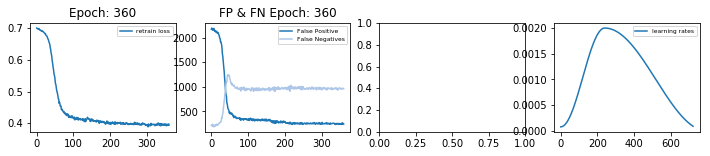

Epoch 361 started.
Retrain dataset size(s): 7774



Epoch 361 completed.
Retrain metrics
_________________________________________ METRICS for epoch 361 _______________________________________________________
accuracy         :0.84577   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82351   bmark:(0.8974)  sen.beaten:False
specificity      :0.89836   bmark:(0.7601)  spe.beaten:True
mcc              :0.67616   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4498  | fp:235  |
| fn:964  | tn:2077 |
---------------------
Epoch 362 started.
Retrain dataset size(s): 7774



Epoch 362 completed.
Retrain metrics
_________________________________________ METRICS for epoch 362 _______________________________________________________
accuracy         :0.84564   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82662   bmark:(0.8974)  sen.beaten:False
specificity      :0.89057   bmark:(0.7601)  spe.beaten:True
mcc              :0.67320   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4515  | fp:253  |
| fn:947  | tn:2059 |
---------------------
Epoch 363 started.
Retrain dataset size(s): 7774



Epoch 363 completed.
Retrain metrics
_________________________________________ METRICS for epoch 363 _______________________________________________________
accuracy         :0.84320   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82351   bmark:(0.8974)  sen.beaten:False
specificity      :0.88971   bmark:(0.7601)  spe.beaten:True
mcc              :0.66885   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4498  | fp:255  |
| fn:964  | tn:2057 |
---------------------
Epoch 364 started.
Retrain dataset size(s): 7774



Epoch 364 completed.
Retrain metrics
_________________________________________ METRICS for epoch 364 _______________________________________________________
accuracy         :0.84268   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82369   bmark:(0.8974)  sen.beaten:False
specificity      :0.88754   bmark:(0.7601)  spe.beaten:True
mcc              :0.66724   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4499  | fp:260  |
| fn:963  | tn:2052 |
---------------------
Epoch 365 started.
Retrain dataset size(s): 7774



Epoch 365 completed.
Retrain metrics
_________________________________________ METRICS for epoch 365 _______________________________________________________
accuracy         :0.84525   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82790   bmark:(0.8974)  sen.beaten:False
specificity      :0.88625   bmark:(0.7601)  spe.beaten:True
mcc              :0.67105   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4522  | fp:263  |
| fn:940  | tn:2049 |
---------------------


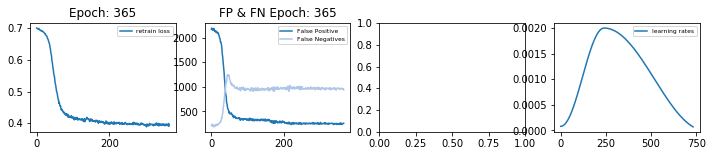

Epoch 366 started.
Retrain dataset size(s): 7774



Epoch 366 completed.
Retrain metrics
_________________________________________ METRICS for epoch 366 _______________________________________________________
accuracy         :0.84500   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82644   bmark:(0.8974)  sen.beaten:False
specificity      :0.88884   bmark:(0.7601)  spe.beaten:True
mcc              :0.67153   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4514  | fp:257  |
| fn:948  | tn:2055 |
---------------------
Epoch 367 started.
Retrain dataset size(s): 7774



Epoch 367 completed.
Retrain metrics
_________________________________________ METRICS for epoch 367 _______________________________________________________
accuracy         :0.84873   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82937   bmark:(0.8974)  sen.beaten:False
specificity      :0.89446   bmark:(0.7601)  spe.beaten:True
mcc              :0.67968   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4530  | fp:244  |
| fn:932  | tn:2068 |
---------------------
Epoch 368 started.
Retrain dataset size(s): 7774



Epoch 368 completed.
Retrain metrics
_________________________________________ METRICS for epoch 368 _______________________________________________________
accuracy         :0.84770   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82790   bmark:(0.8974)  sen.beaten:False
specificity      :0.89446   bmark:(0.7601)  spe.beaten:True
mcc              :0.67797   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4522  | fp:244  |
| fn:940  | tn:2068 |
---------------------
Epoch 369 started.
Retrain dataset size(s): 7774



Epoch 369 completed.
Retrain metrics
_________________________________________ METRICS for epoch 369 _______________________________________________________
accuracy         :0.84281   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82314   bmark:(0.8974)  sen.beaten:False
specificity      :0.88927   bmark:(0.7601)  spe.beaten:True
mcc              :0.66806   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4496  | fp:256  |
| fn:966  | tn:2056 |
---------------------
Epoch 370 started.
Retrain dataset size(s): 7774



Epoch 370 completed.
Retrain metrics
_________________________________________ METRICS for epoch 370 _______________________________________________________
accuracy         :0.84564   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82699   bmark:(0.8974)  sen.beaten:False
specificity      :0.88971   bmark:(0.7601)  spe.beaten:True
mcc              :0.67289   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4517  | fp:255  |
| fn:945  | tn:2057 |
---------------------


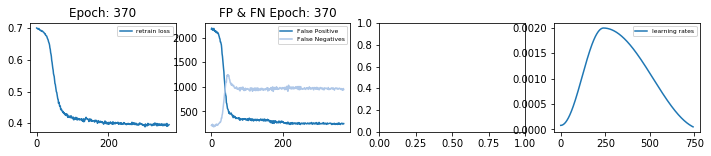

Epoch 371 started.
Retrain dataset size(s): 7774



Epoch 371 completed.
Retrain metrics
_________________________________________ METRICS for epoch 371 _______________________________________________________
accuracy         :0.84371   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82424   bmark:(0.8974)  sen.beaten:False
specificity      :0.88971   bmark:(0.7601)  spe.beaten:True
mcc              :0.66970   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4502  | fp:255  |
| fn:960  | tn:2057 |
---------------------
Epoch 372 started.
Retrain dataset size(s): 7774



Epoch 372 completed.
Retrain metrics
_________________________________________ METRICS for epoch 372 _______________________________________________________
accuracy         :0.84011   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82094   bmark:(0.8974)  sen.beaten:False
specificity      :0.88538   bmark:(0.7601)  spe.beaten:True
mcc              :0.66223   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4484  | fp:265  |
| fn:978  | tn:2047 |
---------------------
Epoch 373 started.
Retrain dataset size(s): 7774



Epoch 373 completed.
Retrain metrics
_________________________________________ METRICS for epoch 373 _______________________________________________________
accuracy         :0.84603   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82918   bmark:(0.8974)  sen.beaten:False
specificity      :0.88581   bmark:(0.7601)  spe.beaten:True
mcc              :0.67219   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4529  | fp:264  |
| fn:933  | tn:2048 |
---------------------
Epoch 374 started.
Retrain dataset size(s): 7774



Epoch 374 completed.
Retrain metrics
_________________________________________ METRICS for epoch 374 _______________________________________________________
accuracy         :0.84255   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82076   bmark:(0.8974)  sen.beaten:False
specificity      :0.89403   bmark:(0.7601)  spe.beaten:True
mcc              :0.66934   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4483  | fp:245  |
| fn:979  | tn:2067 |
---------------------
Epoch 375 started.
Retrain dataset size(s): 7774



Epoch 375 completed.
Retrain metrics
_________________________________________ METRICS for epoch 375 _______________________________________________________
accuracy         :0.84500   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82497   bmark:(0.8974)  sen.beaten:False
specificity      :0.89230   bmark:(0.7601)  spe.beaten:True
mcc              :0.67274   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4506  | fp:249  |
| fn:956  | tn:2063 |
---------------------


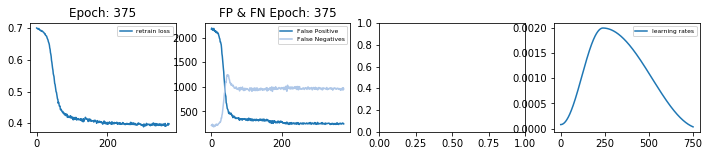

Epoch 376 started.
Retrain dataset size(s): 7774



Epoch 376 completed.
Retrain metrics
_________________________________________ METRICS for epoch 376 _______________________________________________________
accuracy         :0.84178   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82003   bmark:(0.8974)  sen.beaten:False
specificity      :0.89317   bmark:(0.7601)  spe.beaten:True
mcc              :0.66777   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4479  | fp:247  |
| fn:983  | tn:2065 |
---------------------
Epoch 377 started.
Retrain dataset size(s): 7774



Epoch 377 completed.
Retrain metrics
_________________________________________ METRICS for epoch 377 _______________________________________________________
accuracy         :0.84628   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82552   bmark:(0.8974)  sen.beaten:False
specificity      :0.89533   bmark:(0.7601)  spe.beaten:True
mcc              :0.67593   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4509  | fp:242  |
| fn:953  | tn:2070 |
---------------------
Epoch 378 started.
Retrain dataset size(s): 7774



Epoch 378 completed.
Retrain metrics
_________________________________________ METRICS for epoch 378 _______________________________________________________
accuracy         :0.84564   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82461   bmark:(0.8974)  sen.beaten:False
specificity      :0.89533   bmark:(0.7601)  spe.beaten:True
mcc              :0.67487   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4504  | fp:242  |
| fn:958  | tn:2070 |
---------------------
Epoch 379 started.
Retrain dataset size(s): 7774



Epoch 379 completed.
Retrain metrics
_________________________________________ METRICS for epoch 379 _______________________________________________________
accuracy         :0.84384   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82479   bmark:(0.8974)  sen.beaten:False
specificity      :0.88884   bmark:(0.7601)  spe.beaten:True
mcc              :0.66961   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4505  | fp:257  |
| fn:957  | tn:2055 |
---------------------
Epoch 380 started.
Retrain dataset size(s): 7774



Epoch 380 completed.
Retrain metrics
_________________________________________ METRICS for epoch 380 _______________________________________________________
accuracy         :0.84320   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82461   bmark:(0.8974)  sen.beaten:False
specificity      :0.88711   bmark:(0.7601)  spe.beaten:True
mcc              :0.66794   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4504  | fp:261  |
| fn:958  | tn:2051 |
---------------------


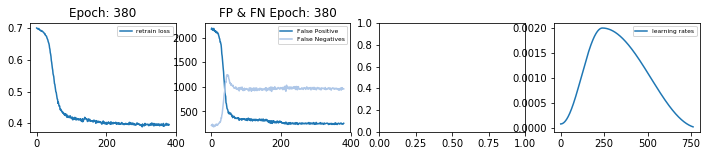

Epoch 381 started.
Retrain dataset size(s): 7774



Epoch 381 completed.
Retrain metrics
_________________________________________ METRICS for epoch 381 _______________________________________________________
accuracy         :0.84525   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82497   bmark:(0.8974)  sen.beaten:False
specificity      :0.89317   bmark:(0.7601)  spe.beaten:True
mcc              :0.67347   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4506  | fp:247  |
| fn:956  | tn:2065 |
---------------------
Epoch 382 started.
Retrain dataset size(s): 7774



Epoch 382 completed.
Retrain metrics
_________________________________________ METRICS for epoch 382 _______________________________________________________
accuracy         :0.84500   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82369   bmark:(0.8974)  sen.beaten:False
specificity      :0.89533   bmark:(0.7601)  spe.beaten:True
mcc              :0.67381   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4499  | fp:242  |
| fn:963  | tn:2070 |
---------------------
Epoch 383 started.
Retrain dataset size(s): 7774



Epoch 383 completed.
Retrain metrics
_________________________________________ METRICS for epoch 383 _______________________________________________________
accuracy         :0.84731   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82662   bmark:(0.8974)  sen.beaten:False
specificity      :0.89619   bmark:(0.7601)  spe.beaten:True
mcc              :0.67794   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4515  | fp:240  |
| fn:947  | tn:2072 |
---------------------
Epoch 384 started.
Retrain dataset size(s): 7774



Epoch 384 completed.
Retrain metrics
_________________________________________ METRICS for epoch 384 _______________________________________________________
accuracy         :0.84551   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82607   bmark:(0.8974)  sen.beaten:False
specificity      :0.89144   bmark:(0.7601)  spe.beaten:True
mcc              :0.67329   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4512  | fp:251  |
| fn:950  | tn:2061 |
---------------------
Epoch 385 started.
Retrain dataset size(s): 7774



Epoch 385 completed.
Retrain metrics
_________________________________________ METRICS for epoch 385 _______________________________________________________
accuracy         :0.84358   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82387   bmark:(0.8974)  sen.beaten:False
specificity      :0.89014   bmark:(0.7601)  spe.beaten:True
mcc              :0.66964   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4500  | fp:254  |
| fn:962  | tn:2058 |
---------------------


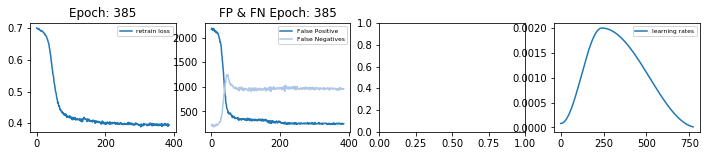

Epoch 386 started.
Retrain dataset size(s): 7774



Epoch 386 completed.
Retrain metrics
_________________________________________ METRICS for epoch 386 _______________________________________________________
accuracy         :0.84281   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82168   bmark:(0.8974)  sen.beaten:False
specificity      :0.89273   bmark:(0.7601)  spe.beaten:True
mcc              :0.66930   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4488  | fp:248  |
| fn:974  | tn:2064 |
---------------------
Epoch 387 started.
Retrain dataset size(s): 7774



Epoch 387 completed.
Retrain metrics
_________________________________________ METRICS for epoch 387 _______________________________________________________
accuracy         :0.84320   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82332   bmark:(0.8974)  sen.beaten:False
specificity      :0.89014   bmark:(0.7601)  spe.beaten:True
mcc              :0.66901   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4497  | fp:254  |
| fn:965  | tn:2058 |
---------------------
Epoch 388 started.
Retrain dataset size(s): 7774



Epoch 388 completed.
Retrain metrics
_________________________________________ METRICS for epoch 388 _______________________________________________________
accuracy         :0.84435   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82406   bmark:(0.8974)  sen.beaten:False
specificity      :0.89230   bmark:(0.7601)  spe.beaten:True
mcc              :0.67168   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4501  | fp:249  |
| fn:961  | tn:2063 |
---------------------
Epoch 389 started.
Retrain dataset size(s): 7774



Epoch 389 completed.
Retrain metrics
_________________________________________ METRICS for epoch 389 _______________________________________________________
accuracy         :0.84718   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82900   bmark:(0.8974)  sen.beaten:False
specificity      :0.89014   bmark:(0.7601)  spe.beaten:True
mcc              :0.67561   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4528  | fp:254  |
| fn:934  | tn:2058 |
---------------------
Epoch 390 started.
Retrain dataset size(s): 7774



Epoch 390 completed.
Retrain metrics
_________________________________________ METRICS for epoch 390 _______________________________________________________
accuracy         :0.84577   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82570   bmark:(0.8974)  sen.beaten:False
specificity      :0.89317   bmark:(0.7601)  spe.beaten:True
mcc              :0.67432   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4510  | fp:247  |
| fn:952  | tn:2065 |
---------------------


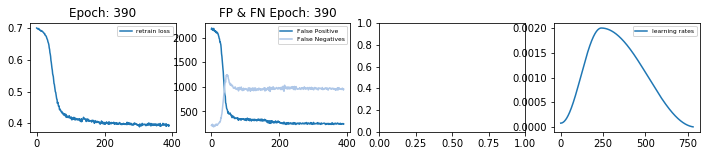

Epoch 391 started.
Retrain dataset size(s): 7774



Epoch 391 completed.
Retrain metrics
_________________________________________ METRICS for epoch 391 _______________________________________________________
accuracy         :0.84512   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82461   bmark:(0.8974)  sen.beaten:False
specificity      :0.89360   bmark:(0.7601)  spe.beaten:True
mcc              :0.67341   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4504  | fp:246  |
| fn:958  | tn:2066 |
---------------------
Epoch 392 started.
Retrain dataset size(s): 7774



Epoch 392 completed.
Retrain metrics
_________________________________________ METRICS for epoch 392 _______________________________________________________
accuracy         :0.83998   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.81802   bmark:(0.8974)  sen.beaten:False
specificity      :0.89187   bmark:(0.7601)  spe.beaten:True
mcc              :0.66436   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4468  | fp:250  |
| fn:994  | tn:2062 |
---------------------
Epoch 393 started.
Retrain dataset size(s): 7774



Epoch 393 completed.
Retrain metrics
_________________________________________ METRICS for epoch 393 _______________________________________________________
accuracy         :0.84294   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82296   bmark:(0.8974)  sen.beaten:False
specificity      :0.89014   bmark:(0.7601)  spe.beaten:True
mcc              :0.66858   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4495  | fp:254  |
| fn:967  | tn:2058 |
---------------------
Epoch 394 started.
Retrain dataset size(s): 7774



Epoch 394 completed.
Retrain metrics
_________________________________________ METRICS for epoch 394 _______________________________________________________
accuracy         :0.84474   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82406   bmark:(0.8974)  sen.beaten:False
specificity      :0.89360   bmark:(0.7601)  spe.beaten:True
mcc              :0.67278   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4501  | fp:246  |
| fn:961  | tn:2066 |
---------------------
Epoch 395 started.
Retrain dataset size(s): 7774



Epoch 395 completed.
Retrain metrics
_________________________________________ METRICS for epoch 395 _______________________________________________________
accuracy         :0.84525   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82442   bmark:(0.8974)  sen.beaten:False
specificity      :0.89446   bmark:(0.7601)  spe.beaten:True
mcc              :0.67393   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4503  | fp:244  |
| fn:959  | tn:2068 |
---------------------


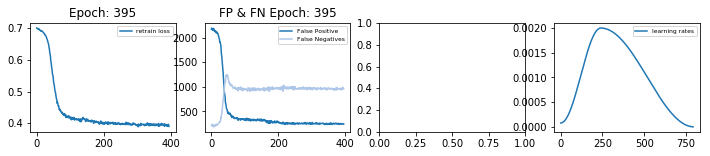

Epoch 396 started.
Retrain dataset size(s): 7774



Epoch 396 completed.
Retrain metrics
_________________________________________ METRICS for epoch 396 _______________________________________________________
accuracy         :0.84474   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82442   bmark:(0.8974)  sen.beaten:False
specificity      :0.89273   bmark:(0.7601)  spe.beaten:True
mcc              :0.67247   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4503  | fp:248  |
| fn:959  | tn:2064 |
---------------------
Epoch 397 started.
Retrain dataset size(s): 7774



Epoch 397 completed.
Retrain metrics
_________________________________________ METRICS for epoch 397 _______________________________________________________
accuracy         :0.84525   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82589   bmark:(0.8974)  sen.beaten:False
specificity      :0.89100   bmark:(0.7601)  spe.beaten:True
mcc              :0.67271   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4511  | fp:252  |
| fn:951  | tn:2060 |
---------------------
Epoch 398 started.
Retrain dataset size(s): 7774



Epoch 398 completed.
Retrain metrics
_________________________________________ METRICS for epoch 398 _______________________________________________________
accuracy         :0.84371   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82296   bmark:(0.8974)  sen.beaten:False
specificity      :0.89273   bmark:(0.7601)  spe.beaten:True
mcc              :0.67077   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4495  | fp:248  |
| fn:967  | tn:2064 |
---------------------
Epoch 399 started.
Retrain dataset size(s): 7774



Epoch 399 completed.
Retrain metrics
_________________________________________ METRICS for epoch 399 _______________________________________________________
accuracy         :0.84577   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.82552   bmark:(0.8974)  sen.beaten:False
specificity      :0.89360   bmark:(0.7601)  spe.beaten:True
mcc              :0.67447   bmark:(1.0000)  mcc.beaten:False
---------------------
| tp:4509  | fp:246  |
| fn:953  | tn:2066 |
---------------------


In [38]:
# best_fold_idx = 0
# best_model_filename = 'mdl_BioMLP_fold_00_ep_034_mcc_0.67554_sens_0.89331_spec_0.79017__03_03_48_0809.pkl'

# best_model_dir = model.getname() + f'/fold_{best_fold_idx:02d}'
# best_model_path = best_model_dir + '/' + best_model_filename 


#metrics_ht = Metrics(benchmark_acc = 0.8169, benchmark_f1 = 1.0, benchmark_spec = 0.8060, benchmark_sen = 0.8277, benchmark_auc = 1.0, benchmark_mcc = .6476)

if do_retraining or do_testing_only:

    retrain_metrics_ht = Metrics(**configs[config_name]['bmarks'])
    retrain_metrics_ht.reset_history()

    test_metrics_ht = Metrics(**configs[config_name]['bmarks'])
    test_metrics_ht.reset_history()

    retrain_bucket_sampling_idxs = np.random.permutation(list(range(len(X_buckets))))  # random ordering of buckets
    test_bucket_sampling_idxs = np.random.permutation(list(range(len(test_X_buckets))))  # random ordering of buckets

    test_seq_label_buckets = []
    test_num_features_buckets = []
    test_bio_features_buckets  = []
    test_datasets = []

    retrain_seq_label_buckets = []
    retrain_num_features_buckets = []
    retrain_bio_features_buckets  = []
    retrain_datasets = []


    for retrain_bucket_idx in retrain_bucket_sampling_idxs:

        retrain_bucket_input_features = X_buckets[retrain_bucket_idx]
        retrain_bucket_labels = Y_buckets[retrain_bucket_idx]

        retrain_seq_features = retrain_bucket_input_features[0]

        retrain_seq_label_buckets.append( (retrain_seq_features, retrain_bucket_labels) )

        if(use_features):

            retrain_comp_features = retrain_bucket_input_features[1]
            retrain_bio_features = retrain_bucket_input_features[2]

            if use_features and use_comp_features:
                retrain_num_features_buckets.append(retrain_comp_features)

            if use_features and use_bio_features:
                retrain_bio_features_buckets.append(retrain_bio_features)

    for test_bucket_idx in test_bucket_sampling_idxs:

        test_bucket_input_features = test_X_buckets[test_bucket_idx]
        test_bucket_labels = test_Y_buckets[test_bucket_idx]

        test_seq_features = test_bucket_input_features[0]

        test_seq_label_buckets.append( (test_seq_features, test_bucket_labels) )

        if(use_features):

            test_comp_features = test_bucket_input_features[1]
            test_bio_features = test_bucket_input_features[2]

            if use_features and use_comp_features:
                test_num_features_buckets.append(test_comp_features)

            if use_features and use_bio_features:
                test_bio_features_buckets.append(test_bio_features)

    if(use_features):
        if use_comp_features:

            retrain_num_features = np.concatenate(retrain_num_features_buckets, axis = 0)
            mu = np.mean(retrain_num_features, axis = 0)
            sd = np.std(retrain_num_features, axis = 0)
            retrain_num_features_buckets = [ (retrain_num_features_bucket - mu)/sd for retrain_num_features_bucket in retrain_num_features_buckets]

            test_num_features_buckets = [ (test_num_features_bucket - mu)/sd for test_num_features_bucket in test_num_features_buckets]
        else: # dummy data
            retrain_num_features_buckets = [ np.zeros( (retrain_seq_label_bucket[0].shape[0],252,1) ) for retrain_seq_label_bucket in retrain_seq_label_buckets ]        
            test_num_features_buckets = [ np.zeros( (test_seq_label_bucket[0].shape[0],252,1) ) for test_seq_label_bucket in test_seq_label_buckets ]

        if use_bio_features:
            retrain_bio_features = np.concatenate(retrain_bio_features_buckets, axis = 0)
            bio_mu = np.mean(retrain_bio_features, axis = 0)
            bio_sd = np.std(retrain_bio_features, axis = 0)
            retrain_bio_features_buckets = [ (retrain_bio_features_bucket - bio_mu)/bio_sd for retrain_bio_features_bucket in retrain_bio_features_buckets]        

            test_bio_features_buckets = [ (test_bio_features_bucket - bio_mu)/bio_sd for test_bio_features_bucket in test_bio_features_buckets]        

        else:  # dummy data
            retrain_bio_features_buckets = [ np.zeros( (retrain_seq_label_bucket[0].shape[0],292,1) ) for retrain_seq_label_bucket in retrain_seq_label_buckets ]
            test_bio_features_buckets = [ np.zeros( (test_seq_label_bucket[0].shape[0],292,1) ) for test_seq_label_bucket in test_seq_label_buckets ]

    for retrain_bucket_idx in retrain_bucket_sampling_idxs:
        retrain_seq_T = torch.from_numpy(retrain_seq_label_buckets[retrain_bucket_idx][0])
        retrain_label_T = torch.from_numpy(retrain_seq_label_buckets[retrain_bucket_idx][1])

        #if use_comp_features: 
        retrain_num_T = torch.from_numpy(retrain_num_features_buckets[retrain_bucket_idx]).float()

        #if use_bio_features: 
        retrain_bio_T = torch.from_numpy(retrain_bio_features_buckets[retrain_bucket_idx]).float()

        retrain_datasets.append(data_utils.TensorDataset(retrain_seq_T, retrain_label_T, retrain_num_T, retrain_bio_T ) )


    for test_bucket_idx in test_bucket_sampling_idxs:
        test_seq_T = torch.from_numpy(test_seq_label_buckets[test_bucket_idx][0])
        test_label_T = torch.from_numpy(test_seq_label_buckets[test_bucket_idx][1])

        #if use_comp_features: 
        test_num_T = torch.from_numpy(test_num_features_buckets[test_bucket_idx]).float()

        #if use_bio_features: 
        test_bio_T = torch.from_numpy(test_bio_features_buckets[test_bucket_idx]).float()

        test_datasets.append(data_utils.TensorDataset(test_seq_T, test_label_T, test_num_T, test_bio_T ) )

    retrain_dataloaders = [data_utils.DataLoader(retrain_dataset, batch_size = batch_sz, shuffle = True) for retrain_dataset in retrain_datasets]
    test_dataloaders = [data_utils.DataLoader(test_dataset, batch_size = batch_sz, shuffle = True) for test_dataset in test_datasets]

    num_iter_per_retrain_epoch = np.sum([len(loader) for loader in retrain_dataloaders])
    num_iter_per_test_epoch = np.sum([len(loader) for loader in test_dataloaders])

    model = configs[config_name]['network'](configs[config_name]['num_features'], configs[config_name]['num_hidden']).cuda()

    
    # loss function and final layer activation function
    loss_function = torch.nn.CrossEntropyLoss(weight=torch.Tensor(list(class_weights.values())).cuda() )
    activationFunc = torch.nn.LogSoftmax(dim = -1)
    
    if do_retraining:
        
        print(model)

        
        retrain_losses = []
        

        # use to load and start inference:
        #model.load_state_dict(torch.load(best_model_path))
        #model.eval()

        optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3,  weight_decay = configs[config_name]['wd'])
        scheduler = OneCycleCosineAnnealing(optimizer, 
                                            num_iter_per_retrain_epoch*num_epochs/configs[config_name]['cycle_freq'], 
                                            cycles_per_round = configs[config_name]['cycles_per_round'], 
                                            max_lr = configs[config_name]['max_lr'], 
                                            decay_rate = configs[config_name]['max_lr_decay'])

        print(num_iter_per_retrain_epoch)

        model = model.train()

        # train the network 
        for epoch in range(num_epochs):
            print("Epoch",epoch,"started.")

            retrain_dataset_sizes = [len(retrain_dataloader.dataset) for retrain_dataloader in retrain_dataloaders]
            print("Retrain dataset size(s):",*retrain_dataset_sizes)

            retraining_loss = []
            retrain_ys = []
            retrain_preds = []

            # train the network                
            for retrain_dataloader in tqdm_notebook(retrain_dataloaders):

                #for x, y in train_dataloader:
                for x, y, p, q in retrain_dataloader:
                    model.zero_grad()
                    optimizer.zero_grad()

                    x = x.cuda()
                    y = y.cuda()

                    retrain_feature_data = []

                    if use_comp_features:
                        p = p.cuda()
                        retrain_feature_data.append(p)

                    if use_bio_features:
                        q = q.cuda()
                        retrain_feature_data.append(q)

                    logits = model(x, retrain_feature_data)

                    preds = torch.argmax(activationFunc(logits), dim = -1)

                    loss = loss_function(logits, y)
                    retraining_loss.append(loss.item())

                    retrain_ys.append(y.cpu().numpy())
                    retrain_preds.append(preds.cpu().numpy())

                    loss.backward()
                    scheduler.step()
                    optimizer.step()

            retrain_losses.append(np.mean(retraining_loss))        
            retrain_ys = np.concatenate(retrain_ys) 
            retrain_preds = np.concatenate(retrain_preds)

            print("Epoch",epoch,"completed.")

            print('============================================================================================================')
            print('Retrain metrics')
            retrain_results = retrain_metrics_ht.compute_metrics(retrain_ys, retrain_preds, epoch, do_print = True, store_vals = True)
            print('============================================================================================================')    

            if epoch%5==0: 
                line_colors = plt.cm.tab20(np.linspace(0,1,20))

                retr_loss_color = line_colors[0]
                retr_loss_color2 = line_colors[1]

                x_data = range(epoch+1)

                f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(12,2))
                ax1.plot(x_data, retrain_losses, label="retrain loss", color = retr_loss_color, alpha=1.0)
                ax1.legend()
                ax1.set_title("Epoch: "+str(epoch))

                #ax = fig.subplot(122), alpha=.7
                tmp = np.array(retrain_metrics_ht.tp_tn_fp_fn)
                ax2.plot(x_data, tmp[:,2], label="False Positive", color = retr_loss_color, alpha=1.0)
                ax2.plot(x_data, tmp[:,3], label="False Negatives", color = retr_loss_color2, alpha=1.0)
                ax2.legend()
                ax2.set_title("FP & FN Epoch: "+str(epoch))

                ax4.plot(range(len(scheduler.lrs)), scheduler.lrs, label="learning rates")
                ax4.legend()

                plt.show()
                plt.close()


        network_name = model.getname()
        now = datetime.now()
        savefile_name = now.strftime("%H_%M_%S")+"_"+now.strftime("%m") + now.strftime("%d") # + now.strftime("%Y")
        savedir = f'{snapshot_dir}/{network_name}/retrained'
        if not os.path.exists(savedir):
            os.makedirs(savedir)

        pth  = Path(savedir)
        for f in list(pth.glob('*.pkl')):
            os.remove(f)

        prefix = savedir.replace('/','_')
        torch.save(model.state_dict(), f'{savedir}/mdl_{prefix}__{savefile_name}.pkl')    

        test_model_dir = savedir
        test_model_path = f'{test_model_dir}/mdl_{prefix}__{savefile_name}.pkl'

    

In [39]:
for name, param in model.named_parameters():
    print(name, param)

bio_linear1.weight Parameter containing:
tensor([[-0.0080, -0.0066,  0.0008,  ..., -0.0032,  0.0016,  0.0043],
        [ 0.0033,  0.0036,  0.0018,  ...,  0.0056, -0.0030,  0.0028],
        [ 0.0023, -0.0017, -0.0018,  ...,  0.0013, -0.0022,  0.0001],
        ...,
        [-0.0105, -0.0077,  0.0006,  ..., -0.0034, -0.0009,  0.0026],
        [-0.0014, -0.0006,  0.0009,  ..., -0.0014, -0.0002, -0.0002],
        [ 0.0024,  0.0047,  0.0031,  ...,  0.0032, -0.0039,  0.0016]],
       device='cuda:0', requires_grad=True)
bio_linear1.bias Parameter containing:
tensor([0.0477, 0.0062, 0.0013, 0.0528, 0.0059, 0.0067, 0.0027, 0.0079, 0.0263,
        0.0044, 0.0387, 0.0070, 0.0421, 0.0059, 0.0453, 0.0453, 0.0522, 0.0042,
        0.0266, 0.0040, 0.0328, 0.0026, 0.0504, 0.0068, 0.0273, 0.0425, 0.0165,
        0.0030, 0.0026, 0.0284, 0.0437, 0.0456, 0.0420, 0.0468, 0.0065, 0.0366,
        0.0108, 0.0514, 0.0079, 0.0104, 0.0387, 0.0086, 0.0526, 0.0075, 0.0053,
        0.0065, 0.0021, 0.0049, 0.0414, 0.

In [39]:
if do_retraining or do_testing_using_best_model or do_testing_only:

    if(do_testing_only and not do_retraining):
        
        network_name = model.getname()
        
        savedir = f'{snapshot_dir}/{network_name}/retrained'
        
        test_model_path = list(Path(savedir).glob('*.pkl'))[0]

        #test_model_dir = savedir
        #test_model_path = test_model_dir + '/' + test_model_filename 

# do_testing_using_best_model = True
# do_retraining = False
# do_testing_only = False    
    
    # use to load and start inference:
    model.load_state_dict(torch.load(test_model_path))
    model.eval()

    print(model)
    
    print(num_iter_per_test_epoch)

    test_dataset_sizes = [len(test_dataloader.dataset) for test_dataloader in test_dataloaders]

    print("Test dataset size(s):",*test_dataset_sizes)

    test_losses = []
    
    with torch.no_grad():
        test_ys = []
        test_preds = []
        test_preds_probs = []
        test_loss = []

        for test_dataloader in test_dataloaders:
            #for x, y in val_dataloader:
            for test_x, test_y, test_p, test_q in test_dataloader:
                test_x = test_x.cuda()
                test_y = test_y.cuda()

                test_feature_data = []

                if use_comp_features:
                    test_p = test_p.cuda()
                    test_feature_data.append(test_p)

                if use_bio_features:
                    test_q = test_q.cuda()
                    test_feature_data.append(test_q)
                #x_lens = torch.sum(torch.any(x !=0, dim = -1), dim = -1)

                #logits = model(x, seq_lengths = x_lens.cpu())                

                test_logits = model(test_x, test_feature_data)
                #logits = model(x, z)                

                preds = torch.argmax(activationFunc(test_logits), dim = -1)
                log_pred_probs = activationFunc(test_logits)

                loss = loss_function(test_logits, test_y)
                test_loss.append(loss.item())

                test_ys.append(test_y.cpu().numpy())
                test_preds.append(preds.cpu().numpy())
                test_preds_probs.append(np.exp(log_pred_probs.cpu().numpy()))

        test_losses.append(np.mean(test_loss))


    test_ys = np.concatenate(test_ys) 
    test_preds = np.concatenate(test_preds)
    test_preds_probs = np.concatenate(test_preds_probs)

    test_ys_processed = test_ys
    test_preds_processed = test_preds

    if do_horz_flip:    
        neg_test_ys = test_ys[:test_num_neg]
        pos_test_ys = test_ys[test_num_neg:]

        neg_gt_test_preds = test_preds[:test_num_neg]
        pos_gt_test_preds = test_preds[test_num_neg:]

        neg_gt_test_preds_probs = test_preds_probs[:test_num_neg,:]
        pos_gt_test_preds_probs = test_preds_probs[test_num_neg:,:]

        # fold in half
        neg_test_ys = neg_test_ys[::2]
        pos_test_ys = pos_test_ys[::2]

        neg_gt_test_preds_probs = (neg_gt_test_preds_probs[:len(neg_gt_test_preds_probs)//2,:] + neg_gt_test_preds_probs[len(neg_gt_test_preds_probs)//2:,:])/2
        pos_gt_test_preds_probs = (pos_gt_test_preds_probs[:len(pos_gt_test_preds_probs)//2,:] + pos_gt_test_preds_probs[len(pos_gt_test_preds_probs)//2:,:])/2

        neg_gt_preds = np.argmax(neg_gt_test_preds_probs, axis = -1)
        pos_gt_preds = np.argmax(pos_gt_test_preds_probs, axis = -1)

        test_ys_processed = np.concatenate([neg_test_ys, pos_test_ys], axis = 0)
        test_preds_processed = np.concatenate([neg_gt_preds, pos_gt_preds], axis = 0)

    print('============================================================================================================')
    print('Test metrics')
    test_results = test_metrics_ht.compute_metrics(test_ys_processed, test_preds_processed, 0, do_print = True, store_vals = False)
    print('============================================================================================================')

    test_mcc = Metrics.compute_mcc(test_ys, test_preds)
    test_sensitivity = Metrics.compute_sensitivity(test_ys, test_preds)
    test_specificity = Metrics.compute_specificity(test_ys, test_preds)


    print("Test results")
    print("sensitivity:",test_results['sensitivity'])
    print("specificity:",test_results['specificity'])
    print("mcc:",test_results['mcc'])
    print("accuracy:",test_results['accuracy'])


    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')

FantomNet(
  (seq_conv1): Conv1d(4, 32, kernel_size=(7,), stride=(1,))
  (seq_conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
  (seq_maxpool1d_2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (seq_conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (seq_maxpool1d_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (seq_conv4): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (seq_linear1): Linear(in_features=2048, out_features=64, bias=True)
  (seq_linear2): Linear(in_features=64, out_features=16, bias=True)
  (seq_linear3): Linear(in_features=16, out_features=2, bias=True)
  (seq_dropout1): Dropout(p=0.5)
  (seq_dropout2): Dropout(p=0.6)
)
1
Test dataset size(s): 1945
Test metrics
_________________________________________ METRICS for epoch 0 _______________________________________________________
accuracy         :0.85964   bmark:(1.0000)  accuracy beaten:False
sensitivity      :0.83748   bmark:(0.8974)  sen.beat

In [40]:
class_weights

{0: 0.7023809523809523, 1: 0.2976190476190476}

In [41]:
if do_testing_only or do_testing_using_best_model or do_retraining:
    print("Test results")
    print("sensitivity:",test_results['sensitivity'])
    print("specificity:",test_results['specificity'])
    print("mcc:",test_results['mcc'])
    print("accuracy:",test_results['accuracy'])

Test results
sensitivity: 0.8374816983894583
specificity: 0.9119170984455959
mcc: 0.7039844052349826
accuracy: 0.8596401028277635


# Helper functions for Saliency

In [42]:
def get_kmers(alphabet, k):
    kmers_list = []
    kmers_list.append(alphabet)
    
    for k_idx in range(k-1):
        kmers_list.append([a+b for a in kmers_list[k_idx] for b in alphabet ])

    seq_lst = list(seq)
    subs = ["".join(seq_lst[idx:idx+k]) for idx in range(len(seq)-k+1)]
    kmers = kmers_list[k-1]

    return kmers

def sequence2encodings(alphabet, sequence_lst):

    label_encodings = np.array([alphabet.index(c)+1  for seq in sequence_lst for c in seq ]).reshape(len(sequence_lst),-1)

    onehot_encodings=[(np.arange(len(alphabet)+1) == label_encoding[:,None]).astype(dtype='float32') for label_encoding in label_encodings]#one_hot

    onehot_encodings = np.array([np.delete(onehot,0, axis=-1) for onehot in onehot_encodings]).reshape(len(onehot_encodings),-1, len(alphabet))
        
    return label_encodings, onehot_encodings

def onehots2sequences(alphabet, onehot_encodings):

    for onehot_encoding in onehot_encodings: 
        assert onehot_encoding.shape[-1] ==len(alphabet), "One hot sequence must be batch_sz x seq_length x alphabet_sz"
    
    DNA_sequences = ["".join(seq_lst) for seq_lst in [[alphabet[i] for i in np.argmax(one_hot, axis = 1)] for one_hot in onehot_encodings ]]

    label_encodings = np.array([alphabet.index(c)+1  for seq in DNA_sequences for c in seq ]).reshape(len(DNA_sequences),-1)

    return DNA_sequences, label_encodings


def mutate_seq_for_saliencymap(sequence_to_mutate, window_sz, mutation_probs, mutation_rate_pct, stride = None, start_idx = 0, alphabet = None, include_identicals = False ):
    
    if stride is None or stride <= 0:
        stride = window_sz
        
    if alphabet is None:
        alphabet = list(sorted(list(set(list(sequence_to_mutate)))))
    
    seq_len = len(sequence_to_mutate)
    region_start_idxs = np.array(list(range(start_idx, seq_len, stride)))
    region_end_idxs = region_start_idxs + window_sz 
    #print(region_start_idxs, region_end_idxs, region_end_idxs>(seq_len))
    
    region_end_idxs[region_end_idxs>(seq_len)]=seq_len
    #print(region_start_idxs, region_end_idxs, )
    
    mutation_segments = [sequence_to_mutate[start:start+window_sz] for start in region_start_idxs]

    mutation_counts = [int(len(mutation_segment)*mutation_rate_pct) for mutation_segment in mutation_segments]
    #mutation_locations = [np.random.randint(0,len(mutation_segment), size=(1, mutation_count)) for mutation_segment,mutation_count in zip(mutation_segments, mutation_counts)]
    mutation_locations_segments = [[np.random.randint(0,len(mutation_segment), size=(1, mutation_count))] for mutation_segment, mutation_count in zip(mutation_segments, mutation_counts)]
    
    #print(alphabet, list(mutation_probs.values()))
    replacements_segments = [np.random.choice(alphabet, size = (mutation_count, ), p = list(mutation_probs.values())) for mutation_count in mutation_counts ]
    #print("mutation_locations_segments:", mutation_locations_segments)
    #print("replacements_segments:", replacements_segments)
    #print()
    mutated_segments = []
    for mutation_segment, mutation_locations_segment, replacements_segment in zip(mutation_segments, mutation_locations_segments, replacements_segments):
        #print("mutation_locations_segment",mutation_locations_segment)
        #print("replacements_segment",replacements_segment)
        mutation_locations_segment = np.array(mutation_locations_segment).reshape(1,)
        
        mutated_segment = list(mutation_segment[:]) 
        #print(mutated_segment)
        #
        for i_mloc, mloc in enumerate(np.array(mutation_locations_segment)):
            mutated_segment[mloc]=replacements_segment[i_mloc] 
        #    print("    ", mloc, replacements_segment[i_mloc] )
        #print(mutated_segment)
        mutated_segments.append("".join(mutated_segment))
        #print()
    
    mutated_sequence = sequence_to_mutate[:] # copy the sequence since strings are immutable
    
    for mutated_segment, start, end in zip(mutated_segments, region_start_idxs, region_end_idxs):
        #print(start,sequence_to_mutate, mutated_sequence[:start+1], mutated_segment, mutated_sequence[end:])
        mutated_sequence = mutated_sequence[:start] + mutated_segment + mutated_sequence[end:]
        #print(sequence_to_mutate)
        #print(mutated_sequence)
        #print()
    
    if not include_identicals:
        mutated_idxs = [i for i in range(len(sequence_to_mutate)) if sequence_to_mutate[i]!=mutated_sequence[i] ]
    else:
        mutated_idxs = list(range(len(sequence_to_mutate)))
        
    all_one_pos_change_sequences = []
    for i in mutated_idxs:
        all_one_pos_change_sequences.append("".join(list(sequence_to_mutate[:i])+list(mutated_sequence[i])+list(sequence_to_mutate[i+1:])))
    
    #return mutation_segments, mutated_segments, sequence_to_mutate, mutated_sequence, all_one_pos_change_sequences
    return sequence_to_mutate, mutated_sequence, all_one_pos_change_sequences
    
    
    
# alphabet = unique_DNAs
# kmers = get_kmers(alphabet, 2)

# mutation_probs = {'eq':{'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }, 
#                   'A': {'A': 1.,   'C': 0.,   'G': 0.,   'T': 0.,  },
#                   'C': {'A': 0.,   'C': 1.,   'G': 0.,   'T': 0.,  },
#                   'G': {'A': 0.,   'C': 0.,   'G': 1.,   'T': 0.,  },
#                   'T': {'A': 0.,   'C': 0.,   'G': 0.,   'T': 1.,  },
#                  }


# # # labelencodings, one_hots = sequence2encodings(alphabet, kmers)
# # # DNA_seqs, labelencodings_2 = onehots2sequences(alphabet, one_hots)

# # # DNA_seqs, kmers, labelencodings, labelencodings_2, one_hots
# # # "".join(list(map(chr,list(range(65,65+26)))))
# # #"".join(DNA_seqs)
# # #print(mut_segs),"".join(DNA_seqs), mutation_segments, mutated_segments
# # # print(mutation_segments)
# # # print(mutated_segments)
# # # print()

# test_seq = "AGCTATG"

# all_one_place_changes_for_all_DNA = []
# for DNA in unique_DNAs:
#     orig_seq, mut_seq, all_changed = mutate_seq_for_saliencymap(test_seq, 
#                                                                 window_sz = 1, 
#                                                                 mutation_probs = mutation_probs[DNA], 
#                                                                 mutation_rate_pct = 1., 
#                                                                 stride = 1, 
#                                                                 alphabet = unique_DNAs, 
#                                                                 include_identicals = True)
#     all_one_place_changes_for_all_DNA.extend(all_changed)
# len(all_one_place_changes_for_all_DNA), print(all_one_place_changes_for_all_DNA)


# # #[print(c_seq) for c_seq in all_one_place_changes_for_all_DNA]    
# # #print(len(all_one_place_changes_for_all_DNA))
# # all_one_place_changes_for_all_DNA = list(sorted(list(set(all_one_place_changes_for_all_DNA))))    
# # #print(len(all_one_place_changes_for_all_DNA))
# # [print(c_seq) for c_seq in all_one_place_changes_for_all_DNA]
# # print(orig_seq)
# # print(mut_seq)
# # print()
# # _, ohe = sequence2encodings(alphabet, mut_seq)
# # [print(c_seq) for c_seq in all_one_place_changes_for_all_DNA]


# # #print(ohe)

In [43]:
time

<module 'time' (built-in)>

# Compute Saliency

In [44]:
# take the first bucket for now

bucket_idx = 0

saliency_X_onehots = test_datasets[bucket_idx][:][0]
saliency_Ys = test_datasets[bucket_idx][:][1]
saliency_num_features = test_datasets[bucket_idx][:][2]
saliency_bio_features = test_datasets[bucket_idx][:][3]

saliency_X_seqs, saliency_X_label_encodings = onehots2sequences(unique_DNAs, saliency_X_onehots)


saliency_X_onehots.shape, len(saliency_X_seqs), len(saliency_Ys), saliency_Ys[285:295], saliency_num_features.shape, saliency_bio_features.shape, type(saliency_X_onehots), type(saliency_bio_features) 


# test_num_features_buckets, test_bio_features_buckets

# for test_bucket_idx in test_bucket_sampling_idxs:
#     test_seq_T = torch.from_numpy(test_seq_label_buckets[test_bucket_idx][0])
#     test_label_T = torch.from_numpy(test_seq_label_buckets[test_bucket_idx][1])

#     #if use_comp_features: 
#     test_num_T = torch.from_numpy(test_num_features_buckets[test_bucket_idx]).float()
    
#     #if use_bio_features: 
#     test_bio_T = torch.from_numpy(test_bio_features_buckets[test_bucket_idx]).float()
    
#     test_datasets.append(data_utils.TensorDataset(test_seq_T, test_label_T, test_num_T, test_bio_T ) )


# print(len(X_seqs))

# verifying generated sequences and onehot conversion algorithm's correctness
# X_label_encodings, X_onehot_from_seq = sequence2encodings(unique_DNAs, X_seqs)
# torch.all(np.equal(X_onehot_from_seq[0], X_onehots[0])).item()

(torch.Size([1945, 600, 4]),
 1945,
 1945,
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 torch.Size([1945, 252, 1]),
 torch.Size([1945, 292, 1]),
 torch.Tensor,
 torch.Tensor)

In [45]:
saliency_Ys.shape

torch.Size([1945])

In [46]:
#alphabet = unique_DNAs

# kmers = get_kmers(alphabet, 2)

# each entry: peobabilitis of replacement DNAs for each DNA
mutation_probs = {'eq':{'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }, 
                  'A': {'A': 1.,   'C': 0.,   'G': 0.,   'T': 0.,  },
                  'C': {'A': 0.,   'C': 1.,   'G': 0.,   'T': 0.,  },
                  'G': {'A': 0.,   'C': 0.,   'G': 1.,   'T': 0.,  },
                  'T': {'A': 0.,   'C': 0.,   'G': 0.,   'T': 1.,  },
                 }

saliency_maps = dict()

# for each class
for sample_class_label_int in [0,1]:  # for both negative and positive classes
    
    #indices of correct classifications for this class
    correct_classification_idxs_for_class = np.where(np.array(test_preds == test_ys) & np.array(test_ys == sample_class_label_int))[0].squeeze()
 
    # sort (ascending) according to the class prediction probabilities
    sort_idxs = np.argsort(test_preds_probs[correct_classification_idxs_for_class, sample_class_label_int])
    
    # reverse indices or keep as-is depending on which class we are working on
    
    # for positive class examples, the most confident correct classification is the last one, for negative class, it's the first one
    best_performing_examples = correct_classification_idxs_for_class[sort_idxs]  
    
    print("correct_classification_idxs_for_class.shape:",correct_classification_idxs_for_class.shape)
    print("test_preds_probs[correct_classification_idxs_for_class, sample_class_label_int].shape:",test_preds_probs[correct_classification_idxs_for_class, sample_class_label_int].shape)
    print("best_performing_examples.shape:",best_performing_examples.shape)
    
    # to store saliency maps for a given class
    saliency_maps_for_class = []
    
    then = time.time() # keep track of how lnog it takes for each class
    
    for i_sample_idx, sample_idx in enumerate(best_performing_examples):
        
        if i_sample_idx%(len(best_performing_examples)//20) == 0:
            print(f"{i_sample_idx}/{len(best_performing_examples)}")
            
        sequence_to_mutate_idx = sample_idx 
        sequence_to_mutate = saliency_X_seqs[sequence_to_mutate_idx]
        label_of_sequence_to_mutate = saliency_Ys[sequence_to_mutate_idx]

        #orig_seq, mut_seq, all_one_step_changed = mutate_seq_for_saliencymap( sequence_to_mutate, window_sz = 3, mutation_probs = mutation_probs[1], mutation_rate_pct = 0.5, stride = 3)

        # replace each DNA with A, C, G, T at a time and constuct the mutated sequence list
        all_one_step_changed = []
        for DNA in unique_DNAs:
            orig_seq, mut_seq, all_changed = mutate_seq_for_saliencymap( sequence_to_mutate, window_sz = 1, mutation_probs = mutation_probs[DNA], mutation_rate_pct = 1., 
                                                                        stride = 1, alphabet = unique_DNAs, include_identicals=True)
            all_one_step_changed.extend(all_changed)

        # convert mutated sequences to one-hot
        _, X_onehot_mutated = sequence2encodings(unique_DNAs, [sequence_to_mutate]+all_one_step_changed)
        #print("X_onehot_mutated.shape:",X_onehot_mutated.shape)

        # convert one-hot encoded sequences to tensors
        mutated_Xs = torch.from_numpy(X_onehot_mutated)
        # construct a label list and convert it to tensors
        mutated_Ys = torch.from_numpy(np.zeros(shape=(X_onehot_mutated.shape[0],), dtype=np.long)+label_of_sequence_to_mutate.item())
        # construct an index list for the sequences in the mutated set
        mutated_data_idx = torch.from_numpy(np.arange(X_onehot_mutated.shape[0]))
        
        # dummy numerical features for the network
        mutated_dummy_num_features = torch.from_numpy(np.zeros((mutated_Xs.shape[0],252,1) )).float()
        mutated_dummy_bio_features = torch.from_numpy(np.zeros((mutated_Ys.shape[0],292,1) )).float()
        
        # construct pytorch dataset
        mutated_dataset = data_utils.TensorDataset(mutated_Xs, mutated_Ys, mutated_dummy_num_features, mutated_dummy_bio_features, mutated_data_idx)

        #print(len(saliency_dataset), type(saliencyy_Xs), type(saliency_Ys), saliency_Ys.shape, saliencyy_Xs.dtype, saliency_Ys.dtype)

        mutated_loader_batch_sz = batch_sz

        # construct a pytorch dataloader from the dataset
        mutated_dataloader = data_utils.DataLoader(mutated_dataset, batch_size = mutated_loader_batch_sz, shuffle = False)

        # set the network into evaluation mode
        model = model.eval()
        
        # compute validation loss, and accuracy metrics        
        with torch.no_grad():

            saliency_ys = []
            saliency_preds = []
            saliency_pred_probs = []
            saliency_loss = []
            saliency_losses = []
            saliency_x_idxs = []
            
            # do inference on the mutated sequences
            for saliency_x, saliency_y, dummy_num_features, dummy_bio_features, saliency_x_batch_idxs in mutated_dataloader:
            #for x, z, y in val_dataloader:
                saliency_x = saliency_x.cuda()
                #z = z.cuda()
                saliency_y = saliency_y.cuda()
                #x_lens = torch.sum(torch.any(x !=0, dim = -1), dim = -1)

                #logits = model(x, seq_lengths = x_lens.cpu())                

                saliency_feature_data = []

                if use_comp_features:
                    dummy_num_features = dummy_num_features.cuda()
                    saliency_feature_data.append(dummy_num_features)

                if use_bio_features:
                    dummy_bio_features = dummy_bio_features.cuda()
                    saliency_feature_data.append(dummy_bio_features)
                
                saliency_logits = model(saliency_x, saliency_feature_data)                
                #logits = model(x, z)                
                saliency_log_pred_probs_batch = activationFunc(saliency_logits)
                saliency_preds_batch = torch.argmax(saliency_log_pred_probs_batch, dim = -1)

                #print(saleincy_logits.shape, saleincy_y.shape )
                saliency_loss_batch = loss_function(saliency_logits, saliency_y)

                saliency_loss.append(saliency_loss_batch.item())
                saliency_ys.append(saliency_y.cpu().numpy())
                saliency_pred_probs.append(np.exp(saliency_log_pred_probs_batch.cpu().numpy()))
                saliency_preds.append(saliency_preds_batch.cpu().numpy())
                saliency_x_idxs.append(saliency_x_batch_idxs)

            saliency_losses.append(np.mean(saliency_loss))


        saliency_ys = np.concatenate(saliency_ys) 
        saliency_preds = np.concatenate(saliency_preds)
        saliency_pred_probs = np.concatenate(saliency_pred_probs)
        saliency_x_idxs = np.concatenate(saliency_x_idxs)

        #sample_class_label_int
        #saliency_pred_probs[:5,sample_class_label_int], saliency_preds[:5], np.unique(saliency_ys), label_of_sequence_to_mutate, val_pred_probs[best_performing_examples[-1],sample_class_label_int]
        score_diff = saliency_pred_probs[:, sample_class_label_int] - saliency_pred_probs[0, sample_class_label_int]
        
        # reshape 2400 predictions into 4x600
        saliency_map = score_diff[1:].reshape(1,-1).reshape(len(unique_DNAs), len(orig_seq))
        #score_diff
        
        # save the saliency map for this example
        saliency_maps_for_class.append(saliency_map)

    now = time.time()
    print(f"Time taken for class{sample_class_label_int}:{now-then} seconds")
    # plot saliency matrix
    saliency_maps[sample_class_label_int] = saliency_maps_for_class
    

correct_classification_idxs_for_class.shape: (528,)
test_preds_probs[correct_classification_idxs_for_class, sample_class_label_int].shape: (528,)
best_performing_examples.shape: (528,)
0/528
26/528
52/528
78/528
104/528
130/528
156/528
182/528
208/528
234/528
260/528
286/528
312/528


KeyboardInterrupt: 

# Plot Saliency maps

In [ ]:

for sample_class_label_int in [0,1]:    
    # multiple scores by -1 for negative class
    score_multipliers = [-1.,1.]
    
    # take the average saliency map of all correctly classified examples of thos class
    saliency_map = np.mean(np.array(saliency_maps[sample_class_label_int]), axis = 0) 
    
    # fix the direction
    saliency_map *= score_multipliers[sample_class_label_int]
    #print("saliency_map shape:", saliency_map.shape)
    #print(f'For class {class_names[sample_class_label_int]}')
    
    sns.set()
    #sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 5})
    
    span_min = 350
    span_max = 450 + 1
    label_min = span_min - 400 # index of first position
    label_max = label_min + (span_max-span_min) + 1

    plt.figure(figsize=(30,3))
    # sns_cmap = sns.palplot(sns.diverging_palette(240, 10, n=9, as_cmap = True))
    ax= sns.heatmap(saliency_map[:,span_min:span_max], 
                cmap = sns.diverging_palette(220,20, n=250, as_cmap = True), 
                vmax = np.max(saliency_map[:,span_min:span_max]), 
                vmin = np.min(saliency_map[:,span_min:span_max]), 
                center = 0.0, 
                cbar=False)

    #ax.set_aspect("equal")

    plt.grid(True, color='r', linestyle='--', linewidth=2, which = 'both')
    loc = ticker.MultipleLocator(base=2)
    ax.xaxis.set_minor_locator(loc)
    ax.yaxis.set_minor_locator(loc)

    plt.xticks(np.arange(0,span_max-span_min,10)+0.5, np.arange(label_min,label_max,10), fontsize=20)
    plt.yticks(np.arange(0,saliency_map.shape[0])+0.5, unique_DNAs, fontsize=20)
    #ax.set_yticklabels(ax.get_yticklabels(), rotation=0)x sssssssssdem  n
    plt.yticks(rotation=0)
    plt.title("(" + chr(65+sample_class_label_int) + f") For {class_names[sample_class_label_int]} promoter", fontsize=20)
    # ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator())
    # ax.get_yaxis().set_minor_locator(ticker.AutoMinorLocator())
    # ax.grid(b=True, which='major', color='w', linewidth=10.0)
    # ax.grid(b=True, which='minor', color='w', linewidth=15)
    gridlinewidth = 1.6
    ax.hlines(np.arange(len(unique_DNAs)+1), *ax.get_xlim(), color='w', linewidth=gridlinewidth)
    ax.vlines(np.arange(0,span_max-span_min+1), *ax.get_ylim(), color='w', linewidth=gridlinewidth)
    plt.show()

# Required only for PWM Exp 1 and PWM Exp 2 : using subsequences (1) unique to each class and (2) only arising in each class, including common to both
## <br>
# PWM generation step zero point one: make list of only the subsequences appearing in examples of the classes


In [ ]:
#alphabet = unique_DNAs

# kmers = get_kmers(alphabet, 2)

# mutation_probs = {'eq':{'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }, 
#                   'A': {'A': 1.,   'C': 0.,   'G': 0.,   'T': 0.,  },
#                   'C': {'A': 0.,   'C': 1.,   'G': 0.,   'T': 0.,  },
#                   'G': {'A': 0.,   'C': 0.,   'G': 1.,   'T': 0.,  },
#                   'T': {'A': 0.,   'C': 0.,   'G': 0.,   'T': 1.,  },
#                  }


# holds the subsequences arising in each class
subsequences = []

# for each class
for sample_class_label_int in [0,1]:  
    
    #indices of correct classifications for this class
    correct_classification_idxs_for_class = np.where(np.array(test_preds == test_ys) & np.array(test_ys == sample_class_label_int))[0].squeeze()

    # sort (ascending) according to the class prediction probabilities
    sort_idxs = np.argsort(test_preds_probs[correct_classification_idxs_for_class, sample_class_label_int])

    # reverse indices or keep as-is depending on which class we are working on
    
    # for positive class examples, the most confident correct classification is the last one, for negative class, it's the first one
    best_performing_examples = correct_classification_idxs_for_class[sort_idxs]  

    # print(correct_classification_idxs_for_class.shape)
    # print(val_pred_probs[correct_classification_idxs_for_class, sample_class_label_int].shape)
    #  print(best_performing_examples.shape)
    
    subsequences_for_class = []
    
    then = time.time() 
    for i_sample_idx, sample_idx in enumerate(best_performing_examples):
        sequence_idx = sample_idx 
        sequence = test_X_seqs[sequence_idx]
        label_of_sequence_to_mutate = test_Ys[sequence_idx]

        seq_length = 7
        
        sub_seqs = [sequence[i:i+seq_length] for i in range(len(sequence)-(seq_length-1))] 
        #orig_seq, mut_seq, all_one_step_changed = mutate_seq_for_saliencymap( sequence_to_mutate, window_sz = 3, mutation_probs = mutation_probs[1], mutation_rate_pct = 0.5, stride = 3)
        #rint(len(sequence), len(sub_seqs), sub_seqs[0], sub_seqs[-1],sequence[:10],sequence[-10:])
        subsequences_for_class.append(sub_seqs)
    
    now = time.time()     
    subsequences.append(subsequences_for_class)

print('Subsequence generation completed')

# list of subsequences appearing in examples of class 0
all_subsequences_class_0  = []
[all_subsequences_class_0.extend(subs) for subs in subsequences[0] ];
#all_unique_subsequences_class_0  = list(set(all_subsequences_class_0) )

# list of subsequences appearing in examples of class 1
all_subsequences_class_1  = []
[all_subsequences_class_1.extend(subs) for subs in subsequences[1] ];
#all_unique_subsequences_class_1  = list(set(all_subsequences_class_1) )

print('Subsequence merging completed')
len(all_subsequences_class_0), len(all_subsequences_class_1)

In [ ]:
# # len(all_unique_subsequences_class_0), len(all_subsequences_class_0), len(all_unique_subsequences_class_1), len(all_subsequences_class_1)
# len(set(all_subsequences_class_0))

## Step zero point two: find the unique subsequences for each class

In [ ]:
# initialize counter
c_0 = itertools.count(0)
# create an instance of the counter that will act as the generator of values
indexer_0 = lambda: next(c_0)
class_0_unique_subseq_indxs = []
# stores and returns the next item from the generator if key does not exist, else returns the stored value
class_0_unique_subseqs_dict = defaultdict(indexer_0)
# construct a list of indices into the unique subsequences of class 0
class_0_unique_subseq_indxs = [class_0_unique_subseqs_dict[subseq] for subseq in all_subsequences_class_0]   

# same as class 0's
c_1 = itertools.count(0)
indexer_1 = lambda: next(c_1)
class_1_unique_subseq_indxs = []
class_1_unique_subseqs_dict = defaultdict(indexer_1)
# construct a list of indices into the unique subsequences of class 1
class_1_unique_subseq_indxs = [class_1_unique_subseqs_dict[subseq] for subseq in all_subsequences_class_1]   

# lists containing indices of unique subsequences in the list of all subsequences from each class
unique_subseqs_class_0 = list(class_0_unique_subseqs_dict.keys())
unique_subseqs_class_1 = list(class_1_unique_subseqs_dict.keys())

# dictionaries containing unique subsequence from each class
d_class_0 = dict(zip(unique_subseqs_class_0,range(len(unique_subseqs_class_0))))
d_class_1 = dict(zip(unique_subseqs_class_1,range(len(unique_subseqs_class_1))))

# seq0_only = set(all_subsequences_class_0) - set(all_subsequences_class_1)
# seq1_only = set(all_subsequences_class_1) - set(all_subsequences_class_0)
# comseq =  set(all_subsequences_class_0) - seq0
# len(list(seq0)), len(list(seq1)), len(list(comseq))

t0 = time.time()
#all_subsequences_only_in_class_0 = [subseq for subseq in all_subsequences_class_0 if subseq not in unique_subseqs_class_1]
all_subsequences_only_in_class_0 = [subseq for subseq in all_subsequences_class_0 if d_class_1.get(subseq) is None]
t1 = time.time()
all_subsequences_only_in_class_1 = [subseq for subseq in all_subsequences_class_1 if d_class_0.get(subseq) is None]
# all_subsequences_only_in_class_1 = [subseq for subseq in all_subsequences_class_1 if subseq not in unique_subseqs_class_0]
t2 = time.time()
common_subsequences = [subseq for subseq in all_subsequences_class_1 if not d_class_0.get(subseq) is None]
common_subsequences_same = [subseq for subseq in all_subsequences_class_0 if not d_class_1.get(subseq) is None]
# common_subsequences = [subseq for subseq in all_subsequences_class_1 if subseq in unique_subseqs_class_0]
t3 = time.time()

print(f"{t1-t0:0.2f}")
print(f"{t2-t1:0.2f}")
print(f"{t3-t2:0.2f}")


In [ ]:
len(all_subsequences_class_0), len(all_subsequences_class_1), len(unique_subseqs_class_0), len(unique_subseqs_class_1)

In [ ]:
len(all_subsequences_only_in_class_0), len(all_subsequences_only_in_class_1), len(common_subsequences), len(common_subsequences_same)

In [ ]:
len(list(set(all_subsequences_only_in_class_0))), len(list(set(all_subsequences_only_in_class_1))), len(list(set(common_subsequences)))

In [ ]:
len(list(set(common_subsequences) | set(all_subsequences_only_in_class_0))), len(list(set(common_subsequences) | set(all_subsequences_only_in_class_1))), 

# PWM Exp 1: Compute the PWMs applying only unique subsequences from each class, computing score for all, and taking the median as cut-off

In [ ]:
# make a combined list for iterating over easily
unique_subsequences_per_class__list = []
unique_subsequences_per_class__list.append(all_subsequences_only_in_class_0)
unique_subsequences_per_class__list.append(all_subsequences_only_in_class_1)


params = list(model.parameters())
print([param.shape for param in params])

# params[0][0]
print(unique_DNAs)


mean_activations_for_classes = []
PWMs_for_classes = []
layers_idxs_for_classes = []
filters_idxs_for_classes = []

for unique_subsequences in unique_subsequences_per_class__list:
    
    mean_activations = []
    PWMs = []
    layers_idxs = []
    filters_idxs = []

    for l in range(0,2,2): # first layer conv filters only; even are weights and odd are biases

        # parameters of this layer
        param_layer = params[l]

        # for each filter in this layer/kernel group
        for i, filter_weights in enumerate(param_layer):

            if(filter_weights.shape[1] < 6):
                continue
            #print("Filter shape:",filter_weights.shape)
            filter_length = filter_weights.shape[1]  # 1D filter is data feature_sz X kernel width 
            filter_weights = filter_weights.data.permute(1,0) # swaps dims, makes the filter  kernel width X feature_sz 

            # using only the unique subsequences from this class's examples
            motif_sequences = unique_subsequences#get_kmers(unique_DNAs,filter_length)

            # label encodings of the applicable subsequnces
            label_encodings = np.array([unique_DNAs.index(c)+1  for motif_seq in motif_sequences for c in motif_seq ]).reshape(len(motif_sequences),-1)

            # one-hot encoding
            ohs=[(np.arange(len(unique_DNAs)+1) == label_encoding[:,None]).astype(dtype='float32') for label_encoding in label_encodings]#one_hot
            ohs = torch.Tensor(np.array([np.delete(oh,0, axis=-1) for oh in ohs]).reshape(len(ohs),-1, len(unique_DNAs)))
            
            #print(ohs.shape)
            #print(filter_weights.shape)
            
            # element-wise multiplication 
            logits = (ohs*filter_weights.cpu())
            
            # compute the activations of the subsequences
            unique_subseq_activisions = torch.nn.functional.relu(torch.sum(torch.sum(logits,1),1)).detach().squeeze()
            #print(unique_subseq_activisions.shape)
            
            # find the indices of the subsequences beyond the 50-th percentile of activation values
            passed_sequences_idx = np.where(unique_subseq_activisions > max(unique_subseq_activisions)/2)[0]

            # skip this filter if no or only one sequence passed (e.g. all subsequence produced the same activation)
            if(len(passed_sequences_idx) <=1):
                continue
            
            #print("activisions:",activisions[activisions > max(activisions)/2].shape)
            
            # find the mean activation of the passed subsequences
            mean_activation = torch.mean(unique_subseq_activisions[unique_subseq_activisions > max(unique_subseq_activisions)/2].squeeze())
 
            # store the mean activation for this filter (for allowing to sort filters by this value later)
            mean_activations.append(mean_activation.item())

            # select the subsequences that passed the threshold test
            passed_sequences_motif = [unique_subsequences[i] for i in passed_sequences_idx.squeeze() ] 
            
            # label encodings of the passed subsequences
            passed_sequences_le = np.array([unique_DNAs.index(c)+1  for motif_seq in passed_sequences_motif for c in motif_seq ]).reshape(len(passed_sequences_motif),-1)
            
            #passed_sequences_motif = [motif_sequences[i] for i in passed_sequences_idx.squeeze()]
            #passed_sequences, print(passed_sequences_motif)

            # compute the probabilities for each DNA in the alphabet
            arr = np.array(passed_sequences_le).squeeze().transpose(1,0)            
            probs = [np.sum(arr==i, axis = 1)/len(passed_sequences_le) for i in np.unique(label_encodings) ]
            PWMs.append(np.array(probs).squeeze())

            layers_idxs.append(l//2)
            filters_idxs.append(i)

    mean_activations_for_classes.append(mean_activations)
    PWMs_for_classes.append(PWMs)
    layers_idxs_for_classes.append(layers_idxs)
    filters_idxs_for_classes.append(filters_idxs)



#unique_subseqs_class_1_dict = dict(zip(unique_subseqs_class_1, list(range(len(unique_subseqs_class_1))) ) )

# len(unique_subseqs_class_0), len(unique_subseqs_class_1)
# recons = [unique_subseqs_class_1[i] for i in class_1_unique_subseq_indxs]
# len(recons), len(all_subsequences_class_1)
# comps = [recons[i]==all_subsequences_class_1[i] for i in range(len(all_subsequences_class_1))]
# np.all(comps)

# PWM Exp 2: PWM for all subsequences appearing in a class (including duplicates), computing score for all, and taking the median as cut-off

In [ ]:
# make a combined list for iterating over easily
all_subsequences_for_classes = []
all_subsequences_for_classes.append(all_subsequences_class_0)
all_subsequences_for_classes.append(all_subsequences_class_1)

unique_subsequences_for_classes = []
unique_subsequences_for_classes.append(unique_subseqs_class_0)
unique_subsequences_for_classes.append(unique_subseqs_class_1)

unique_subsequences_idxs_for_classes = []
unique_subsequences_idxs_for_classes.append(class_0_unique_subseq_indxs)
unique_subsequences_idxs_for_classes.append(class_1_unique_subseq_indxs)


params = list(model.parameters())
print([param.shape for param in params])

# params[0][0]
print(unique_DNAs)


mean_activations_for_classes = []
PWMs_for_classes = []
layers_idxs_for_classes = []
filters_idxs_for_classes = []

for unique_subsequences, unique_subsequences_idx, all_subsequences in zip(unique_subsequences_for_classes,unique_subsequences_idxs_for_classes, all_subsequences_for_classes):
    
    mean_activations = []
    PWMs = []
    layers_idxs = []
    filters_idxs = []

    unique_subsequences_idx = np.array(unique_subsequences_idx) # the indices of the subsequence from this class into the list of UNIQUE subsequences from this class 
    
    for l in range(0,2,2): # first layer conv filters only
        
        param_layer = params[l]
        
        for i, filter_weights in enumerate(param_layer):
            #t0 = time.time()
            if(filter_weights.shape[1] < 6):
                continue
                
            #print("Filter shape:",filter_weights.shape)
            filter_length = filter_weights.shape[1]
            filter_weights = filter_weights.data.permute(1,0)

            # find tha activations of the unique subsequences, then replicate them according to their duplicate pattern in the list of all subsequences 
            motif_sequences = unique_subsequences#get_kmers(unique_DNAs,filter_length)

            label_encodings = np.array([unique_DNAs.index(c)+1  for motif_seq in motif_sequences for c in motif_seq ]).reshape(len(motif_sequences),-1)

            ohs=[(np.arange(len(unique_DNAs)+1) == label_encoding[:,None]).astype(dtype='float32') for label_encoding in label_encodings]#one_hot
            ohs = torch.Tensor(np.array([np.delete(oh,0, axis=-1) for oh in ohs]).reshape(len(ohs),-1, len(unique_DNAs)))
            #t1 = time.time()
            
            #print(t1-t0)
            #print(ohs.shape)
            #print(filter_weights.shape)
            logits = (ohs*filter_weights.cpu())

            unique_subseq_activisions = torch.nn.functional.relu(torch.sum(torch.sum(logits,1),1))
            
            # replicate the activations of the unique subsequences according to their duplicate pattern in the list of all subsequences 
            #all_subseq_activations = np.array([unique_subseq_activisions[i].detach() for i in unique_subsequences_idx])
            all_subseq_activations = unique_subseq_activisions[unique_subsequences_idx].detach().numpy()
            
            #t2 = time.time()
            #print(t2-t1)

            passed_sequences_idx = np.where(all_subseq_activations > max(all_subseq_activations)/2)[0].squeeze()

            if(len(passed_sequences_idx) <=1):
                continue
            
            #print("activisions:",activisions[activisions > max(activisions)/2].shape)
            mean_activation = np.mean(all_subseq_activations[all_subseq_activations > max(all_subseq_activations)/2].squeeze())
            mean_activations.append(mean_activation.item())

            #t3 = time.time()
            #print(t3-t2)

            passed_sequences_motif = [all_subsequences[i] for i in passed_sequences_idx.squeeze() ] 
            passed_sequences_le = np.array([unique_DNAs.index(c)+1  for motif_seq in passed_sequences_motif for c in motif_seq ]).reshape(len(passed_sequences_motif),-1)

            #t4 = time.time()
            #print(t4-t3)

            #[label_encodings[i,:] for i in unique_subsequences_idx[passed_sequences_idx.squeeze() ] ]
            #passed_sequences_motif = [motif_sequences[i] for i in passed_sequences_idx.squeeze()]
            #passed_sequences, print(passed_sequences_motif)

            arr = np.array(passed_sequences_le).squeeze().transpose(1,0)
            probs = [np.sum(arr==i, axis = 1, keepdims=True)/len(passed_sequences_le) for i in np.unique(label_encodings) ]

            PWMs.append(np.array(probs).squeeze())

            layers_idxs.append(l//2)
            filters_idxs.append(i)

    mean_activations_for_classes.append(mean_activations)
    PWMs_for_classes.append(PWMs)
    layers_idxs_for_classes.append(layers_idxs)
    filters_idxs_for_classes.append(filters_idxs)

# PWM visualization for PWM Exp 1 and Exp 2

In [ ]:
show_formatted_output = True
write_to_file = True
PWM_computation_type = ['unique_subsequence', 'all_subsequence']
PWM_computaton_type_idx  = 1

np.set_printoptions(precision=3)

for j in range(len(mean_activations_for_classes)):

    class_label_int = j
    
    if write_to_file:
        outfile = open(f'PWM_{PWM_computation_type[PWM_computaton_type_idx]}_from_class_{class_label_int}_{model.getname()}.csv','w')
    else:
        outfile = None
        
    mean_activations = mean_activations_for_classes[j]
    PWMs = PWMs_for_classes[j]
    layers_idxs = layers_idxs_for_classes[j]
    filters_idxs = filters_idxs_for_classes[j]

    
    sorted_idxs = np.argsort(mean_activations)

    for ii,i in enumerate(sorted_idxs):
        mean_activation = mean_activations[i]
        PWM = PWMs[i]
        layer_idx = layers_idxs[i]
        filter_idx = filters_idxs[i]
        
        if(not show_formatted_output):
            print(f"Mean activation:{mean_activation:.3}")
            print(f"Layer {layer_idx}, filter#{filter_idx}\n")
            print(f"{repr(PWM)}")
            print()
            plt.figure(figsize=(12,2))
            ax = plt.imshow(PWM, cmap = plt.get_cmap('Blues') )

            plt.grid(False)

            gridlinewidth = 1.6

            plt.title(str(j))
            plt.show()

            print("----------------------------------------------------------------------")
        else:
            print(">",(ii+1),sep="", file = outfile)
            for pwm_row in PWM:
                print(repr(pwm_row).replace("array","").replace("(","").replace(")",""),",",sep = "", file = outfile)
            print("", file = outfile)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print(sorted_idxs)
    
    if not outfile is None:
        outfile.close()

In [ ]:
len(mean_activations_for_classes)

# PWM Exp 3: PWM for all subsequences

# Motif (PWM) generation from Conv1 layers n_dictxL filter weights*all L-length subsequences, keeping the ones that leads to activations greater than half of the maximum activation, and computing the probability # of each nucleotide at each of L position of the subsequence. Only consider motifs of length 6 or greater

In [ ]:
params = list(model.parameters())
print([param.shape for param in params])

# params[0][0]
print(unique_DNAs)

mean_activations = []
PWMs = []
layers_idxs = []
filters_idxs = []

for l in range(0,6,2): # first layer conv filters only
    param_layer = params[l]

    for i, filter_weights in enumerate(param_layer):

        if(filter_weights.shape[1] < 6):
            continue
        #print("Filter shape:",filter_weights.shape)
        filter_length = filter_weights.shape[1]
        filter_weights = filter_weights.data.permute(1,0)

        motif_sequences = get_kmers(unique_DNAs, filter_length)

        label_encodings = np.array([unique_DNAs.index(c)+1  for motif_seq in motif_sequences for c in motif_seq ]).reshape(len(motif_sequences),-1)

        ohs=[(np.arange(len(unique_DNAs)+1) == label_encoding[:,None]).astype(dtype='float32') for label_encoding in label_encodings]#one_hot

        ohs = torch.Tensor(np.array([np.delete(oh,0, axis=-1) for oh in ohs]).reshape(len(ohs),-1, len(unique_DNAs)))
        #print(ohs.shape)
        #print(filter_weights.shape)
        vals = (ohs*filter_weights.cpu())

        activisions = torch.nn.functional.relu(torch.sum(torch.sum(vals,1),1))
        #activisions[np.where(activisions > max(activisions)/2)], max(activisions)/2
        
        #print("activisions:",activisions[activisions > max(activisions)/2].shape)
        mean_activation = torch.mean(activisions[activisions > max(activisions)/2].squeeze())
        
        passed_sequences_idx = np.where(activisions > max(activisions)/2)[0]
        if(len(passed_sequences_idx) <=1):
            continue
        mean_activations.append(mean_activation.item())
        
        passed_sequences = [label_encodings[i] for i in passed_sequences_idx.squeeze()]
        passed_sequences_motif = [motif_sequences[i] for i in passed_sequences_idx.squeeze()]

        #passed_sequences, print(passed_sequences_motif)

        arr = np.array(passed_sequences).squeeze().transpose(1,0)
        probs = [np.sum(arr==i, axis = 1, keepdims=True)/len(passed_sequences) for i in np.unique(label_encodings) ]
        
        PWMs.append(np.array(probs).squeeze())
        
        layers_idxs.append(l//2)
        filters_idxs.append(i)
        
#         print("Mean activation:",mean_activation.item())
#         print(f"Layer {l//2}, filter#{i}\n",np.array(probs).squeeze())
#         print()
#         ax = plt.imshow(np.array(probs).squeeze(), cmap = plt.get_cmap('Blues') )
        
#         plt.grid(False)
        
#         #plt.grid(True, color='w', linestyle='-', linewidth=2, which = 'both')
#         #loc = ticker.MultipleLocator(base=2)
#         #ax.xaxis.set_minor_locator(loc)
#         #ax.yaxis.set_minor_locator(loc)

#         #plt.xticks(np.arange(0,filter_weights.shape[0])+0.5, np.arange(1,filter_weights.shape[0] + 1), fontsize=20)
#         #plt.yticks(np.arange(0,filter_weights.shape[1])+0.5, unique_DNAs, fontsize=20)
#         #ax.set_yticklabels(ax.get_yticklabels(), rotation=0)x sssssssssdem  n
#         #plt.yticks(rotation=0)
#         gridlinewidth = 1.6
#         #ax.hlines(np.arange(len(unique_DNAs)+1), *ax.get_xlim(), color='r', linewidth=gridlinewidth)
#         #ax.vlines(np.arange(0,filter_weights.shape[0]+1), *ax.get_ylim(), color='w', linewidth=gridlinewidth)
#         plt.show()
#         print("----------------------------------------------------------------------")

# Plot PWMs for Experiment 3

In [ ]:
sorted_idxs = np.argsort(mean_activations)

for i in sorted_idxs:
    mean_activation = mean_activations[i]
    PWM = PWMs[i]
    layer_idx = layers_idxs[i]
    filter_idx = filters_idxs[i]
    
    print("Mean activation:",mean_activation)
    print(f"Layer {layer_idx}, filter#{filter_idx}\n",PWM)
    print()
    ax = plt.imshow(PWM, cmap = plt.get_cmap('Blues') )

    plt.grid(False)

    #plt.grid(True, color='w', linestyle='-', linewidth=2, which = 'both')
    #loc = ticker.MultipleLocator(base=2)
    #ax.xaxis.set_minor_locator(loc)
    #ax.yaxis.set_minor_locator(loc)

    #plt.xticks(np.arange(0,filter_weights.shape[0])+0.5, np.arange(1,filter_weights.shape[0] + 1), fontsize=20)
    #plt.yticks(np.arange(0,filter_weights.shape[1])+0.5, unique_DNAs, fontsize=20)
    #ax.set_yticklabels(ax.get_yticklabels(), rotation=0)x sssssssssdem  n
    #plt.yticks(rotation=0)
    gridlinewidth = 1.6
    #ax.hlines(np.arange(len(unique_DNAs)+1), *ax.get_xlim(), color='r', linewidth=gridlinewidth)
    #ax.vlines(np.arange(0,filter_weights.shape[0]+1), *ax.get_ylim(), color='w', linewidth=gridlinewidth)
    plt.show()
    print("----------------------------------------------------------------------")

In [ ]:
# params = list(model.parameters())
# print([param.shape for param in params])

# # params[0][0]
# print(unique_DNAs)



# for l in range(0,6,2): # first layer conv filters only
#     param_layer = params[l]

#     for i, filter_weights in enumerate(param_layer):

#         if(filter_weights.shape[1] < 6):
#             continue
#         print("Filter shape:",filter_weights.shape)
#         filter_length = filter_weights.shape[1]
#         filter_weights = filter_weights.data.permute(1,0)

#         motif_sequences = get_kmers(unique_DNAs,filter_length)

#         label_encodings = np.array([unique_DNAs.index(c)+1  for motif_seq in motif_sequences for c in motif_seq ]).reshape(len(motif_sequences),-1)

#         ohs=[(np.arange(len(unique_DNAs)+1) == label_encoding[:,None]).astype(dtype='float32') for label_encoding in label_encodings]#one_hot

#         ohs = torch.Tensor(np.array([np.delete(oh,0, axis=-1) for oh in ohs]).reshape(len(ohs),-1, len(unique_DNAs)))
#         #print(ohs.shape)
#         #print(filter_weights.shape)
#         vals = (ohs*filter_weights.cpu())


#         activisions = torch.nn.functional.relu(torch.sum(torch.sum(vals,1),1))

#         #activisions[np.where(activisions > max(activisions)/2)], max(activisions)/2
        
#         passed_sequences_idx = np.where(activisions > max(activisions)/2)[0]
#         if(len(passed_sequences_idx) ==0):
#             continue
#         passed_sequences = [label_encodings[i] for i in passed_sequences_idx.squeeze()]
#         passed_sequences_motif = [motif_sequences[i] for i in passed_sequences_idx.squeeze()]

#         #passed_sequences, print(passed_sequences_motif)

#         arr = np.array(passed_sequences).squeeze().transpose(1,0)
#         probs = [np.sum(arr==i, axis = 1, keepdims=True)/len(passed_sequences) for i in np.unique(label_encodings) ]
#         print(f"Layer {l//2}, filter#{i}\n",np.array(probs).squeeze())
#         print()
#         plt.imshow(np.array(probs).squeeze(), cmap = plt.get_cmap('jet') )
#         plt.grid('off')
        
#         plt.show()
        